# Discrete SAC and Grokfast Implementations

In [1]:
from collections import deque
from gymnasium import spaces
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F
import tqdm

## Four Rooms environment

In the question, we will implement several policy-gradient methods and apply them once again on our favorite domain, Four Rooms. The environment is implemented below in a Gymnasium-like interface. Code for plotting learning curves with confidence bands is also provided.

In [3]:
class FourRooms(object):
    def __init__(self):
        # The grid for the Four Rooms domain
        self.grid = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # Observation (state) space consists of all empty cells
        # To improve interpretability, we flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        self.observation_space = np.argwhere(self.grid == 0.0).tolist()  # Fine all empty cells
        self.observation_space = self.arr_coords_to_four_room_coords(self.observation_space)

        # Action space
        self.action_movement = {0: np.array([0, 1]),  # up
                                1: np.array([0, -1]),  # down
                                2: np.array([-1, 0]),  # left
                                3: np.array([1, 0])}  # right
        self.action_space = spaces.Discrete(4)

        # Start location
        self.start_location = [0, 0]

        # Goal location
        self.goal_location = [10, 10]

        # Wall locations
        self.walls = np.argwhere(self.grid == 1.0).tolist()  # find all wall cells
        self.walls = self.arr_coords_to_four_room_coords(self.walls)  # convert to Four Rooms coordinates

        # This is an episodic task, with a timeout of 459 steps
        self.max_time_steps = 459

        # Tracking variables during a single episode
        self.agent_location = None  # Track the agent's location in one episode.
        self.action = None  # Track the agent's action
        self.t = 0  # Track the current time step in one episode

    @staticmethod
    def arr_coords_to_four_room_coords(arr_coords_list):
        """
        Function converts the array coordinates ((row, col), origin is top left)
        to the Four Rooms coordinates ((x, y), origin is bottom left)
        E.g., The coordinates (0, 0) in the numpy array is mapped to (0, 10) in the Four Rooms coordinates.
        Args:
            arr_coords_list (list): List variable consisting of tuples of locations in the numpy array

        Return:
            four_room_coords_list (list): List variable consisting of tuples of converted locations in the
                                          Four Rooms environment.
        """
        # Flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        four_room_coords_list = [(column_idx, 10 - row_idx) for (row_idx, column_idx) in arr_coords_list]
        return four_room_coords_list

    def reset(self):
        # Reset the agent's location to the start location
        self.agent_location = self.start_location

        # Reset the timeout tracker to be 0
        self.t = 0

        # Reset the information
        info = {}
        return self.agent_location, info

    def step(self, action):
        """
        Args:
            action (int): Int variable (i.e., 0 for "up"). See self.action_movement above for more details.
        """
        # With probability 0.8, the agent takes the correct direction.
        # With probability 0.2, the agent takes one of the two perpendicular actions.
        # For example, if the correct action is "LEFT", then
        #     - With probability 0.8, the agent takes action "LEFT";
        #     - With probability 0.1, the agent takes action "UP";
        #     - With probability 0.1, the agent takes action "DOWN".
        if np.random.uniform() < 0.2:
            if action == 2 or action == 3:
                action = np.random.choice([0, 1], 1)[0]
            else:
                action = np.random.choice([2, 3], 1)[0]

        # Convert the agent's location to array
        loc_arr = np.array(self.agent_location)

        # Convert the action name to movement array
        act_arr = self.action_movement[action]

        # Compute the agent's next location
        next_agent_location = np.clip(loc_arr + act_arr,
                                      a_min=np.array([0, 0]),
                                      a_max=np.array([10, 10])).tolist()

        # Check if the agent crashes into walls; if so, it stays at the current location.
        if tuple(next_agent_location) in self.walls:
            next_agent_location = self.agent_location

        # Compute the reward (1 iff next state is goal location)
        reward = 0.0 if next_agent_location == self.goal_location else -1.0

        # Check termination/truncation
        # If agent reaches the goal, reward = 1, terminated = True
        # If timeout is reached, reward = 0, truncated = True
        terminated = False
        truncated = False
        if reward == 0.0:
            terminated = True
        elif self.t == self.max_time_steps:
            truncated = True

        # Update the agent's location, action, and time step trackers
        self.agent_location = next_agent_location
        self.action = action
        self.t += 1

        return next_agent_location, reward, terminated, truncated, {}

    def render(self):
        # Plot the agent and the goal
        # empty cell = 0
        # wall cell = 1
        # agent cell = 2
        # goal cell = 3
        plot_arr = self.grid.copy()
        plot_arr[10 - self.agent_location[1], self.agent_location[0]] = 2
        plot_arr[10 - self.goal_location[1], self.goal_location[0]] = 3
        plt.clf()
        plt.title(f"state={self.agent_location}, act={self.action_movement[self.action]}")
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.1)

    @staticmethod
    def test():
        env = FourRooms()
        state, info = env.reset()

        for _ in range(1000):
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, info = env.step(action)
            env.render()
            if terminated or truncated:
                state, info = env.reset()
            else:
                state = next_state

# Un-comment to run test function
# FourRooms.test()

In [4]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [102]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title, smoothing = True, window=50, limit=None):
    """
    Args:
        arr_list (list): List of results arrays to plot
        legend_list (list): List of legends corresponding to each result array
        color_list (list): List of color corresponding to each result array
        ylabel (string): Label of the vertical axis

        Make sure the elements in the arr_list, legend_list, and color_list
        are associated with each other correctly (in the same order).
        Do not forget to change the ylabel for different plots.
    """
    # Set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the vertical labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # Plot results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # Compute the standard error (of raw data, not smoothed)
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # Plot the mean
        averages = moving_average(arr.mean(axis=0), window_size=window) if smoothing else arr.mean(axis=0)
        h, = ax.plot(range(arr.shape[1]), averages, color=color, label=legend)
        # Plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), averages - arr_err, averages + arr_err, alpha=0.3,
                        color=color)
        # Save the plot handle
        h_list.append(h)

    # Set y axis limits
    if limit is not None:
        min_y = limit[0]
        max_y = limit[1]
        ax.set_ylim(min_y, max_y)
    # Plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

In [6]:
def compute_grad_magnitudes(model):
    """Compute the total gradient magnitude for a model's gradients."""
    total_grad = 0.0
    for param in model.parameters():
        if param.grad is not None:
            total_grad += torch.norm(param.grad).item()
    return total_grad

def track_grad_stats(agent):
    """Track gradient statistics for actor and critics."""
    actor_grad_mag = compute_grad_magnitudes(agent.actor)
    critic1_grad_mag = compute_grad_magnitudes(agent.critic1)
    critic2_grad_mag = compute_grad_magnitudes(agent.critic2)
    
    return {
        'actor_grad_mag': actor_grad_mag,
        'critic1_grad_mag': critic1_grad_mag,
        'critic2_grad_mag': critic2_grad_mag,
        'total_grad_mag': actor_grad_mag + critic1_grad_mag + critic2_grad_mag
    }

def track_ema_grad_stats(actor_grads, critic_1_grads, critic_2_grads):
    """Track EMA gradient statistics."""
    actor_mag = sum(torch.norm(g).item() for g in actor_grads.values()) if actor_grads else 0
    critic1_mag = sum(torch.norm(g).item() for g in critic_1_grads.values()) if critic_1_grads else 0
    critic2_mag = sum(torch.norm(g).item() for g in critic_2_grads.values()) if critic_2_grads else 0
    
    return {
        'actor_grad_mag': actor_mag,
        'critic1_grad_mag': critic1_mag,
        'critic2_grad_mag': critic2_mag,
        'total_grad_mag': actor_mag + critic1_mag + critic2_mag
    }


Trial 1/5


Ep:100 | R:-57.0 | AvgR:-68.5 | Succ:74.0% | Len:204.0 | α:0.197 | H:0.29:  10%|█         | 101/1000 [03:15<12:28,  1.20it/s]


Episode 100 Statistics:
Episode Return: -57.01
Average Return (100 ep): -68.49 ± 25.58
Success Rate (100 ep): 74.0%
Average Episode Length: 204.0
Evaluation Return: -54.60
Evaluation Success Rate: 100.0%
Average Q-Value: -15.12
Policy Entropy: 0.707
Alpha: 0.197
Policy Loss: 28.709
Q Loss: 1.694
--------------------------------------------------


Ep:200 | R:-33.1 | AvgR:-43.9 | Succ:98.0% | Len:72.0 | α:0.509 | H:0.54:  20%|██        | 201/1000 [04:42<07:46,  1.71it/s] 


Episode 200 Statistics:
Episode Return: -33.10
Average Return (100 ep): -43.89 ± 17.85
Success Rate (100 ep): 98.0%
Average Episode Length: 72.0
Evaluation Return: -29.80
Evaluation Success Rate: 100.0%
Average Q-Value: -24.24
Policy Entropy: 0.562
Alpha: 0.509
Policy Loss: 24.706
Q Loss: 3.383
--------------------------------------------------


Ep:300 | R:-22.2 | AvgR:-30.7 | Succ:100.0% | Len:39.3 | α:0.541 | H:0.59:  30%|███       | 301/1000 [05:30<06:17,  1.85it/s]


Episode 300 Statistics:
Episode Return: -22.22
Average Return (100 ep): -30.74 ± 10.98
Success Rate (100 ep): 100.0%
Average Episode Length: 39.3
Evaluation Return: -34.60
Evaluation Success Rate: 100.0%
Average Q-Value: -18.77
Policy Entropy: 0.566
Alpha: 0.541
Policy Loss: 19.814
Q Loss: 2.095
--------------------------------------------------


Ep:400 | R:-28.2 | AvgR:-31.8 | Succ:100.0% | Len:41.7 | α:0.604 | H:0.63:  40%|████      | 401/1000 [06:20<05:27,  1.83it/s]


Episode 400 Statistics:
Episode Return: -28.23
Average Return (100 ep): -31.84 ± 13.16
Success Rate (100 ep): 100.0%
Average Episode Length: 41.7
Evaluation Return: -26.40
Evaluation Success Rate: 100.0%
Average Q-Value: -14.29
Policy Entropy: 0.624
Alpha: 0.604
Policy Loss: 13.326
Q Loss: 1.168
--------------------------------------------------


Ep:500 | R:-37.0 | AvgR:-28.4 | Succ:100.0% | Len:34.5 | α:0.426 | H:0.84:  50%|█████     | 501/1000 [07:01<03:48,  2.19it/s]


Episode 500 Statistics:
Episode Return: -37.02
Average Return (100 ep): -28.37 ± 5.26
Success Rate (100 ep): 100.0%
Average Episode Length: 34.5
Evaluation Return: -21.80
Evaluation Success Rate: 100.0%
Average Q-Value: -11.79
Policy Entropy: 0.716
Alpha: 0.426
Policy Loss: 11.519
Q Loss: 0.416
--------------------------------------------------


Ep:600 | R:-20.6 | AvgR:-26.8 | Succ:100.0% | Len:32.3 | α:0.433 | H:0.66:  60%|██████    | 601/1000 [07:41<02:22,  2.81it/s]


Episode 600 Statistics:
Episode Return: -20.64
Average Return (100 ep): -26.82 ± 4.90
Success Rate (100 ep): 100.0%
Average Episode Length: 32.3
Evaluation Return: -24.40
Evaluation Success Rate: 100.0%
Average Q-Value: -11.36
Policy Entropy: 0.663
Alpha: 0.433
Policy Loss: 11.225
Q Loss: 0.384
--------------------------------------------------


Ep:700 | R:-23.8 | AvgR:-25.7 | Succ:100.0% | Len:30.7 | α:0.436 | H:0.75:  70%|███████   | 701/1000 [08:17<01:49,  2.74it/s]


Episode 700 Statistics:
Episode Return: -23.77
Average Return (100 ep): -25.67 ± 4.58
Success Rate (100 ep): 100.0%
Average Episode Length: 30.7
Evaluation Return: -23.40
Evaluation Success Rate: 100.0%
Average Q-Value: -11.08
Policy Entropy: 0.673
Alpha: 0.436
Policy Loss: 10.968
Q Loss: 0.374
--------------------------------------------------


Ep:800 | R:-23.8 | AvgR:-26.2 | Succ:100.0% | Len:31.4 | α:0.425 | H:0.68:  80%|████████  | 801/1000 [08:55<01:18,  2.53it/s]


Episode 800 Statistics:
Episode Return: -23.77
Average Return (100 ep): -26.18 ± 5.14
Success Rate (100 ep): 100.0%
Average Episode Length: 31.4
Evaluation Return: -23.60
Evaluation Success Rate: 100.0%
Average Q-Value: -10.81
Policy Entropy: 0.688
Alpha: 0.425
Policy Loss: 10.688
Q Loss: 0.353
--------------------------------------------------


Ep:900 | R:-33.1 | AvgR:-27.1 | Succ:100.0% | Len:32.7 | α:0.417 | H:0.71:  90%|█████████ | 901/1000 [09:34<00:43,  2.27it/s]


Episode 900 Statistics:
Episode Return: -33.10
Average Return (100 ep): -27.14 ± 4.71
Success Rate (100 ep): 100.0%
Average Episode Length: 32.7
Evaluation Return: -24.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.74
Policy Entropy: 0.694
Alpha: 0.417
Policy Loss: 10.670
Q Loss: 0.353
--------------------------------------------------


Ep:999 | R:-26.8 | AvgR:-26.7 | Succ:100.0% | Len:32.2 | α:0.421 | H:0.64: 100%|██████████| 1000/1000 [10:12<00:00,  1.63it/s]


append to all_returns


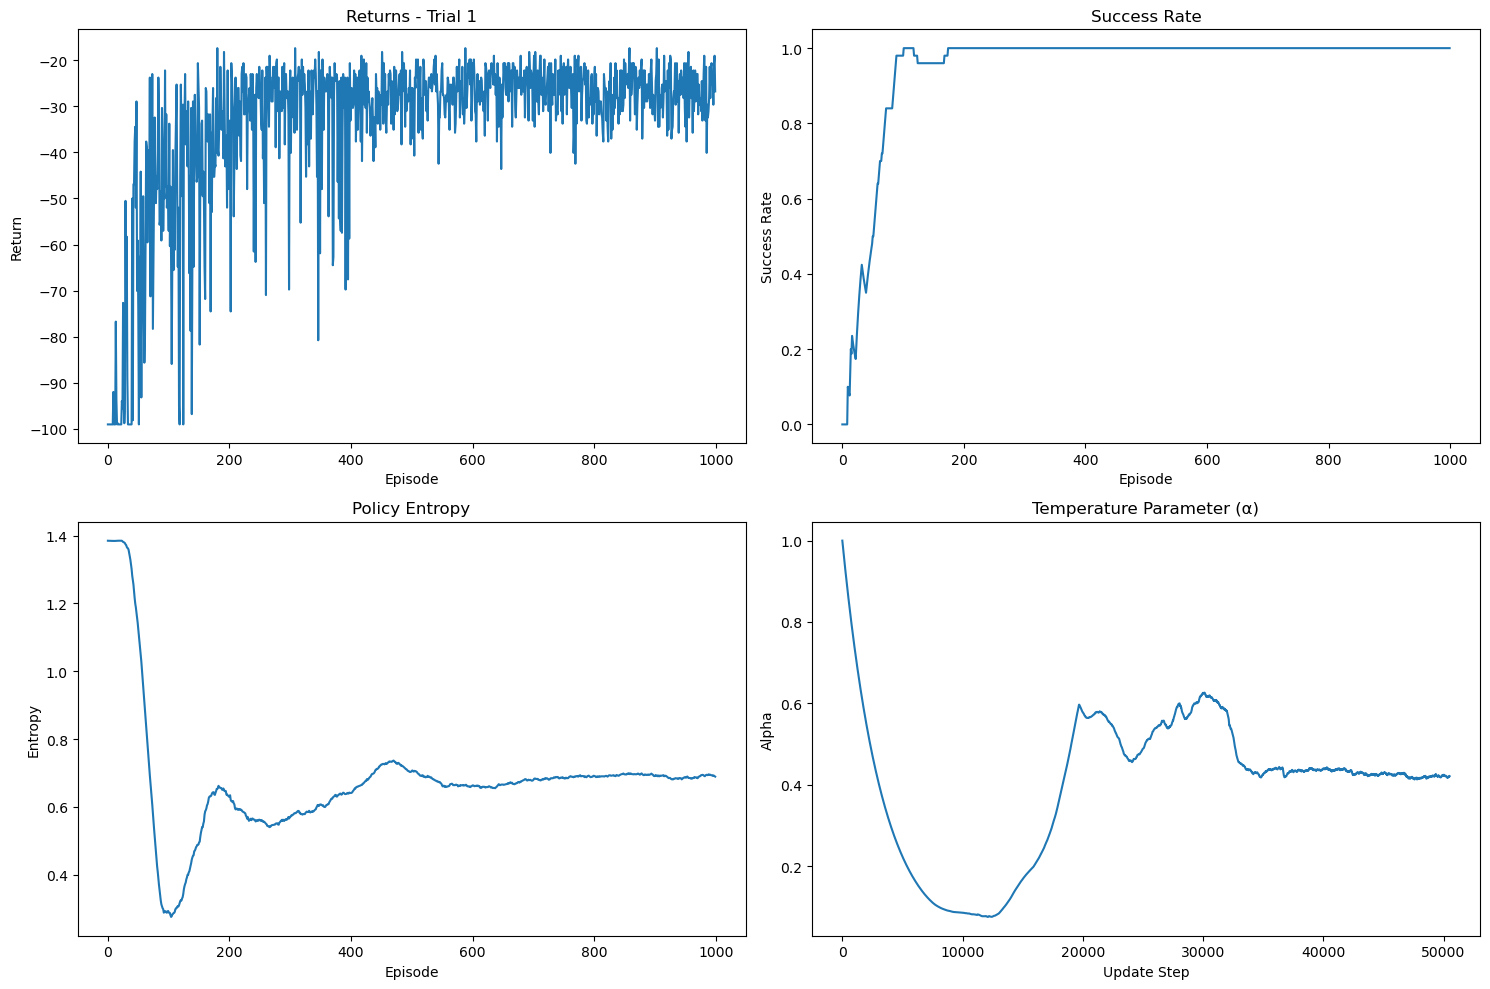


Trial 2/5


Ep:100 | R:-43.6 | AvgR:-72.9 | Succ:73.0% | Len:224.6 | α:0.243 | H:0.63:  10%|█         | 101/1000 [03:27<10:21,  1.45it/s]


Episode 100 Statistics:
Episode Return: -43.61
Average Return (100 ep): -72.87 ± 25.03
Success Rate (100 ep): 73.0%
Average Episode Length: 224.6
Evaluation Return: -49.60
Evaluation Success Rate: 100.0%
Average Q-Value: -18.29
Policy Entropy: 0.781
Alpha: 0.243
Policy Loss: 32.581
Q Loss: 2.115
--------------------------------------------------


Ep:200 | R:-49.5 | AvgR:-50.0 | Succ:100.0% | Len:76.4 | α:0.599 | H:0.37:  20%|██        | 201/1000 [04:54<11:12,  1.19it/s]


Episode 200 Statistics:
Episode Return: -49.51
Average Return (100 ep): -50.02 ± 15.35
Success Rate (100 ep): 100.0%
Average Episode Length: 76.4
Evaluation Return: -56.60
Evaluation Success Rate: 100.0%
Average Q-Value: -28.60
Policy Entropy: 0.684
Alpha: 0.599
Policy Loss: 27.002
Q Loss: 3.900
--------------------------------------------------


Ep:300 | R:-31.7 | AvgR:-32.8 | Succ:100.0% | Len:42.6 | α:0.673 | H:0.64:  30%|███       | 301/1000 [05:47<05:05,  2.29it/s]


Episode 300 Statistics:
Episode Return: -31.74
Average Return (100 ep): -32.81 ± 11.43
Success Rate (100 ep): 100.0%
Average Episode Length: 42.6
Evaluation Return: -23.80
Evaluation Success Rate: 100.0%
Average Q-Value: -20.26
Policy Entropy: 0.654
Alpha: 0.673
Policy Loss: 19.375
Q Loss: 2.504
--------------------------------------------------


Ep:400 | R:-31.7 | AvgR:-30.1 | Succ:100.0% | Len:39.0 | α:0.650 | H:0.72:  40%|████      | 401/1000 [06:32<03:59,  2.50it/s]


Episode 400 Statistics:
Episode Return: -31.74
Average Return (100 ep): -30.08 ± 11.66
Success Rate (100 ep): 100.0%
Average Episode Length: 39.0
Evaluation Return: -22.40
Evaluation Success Rate: 100.0%
Average Q-Value: -14.48
Policy Entropy: 0.671
Alpha: 0.650
Policy Loss: 13.501
Q Loss: 1.613
--------------------------------------------------


Ep:500 | R:-38.9 | AvgR:-29.1 | Succ:100.0% | Len:35.7 | α:0.458 | H:0.66:  50%|█████     | 501/1000 [07:13<03:31,  2.36it/s]


Episode 500 Statistics:
Episode Return: -38.89
Average Return (100 ep): -29.05 ± 6.95
Success Rate (100 ep): 100.0%
Average Episode Length: 35.7
Evaluation Return: -23.40
Evaluation Success Rate: 100.0%
Average Q-Value: -11.74
Policy Entropy: 0.716
Alpha: 0.458
Policy Loss: 11.524
Q Loss: 0.415
--------------------------------------------------


Ep:600 | R:-28.9 | AvgR:-27.2 | Succ:100.0% | Len:32.8 | α:0.431 | H:0.76:  60%|██████    | 601/1000 [07:53<02:24,  2.75it/s]


Episode 600 Statistics:
Episode Return: -28.94
Average Return (100 ep): -27.17 ± 4.76
Success Rate (100 ep): 100.0%
Average Episode Length: 32.8
Evaluation Return: -25.80
Evaluation Success Rate: 100.0%
Average Q-Value: -11.52
Policy Entropy: 0.699
Alpha: 0.431
Policy Loss: 11.318
Q Loss: 0.356
--------------------------------------------------


Ep:700 | R:-17.4 | AvgR:-26.2 | Succ:100.0% | Len:31.4 | α:0.444 | H:0.69:  70%|███████   | 701/1000 [08:29<01:32,  3.23it/s]


Episode 700 Statistics:
Episode Return: -17.38
Average Return (100 ep): -26.21 ± 4.36
Success Rate (100 ep): 100.0%
Average Episode Length: 31.4
Evaluation Return: -24.60
Evaluation Success Rate: 100.0%
Average Q-Value: -11.21
Policy Entropy: 0.683
Alpha: 0.444
Policy Loss: 11.214
Q Loss: 0.362
--------------------------------------------------


Ep:800 | R:-27.5 | AvgR:-26.8 | Succ:100.0% | Len:32.3 | α:0.447 | H:0.70:  80%|████████  | 801/1000 [09:06<01:12,  2.73it/s]


Episode 800 Statistics:
Episode Return: -27.50
Average Return (100 ep): -26.79 ± 4.90
Success Rate (100 ep): 100.0%
Average Episode Length: 32.3
Evaluation Return: -25.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.97
Policy Entropy: 0.681
Alpha: 0.447
Policy Loss: 10.935
Q Loss: 0.364
--------------------------------------------------


Ep:900 | R:-28.9 | AvgR:-27.3 | Succ:100.0% | Len:32.9 | α:0.437 | H:0.74:  90%|█████████ | 901/1000 [09:43<00:39,  2.50it/s]


Episode 900 Statistics:
Episode Return: -28.94
Average Return (100 ep): -27.25 ± 5.31
Success Rate (100 ep): 100.0%
Average Episode Length: 32.9
Evaluation Return: -27.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.85
Policy Entropy: 0.689
Alpha: 0.437
Policy Loss: 10.833
Q Loss: 0.349
--------------------------------------------------


Ep:999 | R:-20.6 | AvgR:-27.3 | Succ:100.0% | Len:33.0 | α:0.440 | H:0.69: 100%|██████████| 1000/1000 [10:22<00:00,  1.61it/s]


append to all_returns


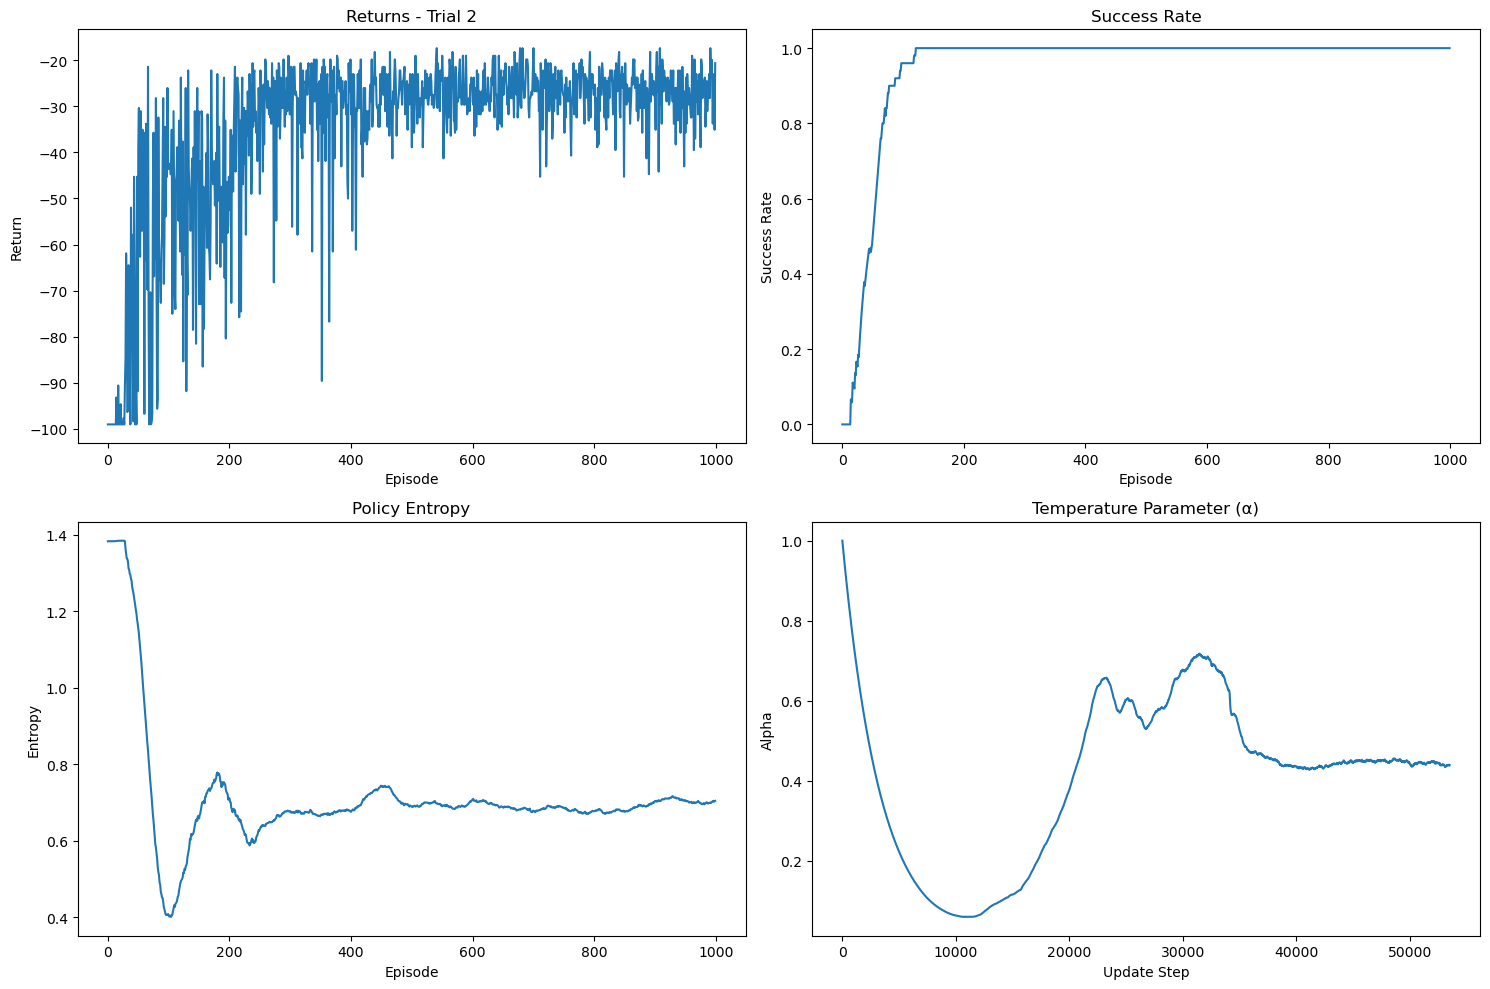


Trial 3/5


Ep:100 | R:-58.7 | AvgR:-70.5 | Succ:77.0% | Len:208.1 | α:0.207 | H:0.27:  10%|█         | 101/1000 [03:06<13:31,  1.11it/s]


Episode 100 Statistics:
Episode Return: -58.71
Average Return (100 ep): -70.51 ± 25.66
Success Rate (100 ep): 77.0%
Average Episode Length: 208.1
Evaluation Return: -43.20
Evaluation Success Rate: 100.0%
Average Q-Value: -16.81
Policy Entropy: 0.729
Alpha: 0.207
Policy Loss: 30.577
Q Loss: 1.577
--------------------------------------------------


Ep:200 | R:-33.8 | AvgR:-40.9 | Succ:100.0% | Len:55.4 | α:0.773 | H:0.80:  20%|██        | 201/1000 [04:14<06:44,  1.98it/s]


Episode 200 Statistics:
Episode Return: -33.77
Average Return (100 ep): -40.92 ± 11.03
Success Rate (100 ep): 100.0%
Average Episode Length: 55.4
Evaluation Return: -29.80
Evaluation Success Rate: 100.0%
Average Q-Value: -26.19
Policy Entropy: 0.623
Alpha: 0.773
Policy Loss: 25.017
Q Loss: 4.081
--------------------------------------------------


Ep:300 | R:-23.0 | AvgR:-33.7 | Succ:100.0% | Len:43.5 | α:0.616 | H:0.62:  30%|███       | 301/1000 [05:05<05:14,  2.22it/s]


Episode 300 Statistics:
Episode Return: -23.00
Average Return (100 ep): -33.69 ± 10.75
Success Rate (100 ep): 100.0%
Average Episode Length: 43.5
Evaluation Return: -36.00
Evaluation Success Rate: 100.0%
Average Q-Value: -19.78
Policy Entropy: 0.712
Alpha: 0.616
Policy Loss: 17.917
Q Loss: 2.092
--------------------------------------------------


Ep:400 | R:-21.4 | AvgR:-30.5 | Succ:100.0% | Len:38.7 | α:0.477 | H:0.64:  40%|████      | 401/1000 [05:49<03:20,  2.98it/s]


Episode 400 Statistics:
Episode Return: -21.43
Average Return (100 ep): -30.54 ± 9.67
Success Rate (100 ep): 100.0%
Average Episode Length: 38.7
Evaluation Return: -23.60
Evaluation Success Rate: 100.0%
Average Q-Value: -14.55
Policy Entropy: 0.660
Alpha: 0.477
Policy Loss: 14.072
Q Loss: 0.844
--------------------------------------------------


Ep:500 | R:-28.2 | AvgR:-27.2 | Succ:100.0% | Len:32.8 | α:0.472 | H:0.67:  50%|█████     | 501/1000 [06:26<03:12,  2.59it/s]


Episode 500 Statistics:
Episode Return: -28.23
Average Return (100 ep): -27.15 ± 5.01
Success Rate (100 ep): 100.0%
Average Episode Length: 32.8
Evaluation Return: -28.00
Evaluation Success Rate: 100.0%
Average Q-Value: -11.90
Policy Entropy: 0.671
Alpha: 0.472
Policy Loss: 11.785
Q Loss: 0.448
--------------------------------------------------


Ep:600 | R:-25.3 | AvgR:-26.3 | Succ:100.0% | Len:31.5 | α:0.439 | H:0.62:  60%|██████    | 601/1000 [07:02<02:13,  2.99it/s]


Episode 600 Statistics:
Episode Return: -25.28
Average Return (100 ep): -26.29 ± 4.18
Success Rate (100 ep): 100.0%
Average Episode Length: 31.5
Evaluation Return: -22.00
Evaluation Success Rate: 100.0%
Average Q-Value: -11.16
Policy Entropy: 0.685
Alpha: 0.439
Policy Loss: 11.091
Q Loss: 0.381
--------------------------------------------------


Ep:700 | R:-32.4 | AvgR:-27.3 | Succ:100.0% | Len:32.9 | α:0.426 | H:0.70:  70%|███████   | 701/1000 [07:39<01:48,  2.77it/s]


Episode 700 Statistics:
Episode Return: -32.43
Average Return (100 ep): -27.26 ± 5.13
Success Rate (100 ep): 100.0%
Average Episode Length: 32.9
Evaluation Return: -25.20
Evaluation Success Rate: 100.0%
Average Q-Value: -11.12
Policy Entropy: 0.698
Alpha: 0.426
Policy Loss: 10.884
Q Loss: 0.369
--------------------------------------------------


Ep:800 | R:-26.0 | AvgR:-26.6 | Succ:100.0% | Len:32.0 | α:0.434 | H:0.64:  80%|████████  | 801/1000 [08:15<01:16,  2.59it/s]


Episode 800 Statistics:
Episode Return: -26.03
Average Return (100 ep): -26.62 ± 4.62
Success Rate (100 ep): 100.0%
Average Episode Length: 32.0
Evaluation Return: -24.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.94
Policy Entropy: 0.692
Alpha: 0.434
Policy Loss: 10.754
Q Loss: 0.363
--------------------------------------------------


Ep:900 | R:-35.1 | AvgR:-26.5 | Succ:100.0% | Len:31.8 | α:0.429 | H:0.70:  90%|█████████ | 901/1000 [08:51<00:38,  2.55it/s]


Episode 900 Statistics:
Episode Return: -35.09
Average Return (100 ep): -26.53 ± 4.19
Success Rate (100 ep): 100.0%
Average Episode Length: 31.8
Evaluation Return: -27.40
Evaluation Success Rate: 100.0%
Average Q-Value: -11.01
Policy Entropy: 0.689
Alpha: 0.429
Policy Loss: 10.799
Q Loss: 0.361
--------------------------------------------------


Ep:999 | R:-33.8 | AvgR:-25.9 | Succ:100.0% | Len:31.0 | α:0.430 | H:0.66: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s]


append to all_returns


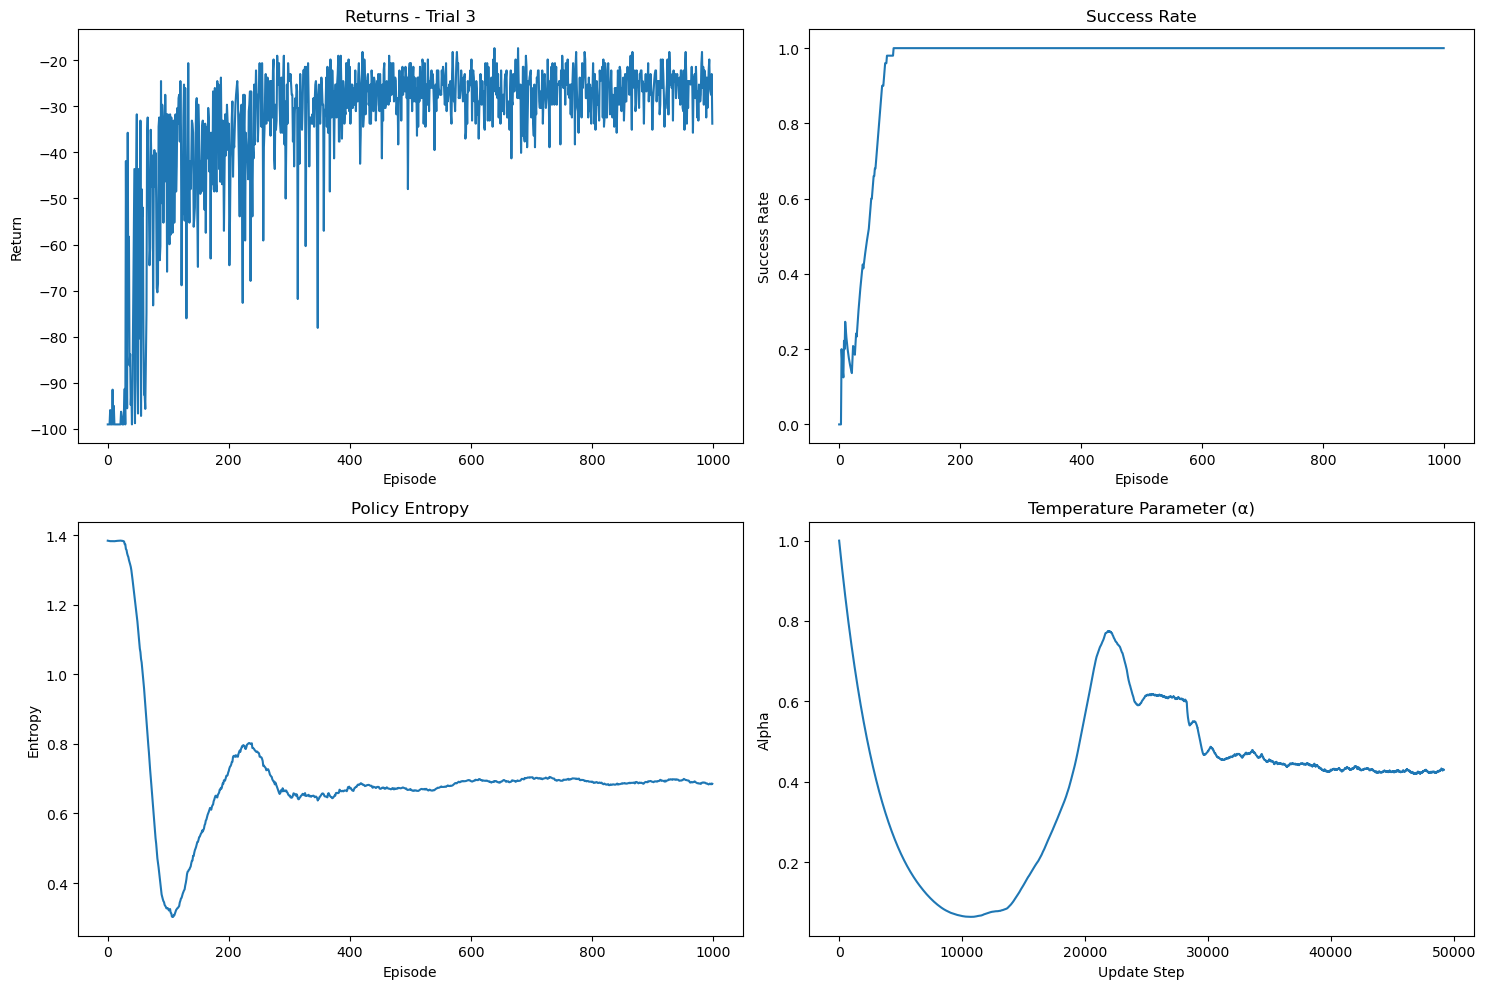


Trial 4/5


Ep:100 | R:-31.7 | AvgR:-64.7 | Succ:82.0% | Len:188.0 | α:0.117 | H:0.21:  10%|█         | 101/1000 [02:50<07:44,  1.94it/s]


Episode 100 Statistics:
Episode Return: -31.74
Average Return (100 ep): -64.69 ± 28.74
Success Rate (100 ep): 82.0%
Average Episode Length: 188.0
Evaluation Return: -45.60
Evaluation Success Rate: 100.0%
Average Q-Value: -15.68
Policy Entropy: 0.741
Alpha: 0.117
Policy Loss: 28.562
Q Loss: 1.494
--------------------------------------------------


Ep:200 | R:-22.2 | AvgR:-34.1 | Succ:100.0% | Len:45.6 | α:0.463 | H:0.53:  20%|██        | 201/1000 [03:42<04:34,  2.91it/s]


Episode 200 Statistics:
Episode Return: -22.22
Average Return (100 ep): -34.07 ± 13.51
Success Rate (100 ep): 100.0%
Average Episode Length: 45.6
Evaluation Return: -35.80
Evaluation Success Rate: 100.0%
Average Q-Value: -22.01
Policy Entropy: 0.414
Alpha: 0.463
Policy Loss: 25.018
Q Loss: 3.139
--------------------------------------------------


Ep:300 | R:-35.1 | AvgR:-28.8 | Succ:100.0% | Len:35.3 | α:0.617 | H:0.87:  30%|███       | 301/1000 [04:23<05:09,  2.26it/s]


Episode 300 Statistics:
Episode Return: -35.09
Average Return (100 ep): -28.79 ± 6.69
Success Rate (100 ep): 100.0%
Average Episode Length: 35.3
Evaluation Return: -26.40
Evaluation Success Rate: 100.0%
Average Q-Value: -16.21
Policy Entropy: 0.615
Alpha: 0.617
Policy Loss: 14.019
Q Loss: 0.985
--------------------------------------------------


Ep:400 | R:-31.7 | AvgR:-27.4 | Succ:100.0% | Len:33.1 | α:0.485 | H:0.71:  40%|████      | 401/1000 [05:00<03:54,  2.55it/s]


Episode 400 Statistics:
Episode Return: -31.74
Average Return (100 ep): -27.37 ± 5.23
Success Rate (100 ep): 100.0%
Average Episode Length: 33.1
Evaluation Return: -29.20
Evaluation Success Rate: 100.0%
Average Q-Value: -11.19
Policy Entropy: 0.714
Alpha: 0.485
Policy Loss: 10.850
Q Loss: 0.453
--------------------------------------------------


Ep:500 | R:-32.4 | AvgR:-27.2 | Succ:100.0% | Len:32.8 | α:0.435 | H:0.67:  50%|█████     | 501/1000 [05:37<03:46,  2.20it/s]


Episode 500 Statistics:
Episode Return: -32.43
Average Return (100 ep): -27.20 ± 5.09
Success Rate (100 ep): 100.0%
Average Episode Length: 32.8
Evaluation Return: -25.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.40
Policy Entropy: 0.711
Alpha: 0.435
Policy Loss: 10.428
Q Loss: 0.359
--------------------------------------------------


Ep:600 | R:-27.5 | AvgR:-26.9 | Succ:100.0% | Len:32.5 | α:0.425 | H:0.75:  60%|██████    | 601/1000 [06:15<02:25,  2.74it/s]


Episode 600 Statistics:
Episode Return: -27.50
Average Return (100 ep): -26.95 ± 4.72
Success Rate (100 ep): 100.0%
Average Episode Length: 32.5
Evaluation Return: -23.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.68
Policy Entropy: 0.700
Alpha: 0.425
Policy Loss: 10.552
Q Loss: 0.361
--------------------------------------------------


Ep:700 | R:-31.7 | AvgR:-26.6 | Succ:100.0% | Len:31.9 | α:0.416 | H:0.70:  70%|███████   | 701/1000 [06:51<02:00,  2.48it/s]


Episode 700 Statistics:
Episode Return: -31.74
Average Return (100 ep): -26.61 ± 3.81
Success Rate (100 ep): 100.0%
Average Episode Length: 31.9
Evaluation Return: -22.60
Evaluation Success Rate: 100.0%
Average Q-Value: -11.01
Policy Entropy: 0.703
Alpha: 0.416
Policy Loss: 10.753
Q Loss: 0.368
--------------------------------------------------


Ep:800 | R:-30.4 | AvgR:-26.4 | Succ:100.0% | Len:31.7 | α:0.406 | H:0.68:  80%|████████  | 801/1000 [07:27<01:16,  2.60it/s]


Episode 800 Statistics:
Episode Return: -30.36
Average Return (100 ep): -26.40 ± 4.62
Success Rate (100 ep): 100.0%
Average Episode Length: 31.7
Evaluation Return: -25.40
Evaluation Success Rate: 100.0%
Average Q-Value: -10.83
Policy Entropy: 0.704
Alpha: 0.406
Policy Loss: 10.783
Q Loss: 0.356
--------------------------------------------------


Ep:900 | R:-21.4 | AvgR:-26.0 | Succ:100.0% | Len:31.2 | α:0.416 | H:0.67:  90%|█████████ | 901/1000 [08:03<00:38,  2.57it/s]


Episode 900 Statistics:
Episode Return: -21.43
Average Return (100 ep): -26.04 ± 4.68
Success Rate (100 ep): 100.0%
Average Episode Length: 31.2
Evaluation Return: -25.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.73
Policy Entropy: 0.683
Alpha: 0.416
Policy Loss: 10.662
Q Loss: 0.352
--------------------------------------------------


Ep:999 | R:-28.2 | AvgR:-26.4 | Succ:100.0% | Len:31.7 | α:0.413 | H:0.70: 100%|██████████| 1000/1000 [08:39<00:00,  1.92it/s]


append to all_returns


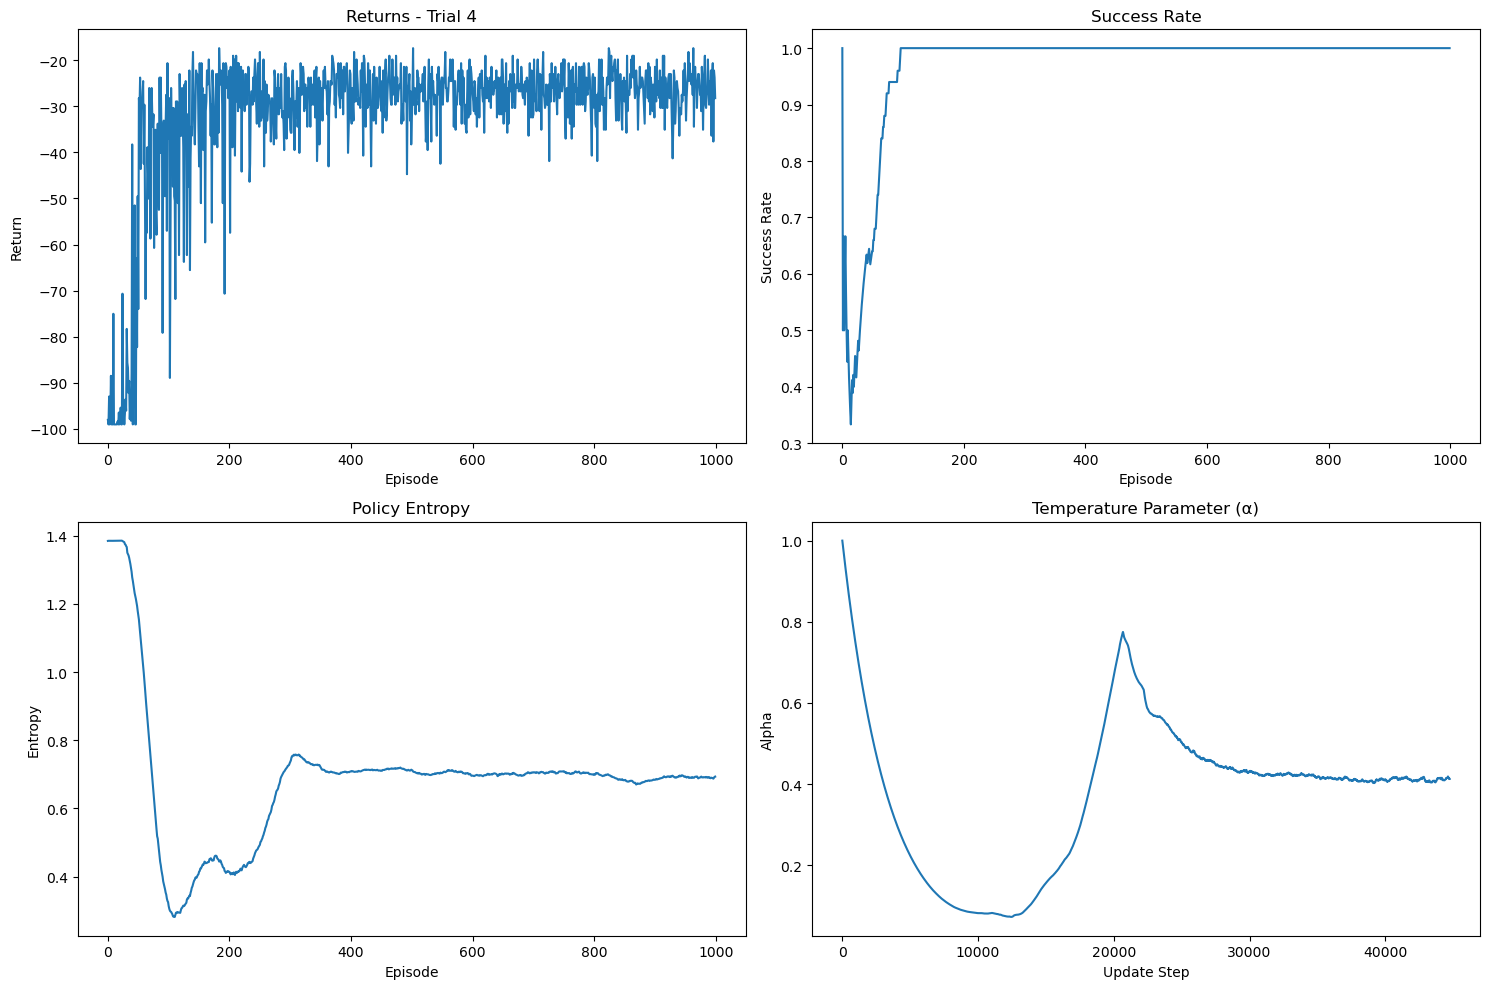


Trial 5/5


Ep:100 | R:-41.3 | AvgR:-66.0 | Succ:77.0% | Len:195.5 | α:0.169 | H:0.41:  10%|█         | 101/1000 [03:03<09:40,  1.55it/s]


Episode 100 Statistics:
Episode Return: -41.30
Average Return (100 ep): -66.00 ± 26.99
Success Rate (100 ep): 77.0%
Average Episode Length: 195.5
Evaluation Return: -49.20
Evaluation Success Rate: 100.0%
Average Q-Value: -15.05
Policy Entropy: 0.767
Alpha: 0.169
Policy Loss: 28.980
Q Loss: 1.449
--------------------------------------------------


Ep:200 | R:-32.4 | AvgR:-34.3 | Succ:100.0% | Len:44.9 | α:0.484 | H:0.53:  20%|██        | 201/1000 [03:56<06:03,  2.20it/s]


Episode 200 Statistics:
Episode Return: -32.43
Average Return (100 ep): -34.30 ± 12.05
Success Rate (100 ep): 100.0%
Average Episode Length: 44.9
Evaluation Return: -45.60
Evaluation Success Rate: 100.0%
Average Q-Value: -22.23
Policy Entropy: 0.478
Alpha: 0.484
Policy Loss: 24.815
Q Loss: 2.886
--------------------------------------------------


Ep:300 | R:-24.5 | AvgR:-31.7 | Succ:100.0% | Len:42.3 | α:0.758 | H:0.63:  30%|███       | 301/1000 [04:45<04:51,  2.40it/s]


Episode 300 Statistics:
Episode Return: -24.53
Average Return (100 ep): -31.67 ± 12.92
Success Rate (100 ep): 100.0%
Average Episode Length: 42.3
Evaluation Return: -52.40
Evaluation Success Rate: 100.0%
Average Q-Value: -17.51
Policy Entropy: 0.628
Alpha: 0.758
Policy Loss: 16.373
Q Loss: 2.630
--------------------------------------------------


Ep:400 | R:-27.5 | AvgR:-29.4 | Succ:100.0% | Len:36.0 | α:0.501 | H:0.67:  40%|████      | 401/1000 [05:27<03:35,  2.77it/s]


Episode 400 Statistics:
Episode Return: -27.50
Average Return (100 ep): -29.36 ± 5.85
Success Rate (100 ep): 100.0%
Average Episode Length: 36.0
Evaluation Return: -25.40
Evaluation Success Rate: 100.0%
Average Q-Value: -12.29
Policy Entropy: 0.741
Alpha: 0.501
Policy Loss: 11.194
Q Loss: 0.516
--------------------------------------------------


Ep:500 | R:-23.8 | AvgR:-27.1 | Succ:100.0% | Len:32.7 | α:0.431 | H:0.65:  50%|█████     | 501/1000 [06:05<03:15,  2.56it/s]


Episode 500 Statistics:
Episode Return: -23.77
Average Return (100 ep): -27.11 ± 5.17
Success Rate (100 ep): 100.0%
Average Episode Length: 32.7
Evaluation Return: -24.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.56
Policy Entropy: 0.681
Alpha: 0.431
Policy Loss: 10.865
Q Loss: 0.333
--------------------------------------------------


Ep:600 | R:-23.8 | AvgR:-27.4 | Succ:99.0% | Len:36.4 | α:0.425 | H:0.57:  60%|██████    | 601/1000 [06:47<02:24,  2.76it/s] 


Episode 600 Statistics:
Episode Return: -23.77
Average Return (100 ep): -27.44 ± 8.44
Success Rate (100 ep): 99.0%
Average Episode Length: 36.4
Evaluation Return: -25.00
Evaluation Success Rate: 100.0%
Average Q-Value: -11.10
Policy Entropy: 0.689
Alpha: 0.425
Policy Loss: 11.345
Q Loss: 0.420
--------------------------------------------------


Ep:700 | R:-25.3 | AvgR:-27.1 | Succ:100.0% | Len:32.7 | α:0.434 | H:0.78:  70%|███████   | 701/1000 [07:25<01:51,  2.69it/s]


Episode 700 Statistics:
Episode Return: -25.28
Average Return (100 ep): -27.13 ± 4.38
Success Rate (100 ep): 100.0%
Average Episode Length: 32.7
Evaluation Return: -24.80
Evaluation Success Rate: 100.0%
Average Q-Value: -11.02
Policy Entropy: 0.688
Alpha: 0.434
Policy Loss: 11.211
Q Loss: 0.402
--------------------------------------------------


Ep:800 | R:-20.6 | AvgR:-26.1 | Succ:100.0% | Len:31.2 | α:0.427 | H:0.64:  80%|████████  | 801/1000 [08:01<01:05,  3.03it/s]


Episode 800 Statistics:
Episode Return: -20.64
Average Return (100 ep): -26.05 ± 4.15
Success Rate (100 ep): 100.0%
Average Episode Length: 31.2
Evaluation Return: -25.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.87
Policy Entropy: 0.694
Alpha: 0.427
Policy Loss: 11.165
Q Loss: 0.406
--------------------------------------------------


Ep:900 | R:-20.6 | AvgR:-27.1 | Succ:100.0% | Len:32.6 | α:0.437 | H:0.63:  90%|█████████ | 901/1000 [08:39<00:33,  2.92it/s]


Episode 900 Statistics:
Episode Return: -20.64
Average Return (100 ep): -27.06 ± 4.52
Success Rate (100 ep): 100.0%
Average Episode Length: 32.6
Evaluation Return: -26.40
Evaluation Success Rate: 100.0%
Average Q-Value: -11.02
Policy Entropy: 0.690
Alpha: 0.437
Policy Loss: 10.821
Q Loss: 0.366
--------------------------------------------------


Ep:999 | R:-36.4 | AvgR:-27.1 | Succ:100.0% | Len:32.6 | α:0.436 | H:0.77: 100%|██████████| 1000/1000 [09:16<00:00,  1.80it/s]


append to all_returns


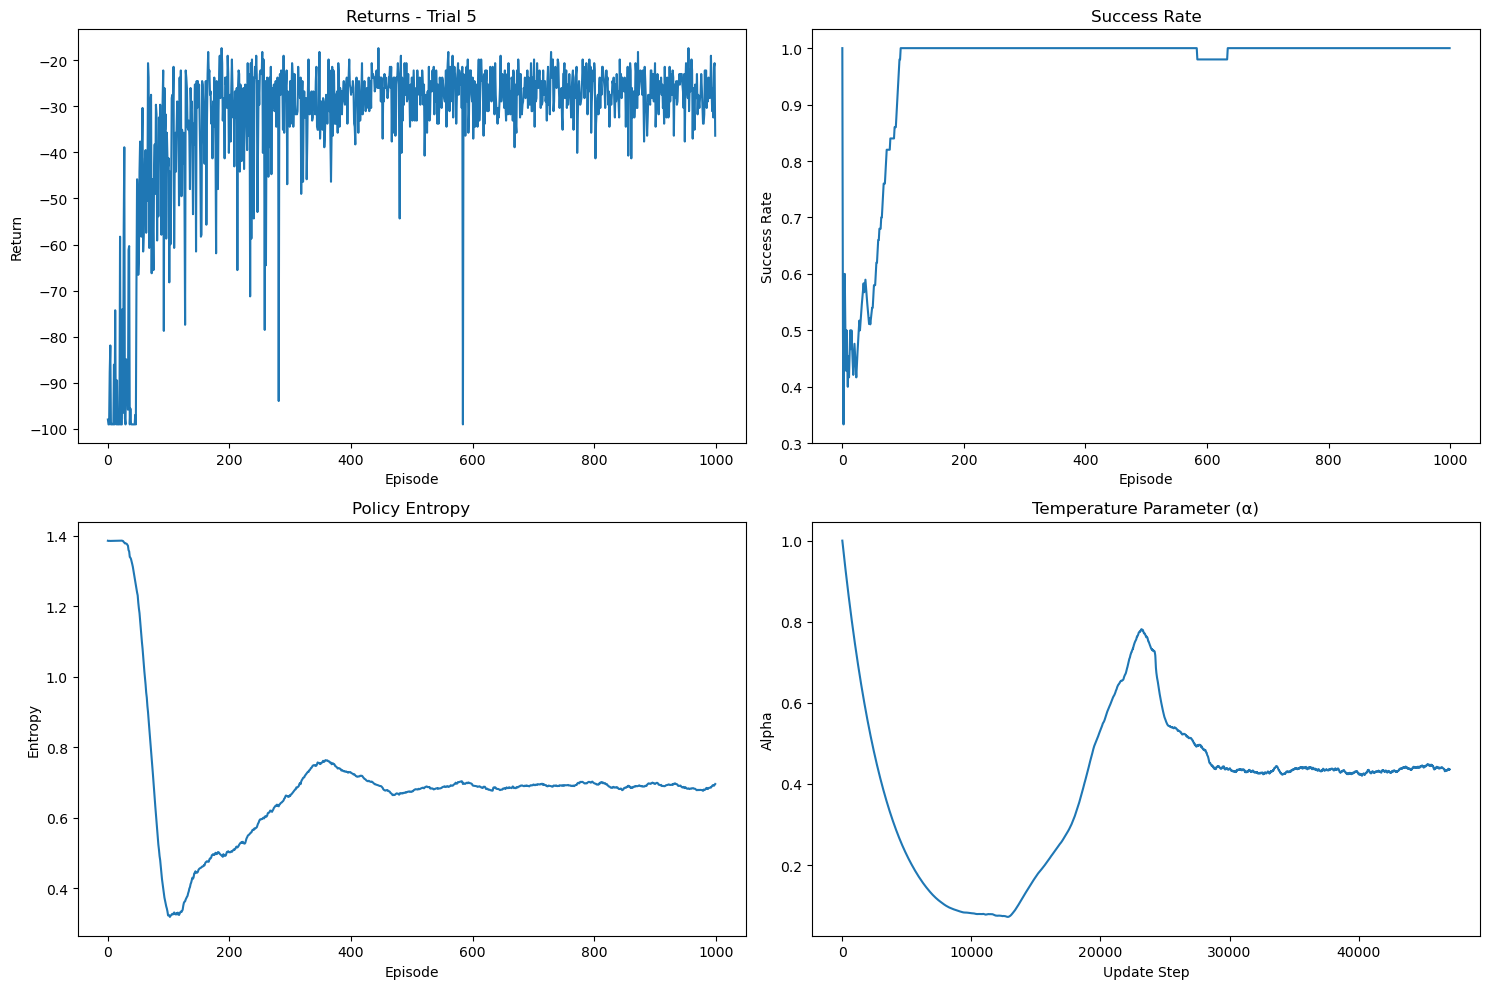

In [123]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
from collections import namedtuple, deque
import tqdm
import matplotlib.pyplot as plt

# Replay buffer transition tuple
Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    def __init__(self, capacity, state_dim=3, device="cpu"):
        self.capacity = capacity
        self.device = device
        self.memory = []
        self.position = 0
        
    def push(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).to(self.device)
        action = torch.tensor([action], dtype=torch.long).to(self.device)
        reward = torch.tensor([reward], dtype=torch.float32).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.tensor([done], dtype=torch.float32).to(self.device)
        
        transition = Transition(state, action, reward, next_state, done)
        
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        indices = np.random.choice(len(self.memory), batch_size)
        transitions = [self.memory[idx] for idx in indices]
        batch = Transition(*zip(*transitions))
        
        states = torch.stack(batch.state)
        actions = torch.stack(batch.action)
        rewards = torch.stack(batch.reward)
        next_states = torch.stack(batch.next_state)
        dones = torch.stack(batch.done)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
    def forward(self, state):
        return self.net(state)

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, state):
        return self.net(state)

class SACAgent:
    def __init__(self, state_dim=3, action_dim=4, hidden_dim=256,
                 lr=3e-4, gamma=0.99, tau=0.005,
                 batch_size=256, device="cpu"):
        self.gamma = gamma
        self.tau = tau
        self.device = device
        self.batch_size = batch_size
        self.action_dim = action_dim
        
        # Networks
        self.critic1 = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.critic2 = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.critic1_target = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.critic2_target = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.actor = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)
        
        # Copy target parameters
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        
        # Optimizers with eps like reference
        self.critic1_optimizer = torch.optim.Adam(self.critic1.parameters(), lr=lr, eps=1e-4)
        self.critic2_optimizer = torch.optim.Adam(self.critic2.parameters(), lr=lr, eps=1e-4)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr, eps=1e-4)
        
        # Entropy tuning matching reference
        self.target_entropy = -np.log((1.0 / action_dim)) * 0.5 
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=lr, eps=1e-4)
        
    @property
    def alpha(self):
        return self.log_alpha.exp()
    
    def get_action(self, state, evaluate=False):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            action_probs = self.actor(state)
            if evaluate:
                action = torch.argmax(action_probs, dim=-1)
            else:
                dist = Categorical(action_probs)
                action = dist.sample()
            return action.item()
    
    def calculate_critic_losses(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        with torch.no_grad():
            next_action_probs = self.actor(next_state_batch)
            # Handle zero probabilities exactly like reference
            z = next_action_probs == 0.0
            z = z.float() * 1e-8
            log_next_action_probs = torch.log(next_action_probs + z)
            
            next_q1 = self.critic1_target(next_state_batch)
            next_q2 = self.critic2_target(next_state_batch)
            
            # Matching reference implementation exactly
            min_qf_next_target = next_action_probs * (
                torch.min(next_q1, next_q2) - self.alpha * log_next_action_probs
            )
            min_qf_next_target = min_qf_next_target.sum(dim=1).unsqueeze(-1)
            next_q_value = reward_batch + (1 - done_batch) * self.gamma * min_qf_next_target

        q1 = self.critic1(state_batch).gather(1, action_batch.long())
        q2 = self.critic2(state_batch).gather(1, action_batch.long())
        
        critic1_loss = F.mse_loss(q1, next_q_value)
        critic2_loss = F.mse_loss(q2, next_q_value)
        
        return critic1_loss, critic2_loss

    def calculate_actor_loss(self, state_batch):
        action_probs = self.actor(state_batch)
        # Handle zero probabilities
        z = action_probs == 0.0
        z = z.float() * 1e-8
        log_action_probs = torch.log(action_probs + z)
        
        q1 = self.critic1(state_batch)
        q2 = self.critic2(state_batch)
        min_q = torch.min(q1, q2).detach()
        
        # Matching reference implementation
        inside_term = self.alpha * log_action_probs - min_q
        policy_loss = (action_probs * inside_term).sum(dim=1).mean()
        log_action_probs = torch.sum(log_action_probs * action_probs, dim=1)
        
        return policy_loss, log_action_probs
    # Standard Four Rooms SAC Update Method
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch, total_steps, freq_update_target):
        """Standard SAC update for Four Rooms"""
        # Get gradients before updates
        pre_grad_stats = track_grad_stats(self)
        
        # Critic update
        critic1_loss, critic2_loss = self.calculate_critic_losses(
            state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()
        
        # Actor update
        policy_loss, log_probs = self.calculate_actor_loss(state_batch)
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        # Alpha update 
        alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        # Target update
        if total_steps % freq_update_target == 0:
            for target_param, param in zip(self.critic1_target.parameters(), self.critic1.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
            for target_param, param in zip(self.critic2_target.parameters(), self.critic2.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
                
        return pre_grad_stats, {
            'critic1_loss': critic1_loss.item(),
            'critic2_loss': critic2_loss.item(),
            'policy_loss': policy_loss.item(),
            'alpha': self.alpha.item()
    }
def evaluate_policy(env, agent, num_episodes=5):
    """Runs policy evaluation episodes."""
    eval_returns = []
    eval_successes = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        state_features = [state[0] / 10.0, state[1] / 10.0, 1.0]
        episode_return = 0
        done = False
        reached_goal = False

        while not done:
            action = agent.get_action(state_features, evaluate=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                reached_goal = True

            episode_return += reward
            state = next_state
            state_features = [state[0] / 10.0, state[1] / 10.0, 1.0]

        eval_returns.append(episode_return)
        eval_successes.append(float(reached_goal))

    # Return all evaluation returns and successes for further processing
    return np.array(eval_returns), np.array(eval_successes)


def train_sac_trials(num_trials=10, num_episodes=10000, smoothing=True):
    """Run multiple trials with detailed logging"""
    all_returns = []
    all_losses = []
    eval_returns_array = np.zeros((num_trials, num_episodes // 100 + 1, 5))  # Store all episodes
    eval_success_array = np.zeros((num_trials, num_episodes // 100 + 1, 5))  # Store all episodes
    all_grad_metrics = []
    
    training_params = {
        'num_episodes': num_episodes,
        'batch_size': 256,
        'buffer_size': 10_000,
        'learning_rate': 3e-4,
        'hidden_dim': 256,
        'gamma': 0.99,
        'tau': 0.005,
        'min_steps_before_learning': 5000,
        "freq_update_target": 1,
        "updates_per_step": 1, 
        "steps_per_update": 1
    }
    
    for trial in range(num_trials):
        print(f"\nTrial {trial + 1}/{num_trials}")
        
        # Set seeds
        torch.manual_seed(trial)
        np.random.seed(trial)
        
        env = FourRooms()
        eval_env = FourRooms()
        agent = SACAgent()
        buffer = ReplayBuffer(training_params['buffer_size'])
        
        # Training metrics
        trial_returns = []
        episode_lengths = []
        q_values = []
        entropies = []
        alphas = []
        policy_losses = []
        q_losses = []
        success_rate = []
        grad_metrics = {
            'actor_grad_mag': [],
            'critic1_grad_mag': [],
            'critic2_grad_mag': [],
            'total_grad_mag': []
        }
        
        total_steps = 0
        pbar = tqdm.trange(training_params['num_episodes'])
        
        for episode in pbar:
            state, _ = env.reset()
            episode_rewards = []
            episode_length = 0
            episode_q_values = []
            episode_entropies = []
            
            done = False
            reached_goal = False
            
            while not done:
                # Get state features and action
                state_features = [state[0]/10.0, state[1]/10.0, 1.0]
                state_tensor = torch.FloatTensor(state_features).unsqueeze(0).to(agent.device)
                
                # Get action and log metrics
                with torch.no_grad():
                    probs = agent.actor(state_tensor)
                    q1 = agent.critic1(state_tensor)
                    q2 = agent.critic2(state_tensor)
                    episode_q_values.append(torch.max(torch.min(q1, q2)).item())
                    entropy = -(probs * torch.log(probs + 1e-8)).sum(1).item()
                    episode_entropies.append(entropy)
                
                action = agent.get_action(state_features)
                
                # Environment step
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                if terminated:
                    reached_goal = True
                
                next_state_features = [next_state[0]/10.0, next_state[1]/10.0, 1.0]
                
                # Store transition
                buffer.push(state_features, action, reward, next_state_features, done)
                
                            # Update if enough samples
                if total_steps > training_params['min_steps_before_learning'] and len(buffer) >= training_params['batch_size'] and total_steps % training_params['steps_per_update'] == 0:
                    for _ in range(training_params["updates_per_step"]):
                        batch = buffer.sample(training_params['batch_size'])
                        grad_stats, loss_dict = agent.update(*batch, total_steps, training_params["freq_update_target"])

                        for key, value in grad_stats.items():
                            grad_metrics[key].append(value)
                        
                        
                        policy_losses.append(loss_dict['policy_loss'])
                        q_losses.append((loss_dict['critic1_loss'] + loss_dict['critic2_loss']) / 2)
                        alphas.append(loss_dict['alpha'])
                        
                episode_rewards.append(reward)
                episode_length += 1
                total_steps += 1
                state = next_state
            
            # Compute total discounted return for the episode
            G = 0
            for r in reversed(episode_rewards):
                G = r + training_params['gamma'] * G
            episode_return = G  # Total discounted return for the episode
            
            # Store the episode return
            #print(episode_return)
            #print("append to trial_returns")
            trial_returns.append(episode_return)
            episode_lengths.append(episode_length)
            success_rate.append(float(reached_goal))
            
            if episode_q_values:
                q_values.append(np.mean(episode_q_values))
            if episode_entropies:
                entropies.append(np.mean(episode_entropies))
            
            # Update progress bar with per-episode return
            current_return = trial_returns[-1]
            avg_return = np.mean(trial_returns[-100:]) if len(trial_returns) >= 100 else np.mean(trial_returns)
            avg_success = np.mean(success_rate[-100:]) * 100 if len(success_rate) >= 100 else np.mean(success_rate) * 100
            avg_length = np.mean(episode_lengths[-100:]) if len(episode_lengths) >= 100 else np.mean(episode_lengths)
            
            current_alpha = alphas[-1] if alphas else 0
            current_entropy = entropies[-1] if entropies else 0
            
            desc = f"Ep:{episode} | R:{current_return:.1f} | AvgR:{avg_return:.1f} | Succ:{avg_success:.1f}% | Len:{avg_length:.1f}"
            if alphas:
                desc += f" | α:{current_alpha:.3f}"
            if entropies:
                desc += f" | H:{current_entropy:.2f}"
            
            pbar.set_description(desc)
            
            # Periodically print detailed stats
            if episode % 100 == 0 and episode > 0:
                eval_returns, eval_successes = evaluate_policy(eval_env, agent)
                # Store raw evaluation returns and successes
                eval_idx = episode // 100
                eval_returns_array[trial, eval_idx] = eval_returns
                eval_success_array[trial, eval_idx] = eval_successes

                stats = f"\nEpisode {episode} Statistics:"
                stats += f"\nEpisode Return: {current_return:.2f}"
                stats += f"\nAverage Return (100 ep): {np.mean(trial_returns[-100:]):.2f} ± {np.std(trial_returns[-100:]):.2f}"
                stats += f"\nSuccess Rate (100 ep): {np.mean(success_rate[-100:]) * 100:.1f}%"
                stats += f"\nAverage Episode Length: {np.mean(episode_lengths[-100:]):.1f}"
                # add evaluation stats
                stats += f"\nEvaluation Return: {np.mean(eval_returns):.2f}"
                stats += f"\nEvaluation Success Rate: {(np.mean(eval_successes)*100):.1f}%"
                if q_values:
                    stats += f"\nAverage Q-Value: {np.mean(q_values[-100:]):.2f}"
                if entropies:
                    stats += f"\nPolicy Entropy: {np.mean(entropies[-100:]):.3f}"
                if alphas:
                    stats += f"\nAlpha: {alphas[-1]:.3f}"
                if policy_losses:
                    stats += f"\nPolicy Loss: {np.mean(policy_losses[-100:]):.3f}"
                if q_losses:
                    stats += f"\nQ Loss: {np.mean(q_losses[-100:]):.3f}"
                stats += "\n" + "-" * 50
                pbar.write(stats)
        
        # Store trial results
        print("append to all_returns")
        all_returns.append(trial_returns)
        all_grad_metrics.append(grad_metrics)
        all_losses.append({
            'policy_loss': policy_losses,
            'q_loss': q_losses,
            'alpha': alphas
        })
        
        if len(trial_returns) > 0:
            plt.figure(figsize=(15, 10))
            
            # Plot returns
            plt.subplot(2, 2, 1)
            plt.plot(trial_returns)
            plt.title(f'Returns - Trial {trial+1}')
            plt.xlabel('Episode')
            plt.ylabel('Return')
            
            # Plot success rate
            plt.subplot(2, 2, 2)
            plt.plot(moving_average(np.array(success_rate)) if smoothing else success_rate)
            plt.title('Success Rate')
            plt.xlabel('Episode')
            plt.ylabel('Success Rate')
            
            # Plot entropy if we have it
            if entropies:
                plt.subplot(2, 2, 3)
                plt.plot(moving_average(np.array(entropies)) if smoothing else entropies)
                plt.title('Policy Entropy')
                plt.xlabel('Episode')
                plt.ylabel('Entropy')
            
            # Plot alpha if we have it
            if alphas:
                plt.subplot(2, 2, 4)
                plt.plot(alphas)
                plt.title('Temperature Parameter (α)')
                plt.xlabel('Update Step')
                plt.ylabel('Alpha')
            
            plt.tight_layout()
            plt.show()
    
    return all_returns, eval_returns_array, eval_success_array, all_losses, all_grad_metrics, agent


# Run training
returns, eval_returns, eval_success, losses, grad_metrics, agent = train_sac_trials(num_trials=5, num_episodes=1000)

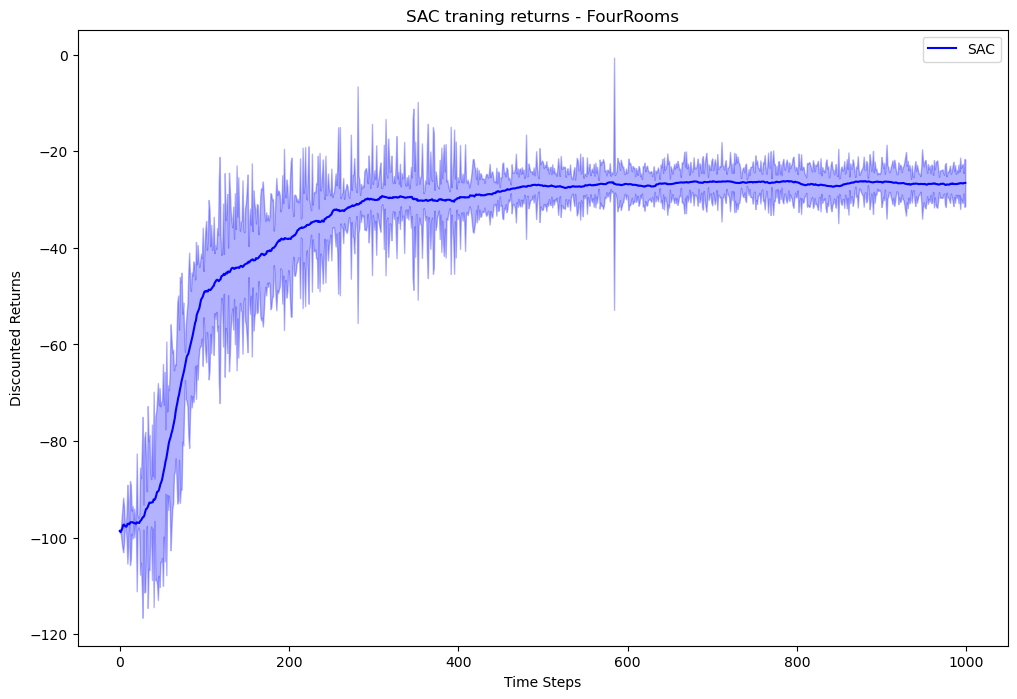

In [126]:
returns = np.array(returns)
plot_curves([returns], ['SAC'], ['b'], 'Discounted Returns', 'SAC traning returns - FourRooms', smoothing=True)

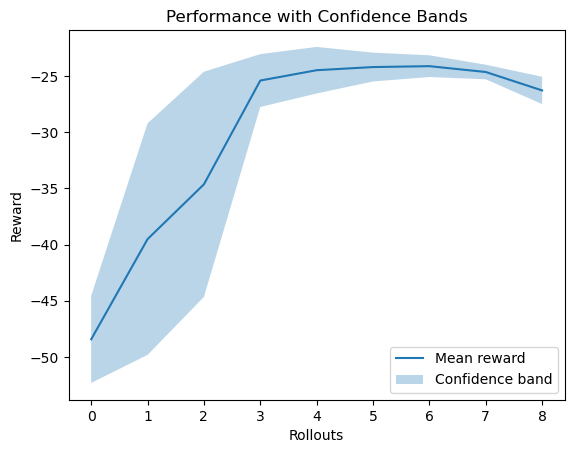

In [127]:
#plot ema eval returns
eval_returns = np.array(eval_returns)
eval_returns = eval_returns[:, 1:-1, :]
import numpy as np
import matplotlib.pyplot as plt

# assuming `arr` is your (5, 9, 5) array

# average across episodes for each trial and rollout
mean_values = np.mean(eval_returns, axis=2)  # shape: (5, 9)
std_values = np.std(eval_returns, axis=2)    # shape: (5, 9)

# average across trials
mean_across_trials = np.mean(mean_values, axis=0)  # shape: (9,)
std_across_trials = np.std(mean_values, axis=0)    # shape: (9,)

# plot
x = np.arange(mean_across_trials.shape[0])  # rollouts

plt.plot(x, mean_across_trials, label="Mean reward")
plt.fill_between(x, mean_across_trials - std_across_trials,
                 mean_across_trials + std_across_trials, alpha=0.3, label="Confidence band")
plt.xlabel("Rollouts")
plt.ylabel("Reward")
plt.legend()
plt.title("Performance with Confidence Bands")
plt.show()


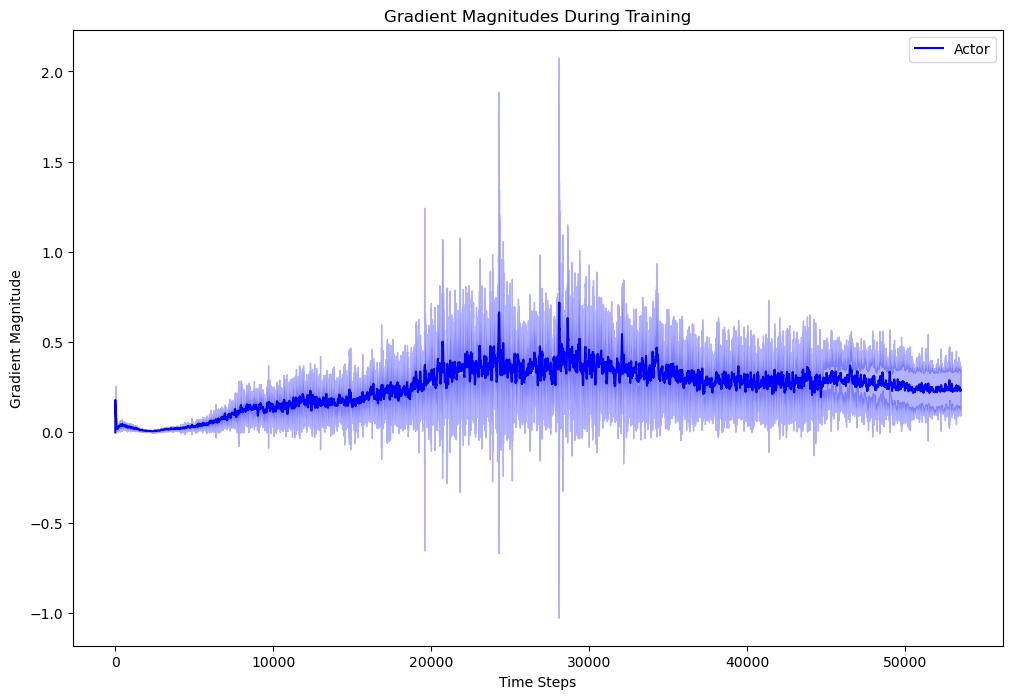

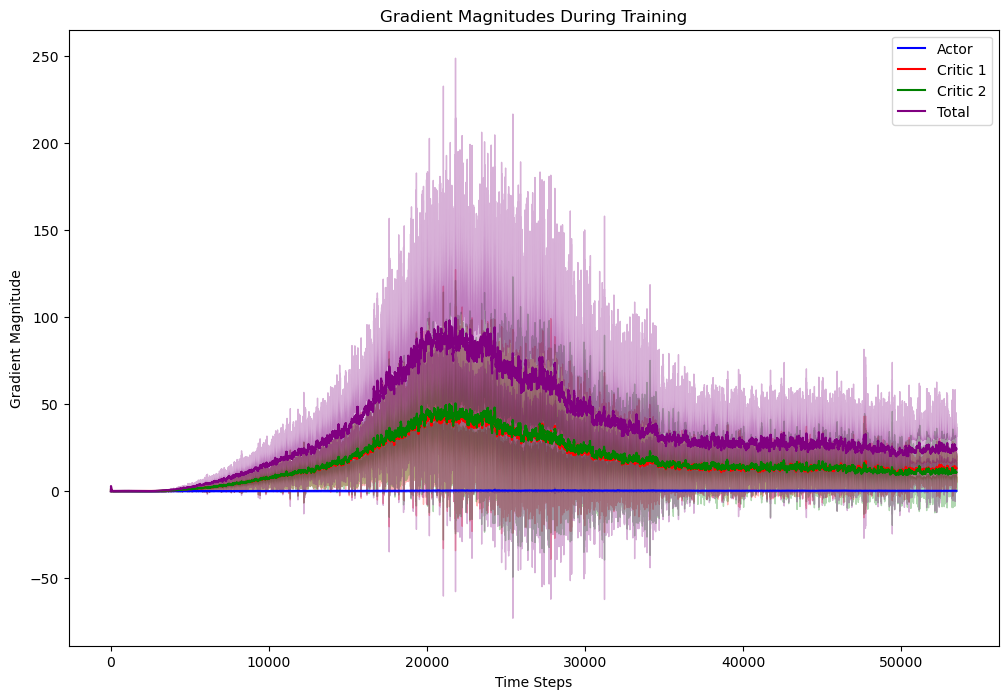

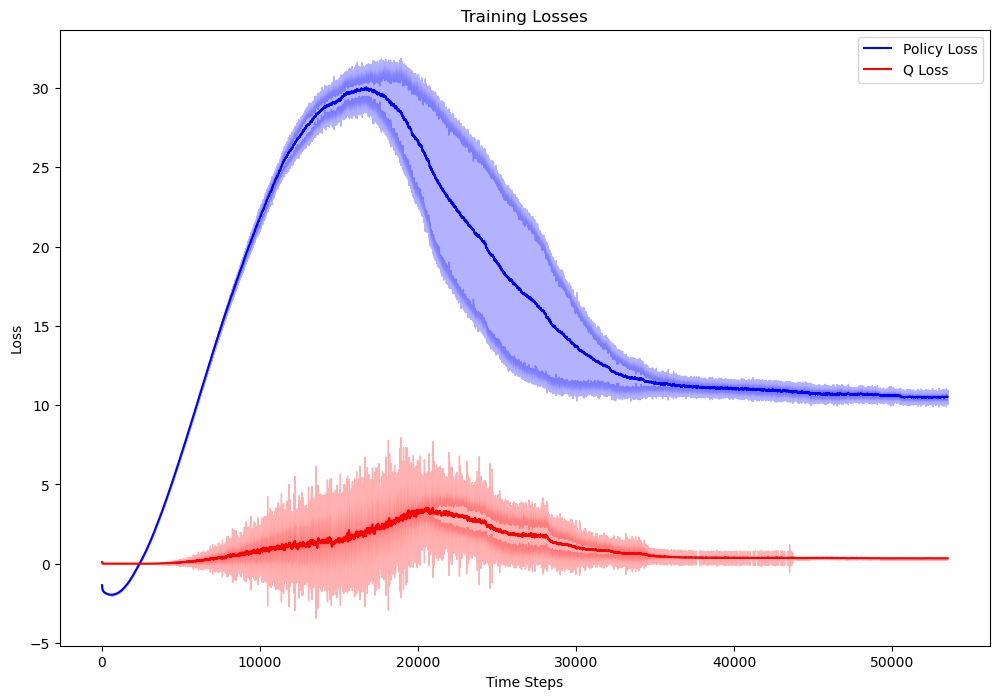

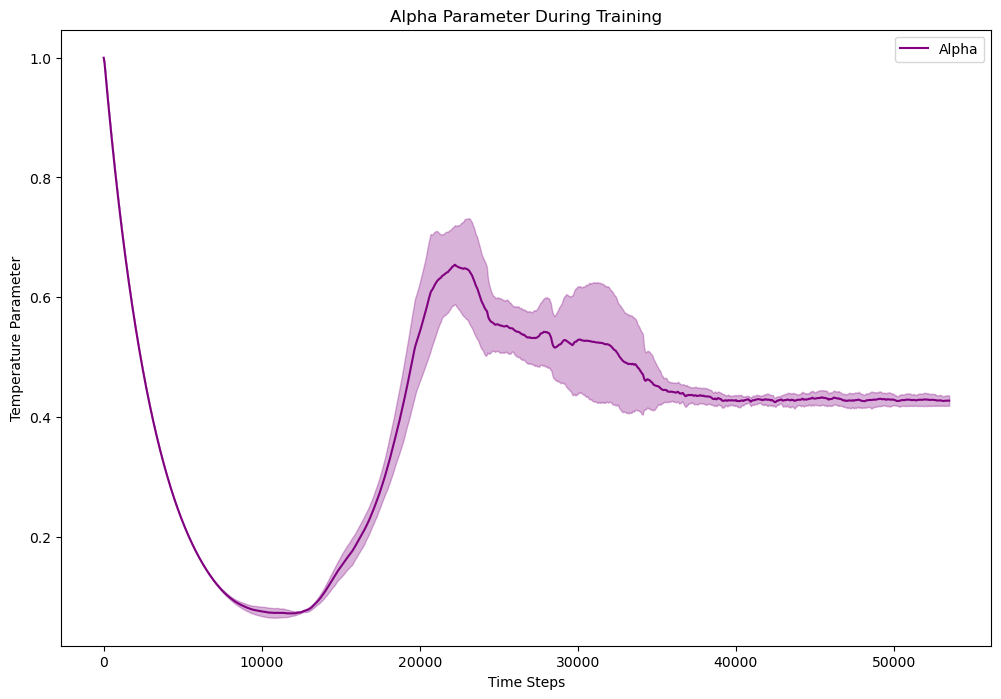

In [128]:
plot_training_metrics(grad_metrics, losses)


In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import random
from collections import deque
from tqdm import tqdm
import gymnasium as gym
import os
import shutil
from datetime import datetime
import matplotlib.pyplot as plt

# ----------------------------- Replay Buffer ----------------------------- #

class ReplayBuffer:
    def __init__(self, capacity, batch_size, state_dim, device):
        self.capacity = capacity
        self.batch_size = batch_size
        self.device = device
        self.ptr = 0
        self.size = 0

        # Preallocate tensors for efficiency
        self.states = torch.zeros((capacity, state_dim), dtype=torch.float32, device=device)
        self.actions = torch.zeros((capacity, 1), dtype=torch.long, device=device)
        self.rewards = torch.zeros((capacity, 1), dtype=torch.float32, device=device)
        self.next_states = torch.zeros((capacity, state_dim), dtype=torch.float32, device=device)
        self.dones = torch.zeros((capacity, 1), dtype=torch.float32, device=device)

    def add(self, state, action, reward, next_state, done):
        self.states[self.ptr] = torch.from_numpy(state).float()
        self.actions[self.ptr] = torch.tensor([action], dtype=torch.long)
        self.rewards[self.ptr] = torch.tensor([reward], dtype=torch.float32)
        self.next_states[self.ptr] = torch.from_numpy(next_state).float()
        self.dones[self.ptr] = torch.tensor([done], dtype=torch.float32)

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self):
        indices = torch.randint(0, self.size, (self.batch_size,), device=self.device)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )

    def __len__(self):
        return self.size

# ----------------------------- Networks ----------------------------- #

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x), dim=-1)
        
    def get_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(next(self.parameters()).device)
        probs = self.forward(state)
        dist = Categorical(probs)
        if evaluate:
            action = torch.argmax(probs, dim=-1)
        else:  
            action = dist.sample()
        return action.item()

class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class SACAgentLunar:
    def __init__(self, state_dim, action_dim, hidden_dim=256, lr=3e-4, gamma=0.99, tau=0.005, device="cpu", initial_alpha=0.2):
        self.gamma = gamma
        self.tau = tau
        self.device = device
        self.action_dim = action_dim
        
        # Initialize networks
        self.actor = Actor(state_dim, action_dim, hidden_dim).to(device)
        self.critic1 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic2 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic1_target = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic2_target = Critic(state_dim, action_dim, hidden_dim).to(device)
        
        # Copy parameters to targets
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        
        # Initialize optimizers with proper hyperparameters
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr, eps=1e-4)
        self.critic1_optimizer = torch.optim.Adam(self.critic1.parameters(), lr=lr, eps=1e-4)
        self.critic2_optimizer = torch.optim.Adam(self.critic2.parameters(), lr=lr, eps=1e-4)
        
        # Initialize temperature parameter with alpha=0.2
        self.target_entropy = 0.6 * (-np.log(1 / action_dim))  # Target entropy
        self.log_alpha = torch.tensor(np.log(initial_alpha), dtype=torch.float32, requires_grad=True, device=device)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=lr, eps=1e-4)
        self.alpha = self.log_alpha.exp().item()
        self.H_mean = 0  # Track entropy
        
    @property
    def alpha_value(self):
        return self.log_alpha.exp().item()
    
    def get_action(self, state, evaluate=False):
        return self.actor.get_action(state, evaluate)
    
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        """Standard SAC update for Lunar Lander"""
        # Get gradients before updates
        pre_grad_stats = track_grad_stats(self)
        
        with torch.no_grad():
            next_probs = self.actor(next_state_batch)
            next_log_probs = torch.log(next_probs + 1e-8)
            q1_next = self.critic1_target(next_state_batch)
            q2_next = self.critic2_target(next_state_batch)
            min_q_next = torch.min(q1_next, q2_next)
            target_q = (next_probs * (min_q_next - self.alpha * next_log_probs)).sum(dim=1, keepdim=True)
            target_q = reward_batch + (1 - done_batch) * self.gamma * target_q
        
        # Critic updates
        current_q1 = self.critic1(state_batch).gather(1, action_batch)
        current_q2 = self.critic2(state_batch).gather(1, action_batch)
        
        critic1_loss = F.mse_loss(current_q1, target_q)
        critic2_loss = F.mse_loss(current_q2, target_q)
        
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()
        

        # Actor update (policy loss)
        probs = self.actor(state_batch)
        log_probs = torch.log(probs + 1e-8)
        q1 = self.critic1(state_batch).detach()  # [batch, action_dim]
        q2 = self.critic2(state_batch).detach()  # [batch, action_dim]
        min_q = torch.min(q1, q2)
        actor_loss = (probs * (self.alpha * log_probs - min_q)).sum(dim=1).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Alpha update
        with torch.no_grad():
            self.H_mean = -(probs * log_probs).sum(dim=1).mean()
            
        alpha_loss = self.log_alpha * (self.H_mean - self.target_entropy)
        
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        # Update alpha value
        self.alpha = self.alpha_value

        # Soft update targets
        self.soft_update(self.critic1, self.critic1_target)
        self.soft_update(self.critic2, self.critic2_target)
        
        return pre_grad_stats, {
            'critic1_loss': critic1_loss.item(),
            'critic2_loss': critic2_loss.item(),
            'actor_loss': actor_loss.item(),
            'alpha': self.alpha
        }
    
    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
    
    def save(self, timestep, EnvName):
        os.makedirs("models", exist_ok=True)
        torch.save(self.actor.state_dict(), f"./models/sacd_actor_{timestep}_{EnvName}.pth")
        torch.save(self.critic1.state_dict(), f"./models/sacd_critic1_{timestep}_{EnvName}.pth")
        torch.save(self.critic2.state_dict(), f"./models/sacd_critic2_{timestep}_{EnvName}.pth")
    
    def load(self, timestep, EnvName):
        self.actor.load_state_dict(torch.load(f"./models/sacd_actor_{timestep}_{EnvName}.pth", map_location=self.device))
        self.critic1.load_state_dict(torch.load(f"./models/sacd_critic1_{timestep}_{EnvName}.pth", map_location=self.device))
        self.critic2.load_state_dict(torch.load(f"./models/sacd_critic2_{timestep}_{EnvName}.pth", map_location=self.device))

# ----------------------------- Training and Evaluation ----------------------------- #

def compute_discounted_return(rewards, gamma):
    """Compute the discounted return by iterating backwards through the rewards."""
    discounted_return = 0.0
    for r in reversed(rewards):
        discounted_return = r + gamma * discounted_return
    return discounted_return

def evaluate_agent(env, agent, num_episodes=5, gamma=0.99):
    """Evaluate agent with both sum of rewards and discounted returns."""
    agent.actor.eval()
    sum_returns = []
    discounted_returns = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0.0
        episode_rewards = []
        while not done:
            action = agent.get_action(state, evaluate=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            episode_rewards.append(reward)
            state = next_state
        sum_returns.append(total_reward)
        discounted_returns.append(compute_discounted_return(episode_rewards, gamma))
    agent.actor.train()
    return np.mean(sum_returns), np.mean(discounted_returns)

def set_seed(seed, env):
    """Set seeds for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.reset(seed=seed)

def train_sac_lunar(num_trials=5, num_steps=400_000, buffer_capacity=1_000_000, batch_size=256,
                   prepopulate_steps=10_000, eval_interval=10, num_eval_episodes=5, gamma=0.99, steps_per_update=50, updates_per_step=50):
    """Run multiple trials for Lunar Lander with standard SAC"""
    all_returns = []
    all_disc_returns = []
    all_eval_returns = []
    all_eval_disc = []
    all_losses = []
    all_grad_metrics = []
    all_episode_lengths = []  # New: Track episode lengths across all trials
    
    for trial in range(num_trials):
        print(f"\nTrial {trial + 1}/{num_trials}")
        
        # Set seeds
        seed = trial
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        env = gym.make("LunarLander-v2")
        eval_env = gym.make("LunarLander-v2")
        env.reset(seed=seed)
        eval_env.reset(seed=seed+1000)

        best_eval_return = float('-inf')
        
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        agent = SACAgentLunar(state_dim, action_dim, hidden_dim=200, lr=3e-4,
                           gamma=gamma, tau=0.005, device=device, initial_alpha=0.2)
        buffer = ReplayBuffer(buffer_capacity, batch_size, state_dim, device)
        
        returns = deque(maxlen=100)
        returns_over_steps = []  # For storing all returns
        discounted_returns = []
        eval_returns_sum = []
        eval_returns_discounted = []
        policy_losses = []
        q_losses = []
        alphas = []
        episode_lengths = []  # New: Track episode lengths for this trial
        grad_metrics = {
            'actor_grad_mag': [],
            'critic1_grad_mag': [],
            'critic2_grad_mag': [],
            'total_grad_mag': []
        }
        
        # Prepopulate buffer
        state, _ = env.reset()
        pbar = tqdm(range(prepopulate_steps), desc="Prepopulating buffer")
        for _ in pbar:
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            if reward <= -100:
                reward = -10.0
            
            buffer.add(state, action, reward, next_state, done)
            
            if done:
                state, _ = env.reset()
            else:
                state = next_state
        
        # Training loop
        total_steps = 0
        episode = 0
        state, _ = env.reset()
        episode_rewards = []
        episode_step_count = 0  # New: Counter for steps in current episode
        
        pbar = tqdm(range(num_steps), desc=f"Training Trial {trial+1}")
        for step in pbar:
            total_steps += 1
            episode_step_count += 1  # New: Increment step counter
            
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            episode_rewards.append(reward)
            
            if reward <= -100:
                reward = -10.0
            
            buffer.add(state, action, reward, next_state, done)
            
            if len(buffer) >= batch_size and total_steps % steps_per_update == 0:
                for _ in range(updates_per_step):
                    grad_stats, loss_dict = agent.update(*buffer.sample())
                
                    for key, value in grad_stats.items():
                        grad_metrics[key].append(value)
                    
                    policy_losses.append(loss_dict['actor_loss'])
                    q_losses.append((loss_dict['critic1_loss'] + loss_dict['critic2_loss']) / 2)
                    alphas.append(loss_dict['alpha'])
            
            if done:
                sum_return = sum(episode_rewards)
                discounted_return = compute_discounted_return(episode_rewards, gamma)
                
                returns.append(sum_return)
                returns_over_steps.append(sum_return)
                discounted_returns.append(discounted_return)
                episode_lengths.append(episode_step_count)  # New: Store episode length
                
                episode_rewards = []
                episode_step_count = 0  # New: Reset step counter
                state, _ = env.reset()
                episode += 1
                
                if episode % eval_interval == 0:
                    eval_return_sum, eval_return_disc = evaluate_agent(eval_env, agent, num_eval_episodes, gamma)
                    eval_returns_sum.append(eval_return_sum)
                    eval_returns_discounted.append(eval_return_disc)
                    print(f"\nStep {total_steps}, Episode {episode}, Eval Return Sum: {eval_return_sum:.1f}, Eval Return Discounted: {eval_return_disc:.1f}")
                    # Save best model
                    if eval_return_sum > best_eval_return:
                        best_eval_return = eval_return_sum
                        agent.save(total_steps, "LunarLander")
                        print(f"New best model saved with Eval Return Sum: {eval_return_sum:.1f}")
                
                mean_return = np.mean(list(returns))
                mean_length = np.mean(episode_lengths[-100:])  # New: Calculate mean episode length
                # Add gradient magnitudes and episode length to description
                recent_grads = {k: np.mean(v[-100:]) for k, v in grad_metrics.items() if v}
                desc = (f"Trial: {trial+1} | Step: {step} | Episode: {episode} | Return: {sum_return:.1f} | "
                       f"Discounted: {discounted_return:.1f} | Avg100: {mean_return:.1f} | "
                       f"Avg Length: {mean_length:.1f} | "  # New: Added average length to progress bar 
                       f"Actor Grad: {recent_grads.get('actor_grad_mag', 0):.3f} | "
                       f"Critic Grads: {recent_grads.get('critic1_grad_mag', 0):.3f}, "
                       f"{recent_grads.get('critic2_grad_mag', 0):.3f}")
                pbar.set_description(desc)
            else:
                state = next_state
        
        # Store trial results
        all_returns.append(returns_over_steps)
        all_disc_returns.append(discounted_returns)
        all_eval_returns.append(eval_returns_sum)
        all_eval_disc.append(eval_returns_discounted)
        all_grad_metrics.append(grad_metrics)
        all_episode_lengths.append(episode_lengths)  # New: Store episode lengths for this trial
        all_losses.append({
            'policy_loss': policy_losses,
            'q_loss': q_losses,
            'alpha': alphas
        })
        
        env.close()
        eval_env.close()
    
    return agent, all_returns, all_disc_returns, all_eval_returns, all_eval_disc, all_losses, all_grad_metrics, all_episode_lengths  # New: Added all_episode_lengths to return values
  

In [52]:
# Define parameters directly
env_name = 'LunarLander-v2'
prepopulate_steps = 10_000
batch_size = 256
buffer_capacity = 100_000
num_train_steps = 350_000
eval_interval = 10
num_eval_episodes = 5
gamma = 0.99
    
# Create environment
env = gym.make(env_name)
    
# Train SAC Agent
lunarSACAgent, returns_over_steps, discounted_returns, eval_returns_sum, eval_returns_discount, all_losses, all_grad_metrics, all_episode_lengths = train_sac_lunar(
        num_trials=3,
        num_steps=num_train_steps,
        buffer_capacity=buffer_capacity,
        batch_size=batch_size,
        prepopulate_steps=prepopulate_steps,
        eval_interval=eval_interval,
        num_eval_episodes=num_eval_episodes,
        gamma=gamma
    )


Trial 1/3


Prepopulating buffer: 100%|██████████| 10000/10000 [00:00<00:00, 19170.27it/s]
Trial: 1 | Step: 3252 | Episode: 10 | Return: -18.0 | Discounted: -0.8 | Avg100: -195.6 | Avg Length: 325.3 | Actor Grad: 0.527 | Critic Grads: 77.015, 76.649:   1%|          | 3261/350000 [00:32<1:02:37, 92.29it/s]


Step 3253, Episode 10, Eval Return Sum: -40.2, Eval Return Discounted: 20.2
New best model saved with Eval Return Sum: -40.2


Trial: 1 | Step: 5213 | Episode: 20 | Return: -175.9 | Discounted: -29.0 | Avg100: -180.9 | Avg Length: 260.7 | Actor Grad: 0.581 | Critic Grads: 119.877, 119.220:   1%|▏         | 5214/350000 [00:51<1:01:26, 93.54it/s]


Step 5214, Episode 20, Eval Return Sum: -483.0, Eval Return Discounted: -170.5


Trial: 1 | Step: 7132 | Episode: 30 | Return: 15.0 | Discounted: 9.3 | Avg100: -127.7 | Avg Length: 237.8 | Actor Grad: 0.561 | Critic Grads: 122.096, 119.631:   2%|▏         | 7133/350000 [01:10<1:03:51, 89.49it/s]    


Step 7133, Episode 30, Eval Return Sum: -122.0, Eval Return Discounted: 27.2


Trial: 1 | Step: 9711 | Episode: 40 | Return: -38.7 | Discounted: 8.9 | Avg100: -98.7 | Avg Length: 242.8 | Actor Grad: 0.324 | Critic Grads: 132.519, 128.675:   3%|▎         | 9712/350000 [01:35<1:13:21, 77.31it/s] 


Step 9712, Episode 40, Eval Return Sum: -90.5, Eval Return Discounted: 6.6


Trial: 1 | Step: 12024 | Episode: 50 | Return: -60.2 | Discounted: -13.9 | Avg100: -80.7 | Avg Length: 240.5 | Actor Grad: 0.447 | Critic Grads: 149.598, 144.175:   3%|▎         | 12025/350000 [01:58<57:01, 98.78it/s] 


Step 12025, Episode 50, Eval Return Sum: -1.1, Eval Return Discounted: 21.5
New best model saved with Eval Return Sum: -1.1


Trial: 1 | Step: 14313 | Episode: 60 | Return: 41.2 | Discounted: 34.4 | Avg100: -68.7 | Avg Length: 238.6 | Actor Grad: 0.416 | Critic Grads: 161.087, 154.032:   4%|▍         | 14314/350000 [02:21<55:11, 101.38it/s]   


Step 14314, Episode 60, Eval Return Sum: 61.8, Eval Return Discounted: 15.5
New best model saved with Eval Return Sum: 61.8


Trial: 1 | Step: 17384 | Episode: 70 | Return: -36.7 | Discounted: 0.1 | Avg100: -60.5 | Avg Length: 248.4 | Actor Grad: 0.455 | Critic Grads: 173.530, 167.621:   5%|▍         | 17385/350000 [02:51<51:47, 107.03it/s]  


Step 17385, Episode 70, Eval Return Sum: -41.2, Eval Return Discounted: 27.9


Trial: 1 | Step: 21768 | Episode: 80 | Return: 152.4 | Discounted: 52.1 | Avg100: -51.6 | Avg Length: 272.1 | Actor Grad: 0.361 | Critic Grads: 189.019, 183.863:   6%|▌         | 21769/350000 [03:34<1:07:09, 81.46it/s]


Step 21769, Episode 80, Eval Return Sum: -56.8, Eval Return Discounted: 28.6


Trial: 1 | Step: 31768 | Episode: 90 | Return: 68.2 | Discounted: 30.2 | Avg100: -34.5 | Avg Length: 353.0 | Actor Grad: 0.578 | Critic Grads: 241.915, 230.623:   9%|▉         | 31769/350000 [05:12<1:05:16, 81.25it/s] 


Step 31769, Episode 90, Eval Return Sum: -26.1, Eval Return Discounted: 35.3


Trial: 1 | Step: 41768 | Episode: 100 | Return: 87.3 | Discounted: 26.5 | Avg100: -21.2 | Avg Length: 417.7 | Actor Grad: 0.518 | Critic Grads: 233.628, 231.264:  12%|█▏        | 41769/350000 [06:50<1:03:18, 81.15it/s]


Step 41769, Episode 100, Eval Return Sum: -46.2, Eval Return Discounted: 26.2


Trial: 1 | Step: 51332 | Episode: 110 | Return: 83.9 | Discounted: 25.2 | Avg100: 7.6 | Avg Length: 480.8 | Actor Grad: 0.353 | Critic Grads: 176.410, 174.793:  15%|█▍        | 51333/350000 [08:25<56:46, 87.66it/s]    


Step 51333, Episode 110, Eval Return Sum: -63.4, Eval Return Discounted: 34.3


Trial: 1 | Step: 61332 | Episode: 120 | Return: 39.6 | Discounted: 46.3 | Avg100: 34.7 | Avg Length: 561.2 | Actor Grad: 0.236 | Critic Grads: 217.799, 205.893:  18%|█▊        | 61333/350000 [10:07<55:11, 87.18it/s]  


Step 61333, Episode 120, Eval Return Sum: 7.7, Eval Return Discounted: 43.2


Trial: 1 | Step: 70672 | Episode: 130 | Return: 228.9 | Discounted: 84.1 | Avg100: 50.6 | Avg Length: 635.4 | Actor Grad: 0.306 | Critic Grads: 168.798, 186.933:  20%|██        | 70673/350000 [11:41<56:46, 82.01it/s] 


Step 70673, Episode 130, Eval Return Sum: -21.9, Eval Return Discounted: 36.4


Trial: 1 | Step: 79901 | Episode: 140 | Return: 83.4 | Discounted: 75.9 | Avg100: 63.7 | Avg Length: 701.9 | Actor Grad: 0.399 | Critic Grads: 236.407, 224.990:  23%|██▎       | 79910/350000 [13:15<56:21, 79.87it/s]   


Step 79902, Episode 140, Eval Return Sum: 164.3, Eval Return Discounted: 43.3
New best model saved with Eval Return Sum: 164.3


Trial: 1 | Step: 89901 | Episode: 150 | Return: 115.7 | Discounted: 36.2 | Avg100: 76.8 | Avg Length: 778.8 | Actor Grad: 0.328 | Critic Grads: 151.426, 145.942:  26%|██▌       | 89911/350000 [14:57<50:14, 86.27it/s] 


Step 89902, Episode 150, Eval Return Sum: 200.9, Eval Return Discounted: 38.8
New best model saved with Eval Return Sum: 200.9


Trial: 1 | Step: 97823 | Episode: 160 | Return: 169.1 | Discounted: 35.4 | Avg100: 90.5 | Avg Length: 835.1 | Actor Grad: 0.222 | Critic Grads: 139.645, 140.191:  28%|██▊       | 97824/350000 [16:16<43:53, 95.77it/s] 


Step 97824, Episode 160, Eval Return Sum: 191.1, Eval Return Discounted: 51.5


Trial: 1 | Step: 107823 | Episode: 170 | Return: 122.5 | Discounted: 58.0 | Avg100: 104.9 | Avg Length: 904.4 | Actor Grad: 0.262 | Critic Grads: 96.610, 102.788:  31%|███       | 107824/350000 [17:54<41:48, 96.56it/s]  


Step 107824, Episode 170, Eval Return Sum: 129.3, Eval Return Discounted: 53.2


Trial: 1 | Step: 117192 | Episode: 180 | Return: 183.9 | Discounted: 87.4 | Avg100: 118.9 | Avg Length: 954.2 | Actor Grad: 0.255 | Critic Grads: 98.095, 107.773:  33%|███▎      | 117193/350000 [19:28<37:53, 102.39it/s] 


Step 117193, Episode 180, Eval Return Sum: 180.2, Eval Return Discounted: 40.2


Trial: 1 | Step: 126269 | Episode: 190 | Return: 108.2 | Discounted: 29.7 | Avg100: 121.9 | Avg Length: 945.0 | Actor Grad: 0.218 | Critic Grads: 95.071, 82.888:  36%|███▌      | 126270/350000 [21:02<39:43, 93.85it/s]  


Step 126270, Episode 190, Eval Return Sum: 226.1, Eval Return Discounted: 50.2
New best model saved with Eval Return Sum: 226.1


Trial: 1 | Step: 136269 | Episode: 200 | Return: 131.1 | Discounted: 43.3 | Avg100: 125.3 | Avg Length: 945.0 | Actor Grad: 0.209 | Critic Grads: 102.717, 90.259:  39%|███▉      | 136270/350000 [22:45<40:02, 88.96it/s]


Step 136270, Episode 200, Eval Return Sum: 176.9, Eval Return Discounted: 33.4


Trial: 1 | Step: 146269 | Episode: 210 | Return: 155.7 | Discounted: 64.0 | Avg100: 129.7 | Avg Length: 949.4 | Actor Grad: 0.231 | Critic Grads: 86.361, 79.494:  42%|████▏     | 146270/350000 [24:27<37:42, 90.04it/s]  


Step 146270, Episode 210, Eval Return Sum: 196.5, Eval Return Discounted: 51.6


Trial: 1 | Step: 156269 | Episode: 220 | Return: 151.0 | Discounted: 51.3 | Avg100: 135.0 | Avg Length: 949.4 | Actor Grad: 0.203 | Critic Grads: 75.753, 75.325:  45%|████▍     | 156270/350000 [26:10<35:45, 90.28it/s]


Step 156270, Episode 220, Eval Return Sum: 227.0, Eval Return Discounted: 53.5
New best model saved with Eval Return Sum: 227.0


Trial: 1 | Step: 166269 | Episode: 230 | Return: 157.4 | Discounted: 73.8 | Avg100: 136.9 | Avg Length: 956.0 | Actor Grad: 0.284 | Critic Grads: 106.911, 80.787:  48%|████▊     | 166270/350000 [27:52<30:36, 100.07it/s]


Step 166270, Episode 230, Eval Return Sum: 274.3, Eval Return Discounted: 55.6
New best model saved with Eval Return Sum: 274.3


Trial: 1 | Step: 176090 | Episode: 240 | Return: 125.0 | Discounted: 50.1 | Avg100: 141.4 | Avg Length: 961.9 | Actor Grad: 0.222 | Critic Grads: 76.727, 66.306:  50%|█████     | 176091/350000 [29:34<27:12, 106.53it/s] 


Step 176091, Episode 240, Eval Return Sum: 249.3, Eval Return Discounted: 55.3


Trial: 1 | Step: 185391 | Episode: 250 | Return: 178.8 | Discounted: 53.5 | Avg100: 145.2 | Avg Length: 954.9 | Actor Grad: 0.214 | Critic Grads: 75.683, 70.805:  53%|█████▎    | 185392/350000 [31:09<24:46, 110.77it/s]


Step 185392, Episode 250, Eval Return Sum: 237.0, Eval Return Discounted: 61.0


Trial: 1 | Step: 195391 | Episode: 260 | Return: 150.6 | Discounted: 49.2 | Avg100: 148.0 | Avg Length: 975.7 | Actor Grad: 0.214 | Critic Grads: 63.550, 61.102:  56%|█████▌    | 195392/350000 [32:52<22:26, 114.84it/s]


Step 195392, Episode 260, Eval Return Sum: 256.3, Eval Return Discounted: 60.1


Trial: 1 | Step: 205282 | Episode: 270 | Return: 139.7 | Discounted: 52.3 | Avg100: 151.4 | Avg Length: 974.6 | Actor Grad: 0.304 | Critic Grads: 66.164, 62.665:  59%|█████▊    | 205283/350000 [34:33<21:13, 113.62it/s]


Step 205283, Episode 270, Eval Return Sum: 264.5, Eval Return Discounted: 64.6


Trial: 1 | Step: 215282 | Episode: 280 | Return: 125.4 | Discounted: 44.2 | Avg100: 150.4 | Avg Length: 980.9 | Actor Grad: 0.311 | Critic Grads: 58.696, 54.926:  62%|██████▏   | 215283/350000 [36:12<20:57, 107.13it/s]


Step 215283, Episode 280, Eval Return Sum: 237.4, Eval Return Discounted: 65.8


Trial: 1 | Step: 224817 | Episode: 290 | Return: 176.4 | Discounted: 66.5 | Avg100: 153.9 | Avg Length: 985.5 | Actor Grad: 0.277 | Critic Grads: 88.085, 75.242:  64%|██████▍   | 224818/350000 [37:45<20:21, 102.50it/s]


Step 224818, Episode 290, Eval Return Sum: 263.2, Eval Return Discounted: 70.1


Trial: 1 | Step: 234084 | Episode: 300 | Return: 202.8 | Discounted: 60.0 | Avg100: 156.4 | Avg Length: 978.1 | Actor Grad: 0.358 | Critic Grads: 49.772, 47.084:  67%|██████▋   | 234085/350000 [39:16<17:48, 108.45it/s]


Step 234085, Episode 300, Eval Return Sum: 243.3, Eval Return Discounted: 49.8


Trial: 1 | Step: 244084 | Episode: 310 | Return: 149.6 | Discounted: 63.1 | Avg100: 157.3 | Avg Length: 978.1 | Actor Grad: 0.315 | Critic Grads: 51.459, 48.405:  70%|██████▉   | 244085/350000 [40:53<16:35, 106.35it/s]


Step 244085, Episode 310, Eval Return Sum: 145.9, Eval Return Discounted: 50.1


Trial: 1 | Step: 251843 | Episode: 320 | Return: 60.5 | Discounted: 35.1 | Avg100: 156.1 | Avg Length: 955.7 | Actor Grad: 0.268 | Critic Grads: 46.834, 44.945:  72%|███████▏  | 251844/350000 [42:08<12:54, 126.69it/s] 


Step 251844, Episode 320, Eval Return Sum: 266.9, Eval Return Discounted: 66.7


Trial: 1 | Step: 261843 | Episode: 330 | Return: 181.5 | Discounted: 91.5 | Avg100: 157.4 | Avg Length: 955.7 | Actor Grad: 0.249 | Critic Grads: 46.640, 46.132:  75%|███████▍  | 261844/350000 [43:44<12:13, 120.14it/s]


Step 261844, Episode 330, Eval Return Sum: 245.8, Eval Return Discounted: 77.6


Trial: 1 | Step: 271843 | Episode: 340 | Return: 168.6 | Discounted: 73.2 | Avg100: 157.3 | Avg Length: 957.5 | Actor Grad: 0.187 | Critic Grads: 52.086, 45.386:  78%|███████▊  | 271844/350000 [45:19<10:14, 127.28it/s]


Step 271844, Episode 340, Eval Return Sum: 286.5, Eval Return Discounted: 71.6
New best model saved with Eval Return Sum: 286.5


Trial: 1 | Step: 281030 | Episode: 350 | Return: 145.7 | Discounted: 49.0 | Avg100: 157.3 | Avg Length: 956.4 | Actor Grad: 0.365 | Critic Grads: 61.005, 56.127:  80%|████████  | 281031/350000 [46:48<09:42, 118.49it/s]


Step 281031, Episode 350, Eval Return Sum: 268.7, Eval Return Discounted: 69.9


Trial: 1 | Step: 290590 | Episode: 360 | Return: 128.4 | Discounted: 41.8 | Avg100: 157.9 | Avg Length: 952.0 | Actor Grad: 0.453 | Critic Grads: 63.659, 59.425:  83%|████████▎ | 290591/350000 [48:19<08:09, 121.30it/s]


Step 290591, Episode 360, Eval Return Sum: 273.5, Eval Return Discounted: 69.1


Trial: 1 | Step: 300590 | Episode: 370 | Return: 197.6 | Discounted: 101.2 | Avg100: 157.0 | Avg Length: 953.1 | Actor Grad: 0.309 | Critic Grads: 61.625, 57.781:  86%|████████▌ | 300591/350000 [49:54<06:55, 119.01it/s]


Step 300591, Episode 370, Eval Return Sum: 249.3, Eval Return Discounted: 80.5


Trial: 1 | Step: 310590 | Episode: 380 | Return: 189.1 | Discounted: 71.6 | Avg100: 158.1 | Avg Length: 953.1 | Actor Grad: 0.320 | Critic Grads: 76.031, 61.830:  89%|████████▊ | 310591/350000 [51:29<05:13, 125.86it/s] 


Step 310591, Episode 380, Eval Return Sum: 282.3, Eval Return Discounted: 66.9


Trial: 1 | Step: 318675 | Episode: 390 | Return: 145.0 | Discounted: 46.2 | Avg100: 153.8 | Avg Length: 938.6 | Actor Grad: 0.186 | Critic Grads: 52.956, 47.486:  91%|█████████ | 318676/350000 [52:46<04:52, 106.99it/s]


Step 318676, Episode 390, Eval Return Sum: 242.2, Eval Return Discounted: 69.4


Trial: 1 | Step: 328675 | Episode: 400 | Return: 157.8 | Discounted: 54.3 | Avg100: 153.2 | Avg Length: 945.9 | Actor Grad: 0.202 | Critic Grads: 45.442, 43.851:  94%|█████████▍| 328676/350000 [54:21<03:05, 114.66it/s]


Step 328676, Episode 400, Eval Return Sum: 259.3, Eval Return Discounted: 69.8


Trial: 1 | Step: 337922 | Episode: 410 | Return: 183.9 | Discounted: 70.2 | Avg100: 156.2 | Avg Length: 938.4 | Actor Grad: 0.219 | Critic Grads: 54.256, 46.261:  97%|█████████▋| 337923/350000 [55:48<01:46, 113.35it/s]


Step 337923, Episode 410, Eval Return Sum: 255.2, Eval Return Discounted: 66.1


Trial: 1 | Step: 346426 | Episode: 420 | Return: 103.8 | Discounted: 35.7 | Avg100: 159.1 | Avg Length: 945.8 | Actor Grad: 0.215 | Critic Grads: 50.349, 37.390:  99%|█████████▉| 346427/350000 [57:09<00:33, 107.02it/s]


Step 346427, Episode 420, Eval Return Sum: 247.4, Eval Return Discounted: 66.9


Trial: 1 | Step: 349948 | Episode: 424 | Return: 146.0 | Discounted: 50.7 | Avg100: 159.2 | Avg Length: 941.0 | Actor Grad: 0.293 | Critic Grads: 55.408, 52.205: 100%|██████████| 350000/350000 [57:42<00:00, 101.07it/s]



Trial 2/3


Prepopulating buffer: 100%|██████████| 10000/10000 [00:00<00:00, 18676.57it/s]
Trial: 2 | Step: 3831 | Episode: 10 | Return: 14.1 | Discounted: -18.2 | Avg100: -204.2 | Avg Length: 383.2 | Actor Grad: 0.528 | Critic Grads: 85.142, 84.638:   1%|          | 3832/350000 [00:36<56:50, 101.51it/s]


Step 3832, Episode 10, Eval Return Sum: -227.9, Eval Return Discounted: 33.6
New best model saved with Eval Return Sum: -227.9


Trial: 2 | Step: 6155 | Episode: 20 | Return: 12.5 | Discounted: 16.1 | Avg100: -105.8 | Avg Length: 307.8 | Actor Grad: 0.678 | Critic Grads: 88.720, 85.434:   2%|▏         | 6161/350000 [00:58<1:12:30, 79.03it/s]   


Step 6156, Episode 20, Eval Return Sum: -68.3, Eval Return Discounted: 10.2
New best model saved with Eval Return Sum: -68.3


Trial: 2 | Step: 8127 | Episode: 30 | Return: 22.8 | Discounted: 26.8 | Avg100: -73.3 | Avg Length: 270.9 | Actor Grad: 0.721 | Critic Grads: 101.346, 94.508:   2%|▏         | 8128/350000 [01:17<1:00:55, 93.53it/s]   


Step 8128, Episode 30, Eval Return Sum: 99.9, Eval Return Discounted: 32.3
New best model saved with Eval Return Sum: 99.9


Trial: 2 | Step: 10132 | Episode: 40 | Return: 186.2 | Discounted: 35.9 | Avg100: -47.7 | Avg Length: 253.3 | Actor Grad: 0.441 | Critic Grads: 118.678, 109.806:   3%|▎         | 10133/350000 [01:36<1:01:21, 92.33it/s]


Step 10133, Episode 40, Eval Return Sum: -59.2, Eval Return Discounted: 13.8


Trial: 2 | Step: 13260 | Episode: 50 | Return: -13.7 | Discounted: 27.1 | Avg100: -47.7 | Avg Length: 265.2 | Actor Grad: 0.505 | Critic Grads: 118.177, 106.527:   4%|▍         | 13261/350000 [02:06<1:10:42, 79.37it/s]


Step 13261, Episode 50, Eval Return Sum: -48.1, Eval Return Discounted: 20.2


Trial: 2 | Step: 19183 | Episode: 60 | Return: -11.1 | Discounted: 37.3 | Avg100: -34.7 | Avg Length: 319.7 | Actor Grad: 0.458 | Critic Grads: 183.773, 163.388:   5%|▌         | 19184/350000 [03:02<58:43, 93.89it/s]  


Step 19184, Episode 60, Eval Return Sum: -70.6, Eval Return Discounted: 21.7


Trial: 2 | Step: 25125 | Episode: 70 | Return: 15.3 | Discounted: 25.3 | Avg100: -30.7 | Avg Length: 358.9 | Actor Grad: 0.435 | Critic Grads: 164.858, 147.561:   7%|▋         | 25126/350000 [03:58<1:00:57, 88.83it/s] 


Step 25126, Episode 70, Eval Return Sum: -47.5, Eval Return Discounted: 19.4


Trial: 2 | Step: 35125 | Episode: 80 | Return: 45.2 | Discounted: 22.5 | Avg100: -18.9 | Avg Length: 439.1 | Actor Grad: 0.308 | Critic Grads: 223.202, 180.200:  10%|█         | 35126/350000 [05:30<58:58, 88.99it/s]  


Step 35126, Episode 80, Eval Return Sum: -3.8, Eval Return Discounted: 26.4


Trial: 2 | Step: 45125 | Episode: 90 | Return: 103.7 | Discounted: 37.4 | Avg100: -8.7 | Avg Length: 501.4 | Actor Grad: 0.494 | Critic Grads: 229.203, 204.826:  13%|█▎        | 45126/350000 [07:03<57:34, 88.25it/s]  


Step 45126, Episode 90, Eval Return Sum: -70.3, Eval Return Discounted: 27.3


Trial: 2 | Step: 54703 | Episode: 100 | Return: 114.6 | Discounted: 40.2 | Avg100: -3.5 | Avg Length: 547.0 | Actor Grad: 0.390 | Critic Grads: 217.317, 187.552:  16%|█▌        | 54711/350000 [08:34<1:02:07, 79.23it/s]


Step 54704, Episode 100, Eval Return Sum: 0.3, Eval Return Discounted: 44.1


Trial: 2 | Step: 64703 | Episode: 110 | Return: 151.8 | Discounted: 82.4 | Avg100: 27.9 | Avg Length: 608.7 | Actor Grad: 0.351 | Critic Grads: 212.810, 180.264:  18%|█▊        | 64711/350000 [10:08<1:00:35, 78.47it/s]


Step 64704, Episode 110, Eval Return Sum: -18.9, Eval Return Discounted: 39.8


Trial: 2 | Step: 74387 | Episode: 120 | Return: 94.5 | Discounted: 33.6 | Avg100: 39.7 | Avg Length: 682.3 | Actor Grad: 0.305 | Critic Grads: 227.767, 193.529:  21%|██▏       | 74388/350000 [11:39<48:48, 94.12it/s]   


Step 74388, Episode 120, Eval Return Sum: 39.3, Eval Return Discounted: 35.4


Trial: 2 | Step: 84082 | Episode: 130 | Return: 146.3 | Discounted: 51.8 | Avg100: 51.8 | Avg Length: 759.5 | Actor Grad: 0.364 | Critic Grads: 224.706, 203.839:  24%|██▍       | 84083/350000 [13:11<46:37, 95.07it/s] 


Step 84083, Episode 130, Eval Return Sum: 144.0, Eval Return Discounted: 40.6
New best model saved with Eval Return Sum: 144.0


Trial: 2 | Step: 93062 | Episode: 140 | Return: -35.5 | Discounted: 43.5 | Avg100: 60.5 | Avg Length: 829.3 | Actor Grad: 0.278 | Critic Grads: 202.105, 179.871:  27%|██▋       | 93063/350000 [14:35<49:40, 86.21it/s] 


Step 93063, Episode 140, Eval Return Sum: 181.7, Eval Return Discounted: 45.4
New best model saved with Eval Return Sum: 181.7


Trial: 2 | Step: 102794 | Episode: 150 | Return: 131.6 | Discounted: 43.0 | Avg100: 79.1 | Avg Length: 895.3 | Actor Grad: 0.324 | Critic Grads: 186.618, 156.832:  29%|██▉       | 102795/350000 [16:08<38:08, 108.02it/s]


Step 102795, Episode 150, Eval Return Sum: 180.8, Eval Return Discounted: 42.3


Trial: 2 | Step: 112794 | Episode: 160 | Return: 162.8 | Discounted: 51.7 | Avg100: 89.9 | Avg Length: 936.1 | Actor Grad: 0.321 | Critic Grads: 171.748, 138.237:  32%|███▏      | 112795/350000 [17:44<33:42, 117.30it/s]


Step 112795, Episode 160, Eval Return Sum: 246.0, Eval Return Discounted: 52.8
New best model saved with Eval Return Sum: 246.0


Trial: 2 | Step: 122595 | Episode: 170 | Return: 137.7 | Discounted: 41.8 | Avg100: 105.3 | Avg Length: 974.7 | Actor Grad: 0.205 | Critic Grads: 133.186, 96.801:  35%|███▌      | 122596/350000 [19:16<29:56, 126.57it/s] 


Step 122596, Episode 170, Eval Return Sum: 249.1, Eval Return Discounted: 61.6
New best model saved with Eval Return Sum: 249.1


Trial: 2 | Step: 132595 | Episode: 180 | Return: 156.6 | Discounted: 53.4 | Avg100: 114.3 | Avg Length: 974.7 | Actor Grad: 0.224 | Critic Grads: 147.187, 142.735:  38%|███▊      | 132596/350000 [20:50<28:53, 125.43it/s]


Step 132596, Episode 180, Eval Return Sum: 259.9, Eval Return Discounted: 51.2
New best model saved with Eval Return Sum: 259.9


Trial: 2 | Step: 142595 | Episode: 190 | Return: 145.6 | Discounted: 52.7 | Avg100: 123.4 | Avg Length: 974.7 | Actor Grad: 0.285 | Critic Grads: 133.851, 106.403:  41%|████      | 142596/350000 [22:25<28:09, 122.73it/s]


Step 142596, Episode 190, Eval Return Sum: 245.6, Eval Return Discounted: 44.1


Trial: 2 | Step: 152595 | Episode: 200 | Return: 173.6 | Discounted: 52.3 | Avg100: 134.0 | Avg Length: 978.9 | Actor Grad: 0.302 | Critic Grads: 160.795, 130.200:  44%|████▎     | 152596/350000 [23:59<25:24, 129.52it/s]


Step 152596, Episode 200, Eval Return Sum: 252.7, Eval Return Discounted: 50.1


Trial: 2 | Step: 161919 | Episode: 210 | Return: 145.6 | Discounted: 48.7 | Avg100: 139.5 | Avg Length: 972.2 | Actor Grad: 0.459 | Critic Grads: 147.506, 126.207:  46%|████▋     | 161920/350000 [25:24<28:48, 108.80it/s]


Step 161920, Episode 210, Eval Return Sum: 258.4, Eval Return Discounted: 51.1


Trial: 2 | Step: 171919 | Episode: 220 | Return: 159.4 | Discounted: 51.7 | Avg100: 142.7 | Avg Length: 975.3 | Actor Grad: 0.249 | Critic Grads: 86.458, 72.749:  49%|████▉     | 171920/350000 [26:55<27:14, 108.93it/s]  


Step 171920, Episode 220, Eval Return Sum: 240.6, Eval Return Discounted: 44.2


Trial: 2 | Step: 180671 | Episode: 230 | Return: 135.0 | Discounted: 42.9 | Avg100: 145.3 | Avg Length: 965.9 | Actor Grad: 0.212 | Critic Grads: 89.958, 81.923:  52%|█████▏    | 180672/350000 [28:15<27:07, 104.03it/s]  


Step 180672, Episode 230, Eval Return Sum: 210.7, Eval Return Discounted: 49.6


Trial: 2 | Step: 188478 | Episode: 240 | Return: 244.5 | Discounted: 94.0 | Avg100: 145.7 | Avg Length: 954.2 | Actor Grad: 0.344 | Critic Grads: 154.385, 142.049:  54%|█████▍    | 188479/350000 [29:27<22:55, 117.41it/s]


Step 188479, Episode 240, Eval Return Sum: 225.8, Eval Return Discounted: 55.1


Trial: 2 | Step: 195687 | Episode: 250 | Return: -35.6 | Discounted: 16.6 | Avg100: 140.9 | Avg Length: 928.9 | Actor Grad: 0.410 | Critic Grads: 111.407, 97.291:  56%|█████▌    | 195688/350000 [30:32<21:36, 119.06it/s] 


Step 195688, Episode 250, Eval Return Sum: 213.5, Eval Return Discounted: 57.9


Trial: 2 | Step: 205143 | Episode: 260 | Return: 199.3 | Discounted: 80.2 | Avg100: 142.6 | Avg Length: 923.5 | Actor Grad: 0.341 | Critic Grads: 132.921, 112.949:  59%|█████▊    | 205144/350000 [31:58<19:21, 124.70it/s]


Step 205144, Episode 260, Eval Return Sum: 218.5, Eval Return Discounted: 52.6


Trial: 2 | Step: 214004 | Episode: 270 | Return: 133.8 | Discounted: 76.0 | Avg100: 140.0 | Avg Length: 914.1 | Actor Grad: 0.299 | Critic Grads: 119.952, 95.045:  61%|██████    | 214011/350000 [33:18<22:55, 98.86it/s]  


Step 214005, Episode 270, Eval Return Sum: 243.8, Eval Return Discounted: 48.7


Trial: 2 | Step: 222732 | Episode: 280 | Return: 124.7 | Discounted: 50.5 | Avg100: 141.0 | Avg Length: 901.4 | Actor Grad: 0.388 | Critic Grads: 146.844, 120.067:  64%|██████▎   | 222733/350000 [34:39<19:08, 110.79it/s]


Step 222733, Episode 280, Eval Return Sum: 217.8, Eval Return Discounted: 49.6


Trial: 2 | Step: 232732 | Episode: 290 | Return: 123.7 | Discounted: 36.5 | Avg100: 139.8 | Avg Length: 901.4 | Actor Grad: 0.398 | Critic Grads: 183.094, 141.236:  66%|██████▋   | 232733/350000 [36:13<17:13, 113.46it/s]


Step 232733, Episode 290, Eval Return Sum: 229.7, Eval Return Discounted: 50.9


Trial: 2 | Step: 242028 | Episode: 300 | Return: 169.7 | Discounted: 78.2 | Avg100: 140.1 | Avg Length: 894.3 | Actor Grad: 0.541 | Critic Grads: 217.497, 180.741:  69%|██████▉   | 242029/350000 [37:40<16:16, 110.53it/s]


Step 242029, Episode 300, Eval Return Sum: 237.7, Eval Return Discounted: 47.3


Trial: 2 | Step: 251507 | Episode: 310 | Return: 148.5 | Discounted: 41.9 | Avg100: 138.1 | Avg Length: 895.9 | Actor Grad: 0.317 | Critic Grads: 207.685, 129.766:  72%|███████▏  | 251511/350000 [39:08<17:19, 94.78it/s] 


Step 251508, Episode 310, Eval Return Sum: 230.0, Eval Return Discounted: 40.1


Trial: 2 | Step: 261507 | Episode: 320 | Return: 145.5 | Discounted: 62.8 | Avg100: 138.0 | Avg Length: 895.9 | Actor Grad: 0.308 | Critic Grads: 193.021, 170.640:  75%|███████▍  | 261511/350000 [40:41<14:49, 99.45it/s] 


Step 261508, Episode 320, Eval Return Sum: 245.6, Eval Return Discounted: 61.1


Trial: 2 | Step: 270354 | Episode: 330 | Return: 45.9 | Discounted: 44.1 | Avg100: 139.0 | Avg Length: 896.8 | Actor Grad: 0.553 | Critic Grads: 160.198, 139.722:  77%|███████▋  | 270361/350000 [42:04<13:24, 98.94it/s]  


Step 270355, Episode 330, Eval Return Sum: 246.0, Eval Return Discounted: 43.9


Trial: 2 | Step: 279536 | Episode: 340 | Return: 162.8 | Discounted: 46.2 | Avg100: 141.6 | Avg Length: 910.6 | Actor Grad: 0.461 | Critic Grads: 159.221, 133.593:  80%|███████▉  | 279537/350000 [43:29<09:23, 124.98it/s]


Step 279537, Episode 340, Eval Return Sum: 260.3, Eval Return Discounted: 57.1
New best model saved with Eval Return Sum: 260.3


Trial: 2 | Step: 287871 | Episode: 350 | Return: 154.1 | Discounted: 59.7 | Avg100: 146.6 | Avg Length: 921.8 | Actor Grad: 0.539 | Critic Grads: 165.755, 112.087:  82%|████████▏ | 287872/350000 [44:46<09:25, 109.82it/s]


Step 287872, Episode 350, Eval Return Sum: 255.7, Eval Return Discounted: 41.7


Trial: 2 | Step: 297871 | Episode: 360 | Return: 156.8 | Discounted: 72.8 | Avg100: 146.8 | Avg Length: 927.3 | Actor Grad: 0.472 | Critic Grads: 152.707, 111.660:  85%|████████▌ | 297872/350000 [46:20<07:56, 109.33it/s]


Step 297872, Episode 360, Eval Return Sum: 269.1, Eval Return Discounted: 65.4
New best model saved with Eval Return Sum: 269.1


Trial: 2 | Step: 307037 | Episode: 370 | Return: 161.0 | Discounted: 37.5 | Avg100: 150.0 | Avg Length: 930.3 | Actor Grad: 0.458 | Critic Grads: 214.708, 176.520:  88%|████████▊ | 307038/350000 [47:46<05:56, 120.43it/s]


Step 307038, Episode 370, Eval Return Sum: 167.0, Eval Return Discounted: 50.7


Trial: 2 | Step: 316651 | Episode: 380 | Return: 141.4 | Discounted: 47.7 | Avg100: 145.8 | Avg Length: 939.2 | Actor Grad: 0.395 | Critic Grads: 147.047, 91.234:  90%|█████████ | 316661/350000 [49:18<05:50, 95.09it/s]  


Step 316652, Episode 380, Eval Return Sum: 229.2, Eval Return Discounted: 48.9


Trial: 2 | Step: 326651 | Episode: 390 | Return: 186.1 | Discounted: 91.4 | Avg100: 146.9 | Avg Length: 939.2 | Actor Grad: 0.512 | Critic Grads: 126.060, 105.048:  93%|█████████▎| 326661/350000 [50:53<03:57, 98.35it/s] 


Step 326652, Episode 390, Eval Return Sum: 281.5, Eval Return Discounted: 64.8
New best model saved with Eval Return Sum: 281.5


Trial: 2 | Step: 336651 | Episode: 400 | Return: 134.6 | Discounted: 45.8 | Avg100: 147.6 | Avg Length: 946.2 | Actor Grad: 0.341 | Critic Grads: 92.389, 85.905:  96%|█████████▌| 336661/350000 [52:29<02:12, 100.77it/s]  


Step 336652, Episode 400, Eval Return Sum: 247.8, Eval Return Discounted: 51.5


Trial: 2 | Step: 346216 | Episode: 410 | Return: 159.8 | Discounted: 54.2 | Avg100: 145.1 | Avg Length: 947.1 | Actor Grad: 0.428 | Critic Grads: 95.251, 83.149:  99%|█████████▉| 346217/350000 [54:00<00:35, 107.59it/s]   


Step 346217, Episode 410, Eval Return Sum: 255.2, Eval Return Discounted: 57.1


Trial: 2 | Step: 349216 | Episode: 413 | Return: 126.8 | Discounted: 33.3 | Avg100: 144.6 | Avg Length: 947.1 | Actor Grad: 0.384 | Critic Grads: 98.872, 83.469: 100%|██████████| 350000/350000 [54:36<00:00, 106.81it/s]  



Trial 3/3


Prepopulating buffer: 100%|██████████| 10000/10000 [00:00<00:00, 19195.25it/s]
Trial: 3 | Step: 2176 | Episode: 10 | Return: -93.9 | Discounted: 15.5 | Avg100: -554.4 | Avg Length: 217.7 | Actor Grad: 0.343 | Critic Grads: 57.286, 56.738:   1%|          | 2177/350000 [00:21<1:06:40, 86.95it/s]


Step 2177, Episode 10, Eval Return Sum: -74.7, Eval Return Discounted: 34.9
New best model saved with Eval Return Sum: -74.7


Trial: 3 | Step: 7296 | Episode: 20 | Return: 38.7 | Discounted: 42.8 | Avg100: -268.3 | Avg Length: 364.9 | Actor Grad: 0.332 | Critic Grads: 98.232, 97.763:   2%|▏         | 7297/350000 [01:09<48:41, 117.30it/s]  


Step 7297, Episode 20, Eval Return Sum: 219.1, Eval Return Discounted: 25.6
New best model saved with Eval Return Sum: 219.1


Trial: 3 | Step: 9829 | Episode: 30 | Return: 59.6 | Discounted: 44.0 | Avg100: -166.3 | Avg Length: 327.7 | Actor Grad: 0.369 | Critic Grads: 92.163, 91.684:   3%|▎         | 9830/350000 [01:34<1:00:58, 92.98it/s]


Step 9830, Episode 30, Eval Return Sum: 195.9, Eval Return Discounted: 39.7


Trial: 3 | Step: 14058 | Episode: 40 | Return: -0.8 | Discounted: 22.1 | Avg100: -112.4 | Avg Length: 351.5 | Actor Grad: 0.360 | Critic Grads: 119.684, 118.250:   4%|▍         | 14061/350000 [02:16<1:12:46, 76.94it/s]


Step 14059, Episode 40, Eval Return Sum: -14.4, Eval Return Discounted: 30.0


Trial: 3 | Step: 21621 | Episode: 50 | Return: 118.9 | Discounted: 44.6 | Avg100: -72.1 | Avg Length: 432.4 | Actor Grad: 0.346 | Critic Grads: 128.345, 125.196:   6%|▌         | 21622/350000 [03:29<1:04:46, 84.49it/s]


Step 21622, Episode 50, Eval Return Sum: -18.6, Eval Return Discounted: 26.1


Trial: 3 | Step: 31621 | Episode: 60 | Return: 123.2 | Discounted: 71.2 | Avg100: -41.0 | Avg Length: 527.0 | Actor Grad: 0.369 | Critic Grads: 161.590, 174.046:   9%|▉         | 31622/350000 [05:04<56:21, 94.14it/s]  


Step 31622, Episode 60, Eval Return Sum: 23.6, Eval Return Discounted: 23.9


Trial: 3 | Step: 41122 | Episode: 70 | Return: 122.3 | Discounted: 56.0 | Avg100: -25.5 | Avg Length: 587.5 | Actor Grad: 0.373 | Critic Grads: 165.335, 164.845:  12%|█▏        | 41123/350000 [06:35<59:06, 87.09it/s]  


Step 41123, Episode 70, Eval Return Sum: 35.6, Eval Return Discounted: 35.4


Trial: 3 | Step: 49680 | Episode: 80 | Return: 118.8 | Discounted: 30.1 | Avg100: -14.6 | Avg Length: 621.0 | Actor Grad: 0.285 | Critic Grads: 158.103, 177.638:  14%|█▍        | 49681/350000 [07:55<49:15, 101.60it/s] 


Step 49681, Episode 80, Eval Return Sum: -167.0, Eval Return Discounted: 28.0


Trial: 3 | Step: 58702 | Episode: 90 | Return: 88.0 | Discounted: 52.2 | Avg100: -5.3 | Avg Length: 652.3 | Actor Grad: 0.319 | Critic Grads: 176.924, 200.270:  17%|█▋        | 58711/350000 [09:22<54:24, 89.22it/s]    


Step 58703, Episode 90, Eval Return Sum: -40.1, Eval Return Discounted: 27.8


Trial: 3 | Step: 67766 | Episode: 100 | Return: -13.6 | Discounted: 48.4 | Avg100: -1.1 | Avg Length: 677.7 | Actor Grad: 0.358 | Critic Grads: 197.734, 204.799:  19%|█▉        | 67767/350000 [10:51<56:18, 83.55it/s] 


Step 67767, Episode 100, Eval Return Sum: -60.6, Eval Return Discounted: 47.9


Trial: 3 | Step: 77464 | Episode: 110 | Return: 106.6 | Discounted: 32.8 | Avg100: 58.2 | Avg Length: 752.9 | Actor Grad: 0.245 | Critic Grads: 149.456, 154.488:  22%|██▏       | 77465/350000 [12:25<54:35, 83.20it/s]  


Step 77465, Episode 110, Eval Return Sum: -19.6, Eval Return Discounted: 35.5


Trial: 3 | Step: 87464 | Episode: 120 | Return: 141.2 | Discounted: 41.5 | Avg100: 64.6 | Avg Length: 801.7 | Actor Grad: 0.341 | Critic Grads: 178.432, 177.093:  25%|██▍       | 87465/350000 [14:03<50:00, 87.48it/s] 


Step 87465, Episode 120, Eval Return Sum: 116.6, Eval Return Discounted: 35.7


Trial: 3 | Step: 96613 | Episode: 130 | Return: -20.0 | Discounted: 35.0 | Avg100: 70.3 | Avg Length: 867.8 | Actor Grad: 0.237 | Critic Grads: 152.779, 165.572:  28%|██▊       | 96614/350000 [15:33<48:11, 87.63it/s] 


Step 96614, Episode 130, Eval Return Sum: 192.3, Eval Return Discounted: 35.7


Trial: 3 | Step: 105875 | Episode: 140 | Return: 114.6 | Discounted: 33.3 | Avg100: 76.3 | Avg Length: 918.2 | Actor Grad: 0.337 | Critic Grads: 140.309, 147.269:  30%|███       | 105876/350000 [17:03<38:14, 106.39it/s]


Step 105876, Episode 140, Eval Return Sum: 232.4, Eval Return Discounted: 53.7
New best model saved with Eval Return Sum: 232.4


Trial: 3 | Step: 115875 | Episode: 150 | Return: 136.0 | Discounted: 64.0 | Avg100: 81.2 | Avg Length: 942.5 | Actor Grad: 0.302 | Critic Grads: 136.284, 129.397:  33%|███▎      | 115876/350000 [18:42<39:07, 99.75it/s] 


Step 115876, Episode 150, Eval Return Sum: 208.7, Eval Return Discounted: 61.0


Trial: 3 | Step: 125875 | Episode: 160 | Return: 164.1 | Discounted: 73.4 | Avg100: 83.4 | Avg Length: 942.5 | Actor Grad: 0.239 | Critic Grads: 122.131, 130.962:  36%|███▌      | 125876/350000 [20:20<39:27, 94.65it/s] 


Step 125876, Episode 160, Eval Return Sum: 100.3, Eval Return Discounted: 47.6


Trial: 3 | Step: 135875 | Episode: 170 | Return: 172.6 | Discounted: 82.9 | Avg100: 91.5 | Avg Length: 947.5 | Actor Grad: 0.209 | Critic Grads: 123.094, 128.791:  39%|███▉      | 135876/350000 [21:58<35:47, 99.71it/s] 


Step 135876, Episode 170, Eval Return Sum: 168.6, Eval Return Discounted: 42.7


Trial: 3 | Step: 145875 | Episode: 180 | Return: 116.2 | Discounted: 56.6 | Avg100: 98.6 | Avg Length: 962.0 | Actor Grad: 0.192 | Critic Grads: 89.508, 106.935:  42%|████▏     | 145876/350000 [23:35<35:32, 95.73it/s]  


Step 145876, Episode 180, Eval Return Sum: 188.6, Eval Return Discounted: 45.7


Trial: 3 | Step: 155875 | Episode: 190 | Return: 123.6 | Discounted: 36.1 | Avg100: 105.3 | Avg Length: 971.7 | Actor Grad: 0.293 | Critic Grads: 123.151, 105.001:  45%|████▍     | 155876/350000 [25:14<33:06, 97.72it/s] 


Step 155876, Episode 190, Eval Return Sum: 210.1, Eval Return Discounted: 44.9


Trial: 3 | Step: 165875 | Episode: 200 | Return: 132.4 | Discounted: 45.7 | Avg100: 114.7 | Avg Length: 981.1 | Actor Grad: 0.197 | Critic Grads: 80.929, 92.354:  47%|████▋     | 165876/350000 [26:51<31:33, 97.23it/s]   


Step 165876, Episode 200, Eval Return Sum: 190.2, Eval Return Discounted: 43.2


Trial: 3 | Step: 175380 | Episode: 210 | Return: 142.3 | Discounted: 52.5 | Avg100: 124.6 | Avg Length: 979.2 | Actor Grad: 0.209 | Critic Grads: 96.992, 97.055:  50%|█████     | 175381/350000 [28:23<28:45, 101.22it/s]  


Step 175381, Episode 210, Eval Return Sum: 204.3, Eval Return Discounted: 57.0


Trial: 3 | Step: 185380 | Episode: 220 | Return: 151.0 | Discounted: 46.5 | Avg100: 131.4 | Avg Length: 979.2 | Actor Grad: 0.230 | Critic Grads: 63.493, 62.744:  53%|█████▎    | 185381/350000 [30:00<25:08, 109.14it/s]  


Step 185381, Episode 220, Eval Return Sum: 225.1, Eval Return Discounted: 48.0


Trial: 3 | Step: 195380 | Episode: 230 | Return: 154.8 | Discounted: 44.0 | Avg100: 137.1 | Avg Length: 987.7 | Actor Grad: 0.227 | Critic Grads: 73.660, 84.915:  56%|█████▌    | 195381/350000 [31:37<23:45, 108.44it/s]  


Step 195381, Episode 230, Eval Return Sum: 249.1, Eval Return Discounted: 61.9
New best model saved with Eval Return Sum: 249.1


Trial: 3 | Step: 204688 | Episode: 240 | Return: 178.2 | Discounted: 72.8 | Avg100: 142.2 | Avg Length: 988.1 | Actor Grad: 0.306 | Critic Grads: 76.602, 74.742:  58%|█████▊    | 204689/350000 [33:08<20:53, 115.93it/s]


Step 204689, Episode 240, Eval Return Sum: 240.1, Eval Return Discounted: 58.8


Trial: 3 | Step: 214688 | Episode: 250 | Return: 96.0 | Discounted: 42.1 | Avg100: 141.6 | Avg Length: 988.1 | Actor Grad: 0.182 | Critic Grads: 76.587, 71.711:  61%|██████▏   | 214689/350000 [34:48<19:41, 114.50it/s]   


Step 214689, Episode 250, Eval Return Sum: 235.4, Eval Return Discounted: 47.8


Trial: 3 | Step: 223812 | Episode: 260 | Return: 127.8 | Discounted: 44.0 | Avg100: 140.5 | Avg Length: 979.4 | Actor Grad: 0.217 | Critic Grads: 71.557, 74.856:  64%|██████▍   | 223813/350000 [36:18<21:39, 97.09it/s]   


Step 223813, Episode 260, Eval Return Sum: 242.6, Eval Return Discounted: 54.5


Trial: 3 | Step: 233812 | Episode: 270 | Return: 158.4 | Discounted: 76.9 | Avg100: 140.0 | Avg Length: 979.4 | Actor Grad: 0.213 | Critic Grads: 76.918, 74.596:  67%|██████▋   | 233813/350000 [37:52<20:46, 93.21it/s]   


Step 233813, Episode 270, Eval Return Sum: 243.0, Eval Return Discounted: 53.8


Trial: 3 | Step: 242456 | Episode: 280 | Return: -15.7 | Discounted: 49.7 | Avg100: 138.7 | Avg Length: 965.8 | Actor Grad: 0.252 | Critic Grads: 87.876, 82.778:  69%|██████▉   | 242461/350000 [39:13<18:57, 94.56it/s]   


Step 242457, Episode 280, Eval Return Sum: 224.1, Eval Return Discounted: 52.9


Trial: 3 | Step: 252456 | Episode: 290 | Return: 162.2 | Discounted: 71.8 | Avg100: 140.6 | Avg Length: 965.8 | Actor Grad: 0.263 | Critic Grads: 80.309, 89.441:  72%|███████▏  | 252461/350000 [40:49<16:37, 97.78it/s] 


Step 252457, Episode 290, Eval Return Sum: 206.0, Eval Return Discounted: 62.1


Trial: 3 | Step: 261889 | Episode: 300 | Return: 145.7 | Discounted: 48.5 | Avg100: 142.4 | Avg Length: 960.1 | Actor Grad: 0.287 | Critic Grads: 70.508, 66.670:  75%|███████▍  | 261890/350000 [42:18<12:21, 118.79it/s]


Step 261890, Episode 300, Eval Return Sum: 257.6, Eval Return Discounted: 68.6
New best model saved with Eval Return Sum: 257.6


Trial: 3 | Step: 271839 | Episode: 310 | Return: 239.2 | Discounted: 46.0 | Avg100: 143.7 | Avg Length: 964.6 | Actor Grad: 0.381 | Critic Grads: 81.251, 78.467:  78%|███████▊  | 271840/350000 [43:53<11:35, 112.37it/s]  


Step 271840, Episode 310, Eval Return Sum: 210.8, Eval Return Discounted: 44.7


Trial: 3 | Step: 281839 | Episode: 320 | Return: 114.8 | Discounted: 26.6 | Avg100: 144.5 | Avg Length: 964.6 | Actor Grad: 0.436 | Critic Grads: 79.597, 88.530:  81%|████████  | 281840/350000 [45:29<10:26, 108.77it/s]  


Step 281840, Episode 320, Eval Return Sum: 244.1, Eval Return Discounted: 50.0


Trial: 3 | Step: 290452 | Episode: 330 | Return: 4.6 | Discounted: 44.9 | Avg100: 140.2 | Avg Length: 950.7 | Actor Grad: 0.608 | Critic Grads: 81.463, 80.893:  83%|████████▎ | 290461/350000 [46:53<10:17, 96.49it/s]    


Step 290453, Episode 330, Eval Return Sum: 238.6, Eval Return Discounted: 47.8


Trial: 3 | Step: 299642 | Episode: 340 | Return: 51.1 | Discounted: 38.0 | Avg100: 137.6 | Avg Length: 949.5 | Actor Grad: 0.351 | Critic Grads: 88.761, 85.146:  86%|████████▌ | 299643/350000 [48:17<06:28, 129.50it/s]   


Step 299643, Episode 340, Eval Return Sum: 215.2, Eval Return Discounted: 44.4


Trial: 3 | Step: 307923 | Episode: 350 | Return: 158.1 | Discounted: 81.8 | Avg100: 137.3 | Avg Length: 932.4 | Actor Grad: 0.401 | Critic Grads: 85.660, 78.704:  88%|████████▊ | 307924/350000 [49:33<06:39, 105.36it/s] 


Step 307924, Episode 350, Eval Return Sum: 231.4, Eval Return Discounted: 58.8


Trial: 3 | Step: 317923 | Episode: 360 | Return: 93.9 | Discounted: 38.7 | Avg100: 140.4 | Avg Length: 941.1 | Actor Grad: 0.370 | Critic Grads: 96.227, 102.545:  91%|█████████ | 317924/350000 [51:06<05:07, 104.29it/s]  


Step 317924, Episode 360, Eval Return Sum: 203.9, Eval Return Discounted: 44.9


Trial: 3 | Step: 327912 | Episode: 370 | Return: 201.9 | Discounted: 69.9 | Avg100: 142.6 | Avg Length: 941.0 | Actor Grad: 0.387 | Critic Grads: 78.562, 94.102:  94%|█████████▎| 327913/350000 [52:38<03:46, 97.57it/s]   


Step 327913, Episode 370, Eval Return Sum: 233.9, Eval Return Discounted: 68.7


Trial: 3 | Step: 336483 | Episode: 380 | Return: 194.8 | Discounted: 89.0 | Avg100: 146.0 | Avg Length: 940.3 | Actor Grad: 0.336 | Critic Grads: 72.731, 79.721:  96%|█████████▌| 336484/350000 [53:59<01:53, 118.77it/s]  


Step 336484, Episode 380, Eval Return Sum: 245.1, Eval Return Discounted: 54.0


Trial: 3 | Step: 345682 | Episode: 390 | Return: 160.1 | Discounted: 56.6 | Avg100: 144.9 | Avg Length: 932.3 | Actor Grad: 0.415 | Critic Grads: 94.464, 101.135:  99%|█████████▉| 345683/350000 [55:26<00:37, 115.99it/s] 


Step 345683, Episode 390, Eval Return Sum: 188.4, Eval Return Discounted: 50.7


Trial: 3 | Step: 349682 | Episode: 394 | Return: 148.7 | Discounted: 67.8 | Avg100: 143.3 | Avg Length: 932.3 | Actor Grad: 0.315 | Critic Grads: 67.317, 67.974: 100%|██████████| 350000/350000 [56:07<00:00, 103.95it/s] 


In [132]:
def pad_to_max_length(arrays):
    """Pad lists of different lengths to the length of the longest list."""
    max_length = max(len(arr) for arr in arrays)
    padded_arrays = []
    
    for arr in arrays:
        # Convert to numpy array if it's a list
        arr = np.array(arr)
        # Pad with zeros or repeat last value
        padding = max_length - len(arr)
        if padding > 0:
            padded_arr = np.pad(arr, (0, padding), 'edge')  # Use 'edge' to repeat last value
            padded_arrays.append(padded_arr)
        else:
            padded_arrays.append(arr)
    
    return np.array(padded_arrays)

def plot_training_metrics(all_grad_metrics, all_losses):
    """Plot training metrics with padding for different lengths."""
    
    # Convert and pad gradient metrics
    actor_grads = pad_to_max_length([metrics['actor_grad_mag'] for metrics in all_grad_metrics])
    critic1_grads = pad_to_max_length([metrics['critic1_grad_mag'] for metrics in all_grad_metrics])
    critic2_grads = pad_to_max_length([metrics['critic2_grad_mag'] for metrics in all_grad_metrics])
    total_grads = pad_to_max_length([metrics['total_grad_mag'] for metrics in all_grad_metrics])
    
    # Convert and pad losses
    policy_losses = pad_to_max_length([losses['policy_loss'] for losses in all_losses])
    q_losses = pad_to_max_length([losses['q_loss'] for losses in all_losses])
    alphas = pad_to_max_length([losses['alpha'] for losses in all_losses])
    
    # plot gradient magnitudes for actor 
    plot_curves(
        arr_list=[actor_grads],
        legend_list=['Actor'],
        color_list=['blue'],
        ylabel='Gradient Magnitude',
        fig_title='Gradient Magnitudes During Training'
    )
    # Plot gradient magnitudes
    plot_curves(
        arr_list=[actor_grads, critic1_grads, critic2_grads, total_grads],
        legend_list=['Actor', 'Critic 1', 'Critic 2', 'Total'],
        color_list=['blue', 'red', 'green', 'purple'],
        ylabel='Gradient Magnitude',
        fig_title='Gradient Magnitudes During Training'
    )
    
    # Plot losses
    plot_curves(
        arr_list=[policy_losses, q_losses],
        legend_list=['Policy Loss', 'Q Loss'],
        color_list=['blue', 'red'],
        ylabel='Loss',
        fig_title='Training Losses', limit=(-100, 150)
    )
    
    # Plot alpha
    plot_curves(
        arr_list=[alphas],
        legend_list=['Alpha'],
        color_list=['purple'],
        ylabel='Temperature Parameter',
        fig_title='Alpha Parameter During Training'
    )

In [99]:
env = gym.make('LunarLander-v2')
returns, disc_returns = evaluate_agent(env, lunarSACAgent, num_episodes=100, gamma=0.99)
print(f"Average Return: {returns:.2f}, Average Discounted Return: {disc_returns:.2f}")
# in lunar lander, if the average return is above 200 for 100 episodes, it is considered solved 

Average Return: 258.98, Average Discounted Return: 66.28


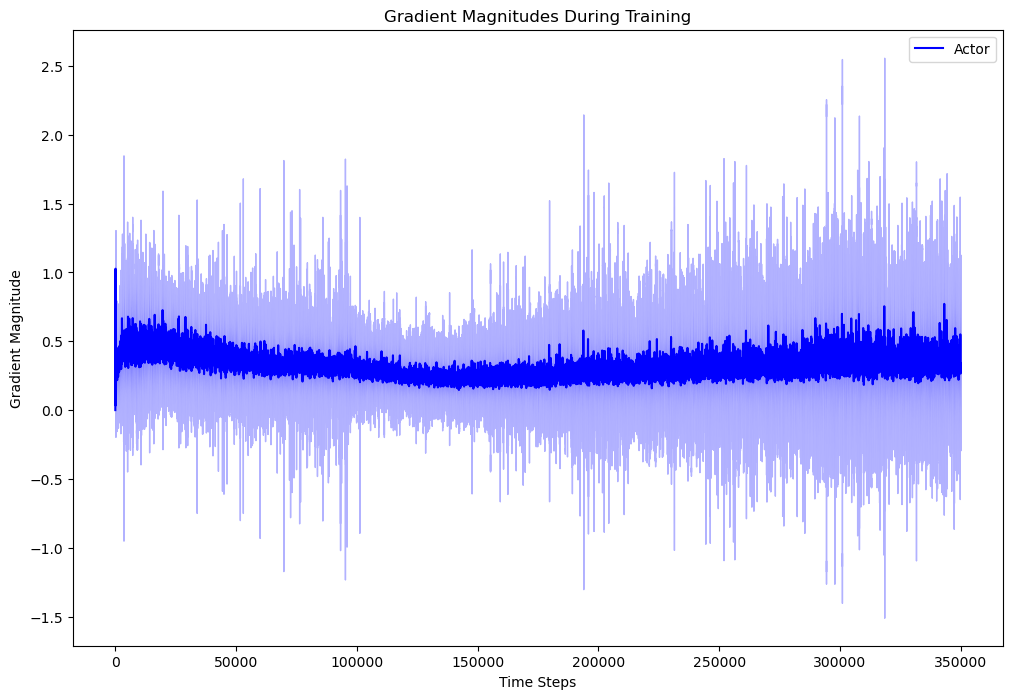

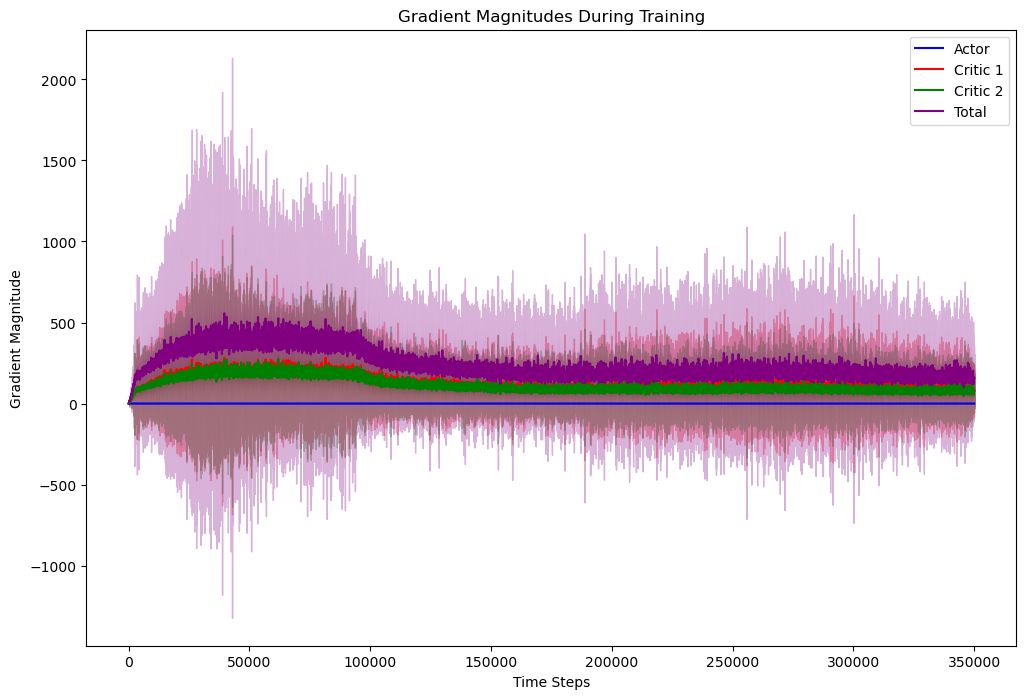

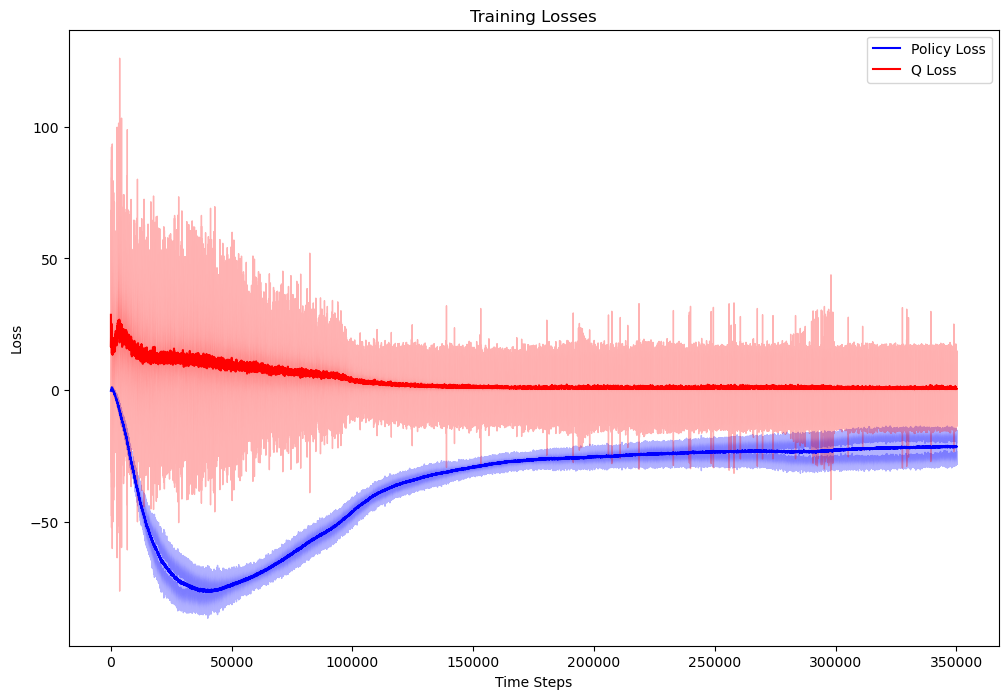

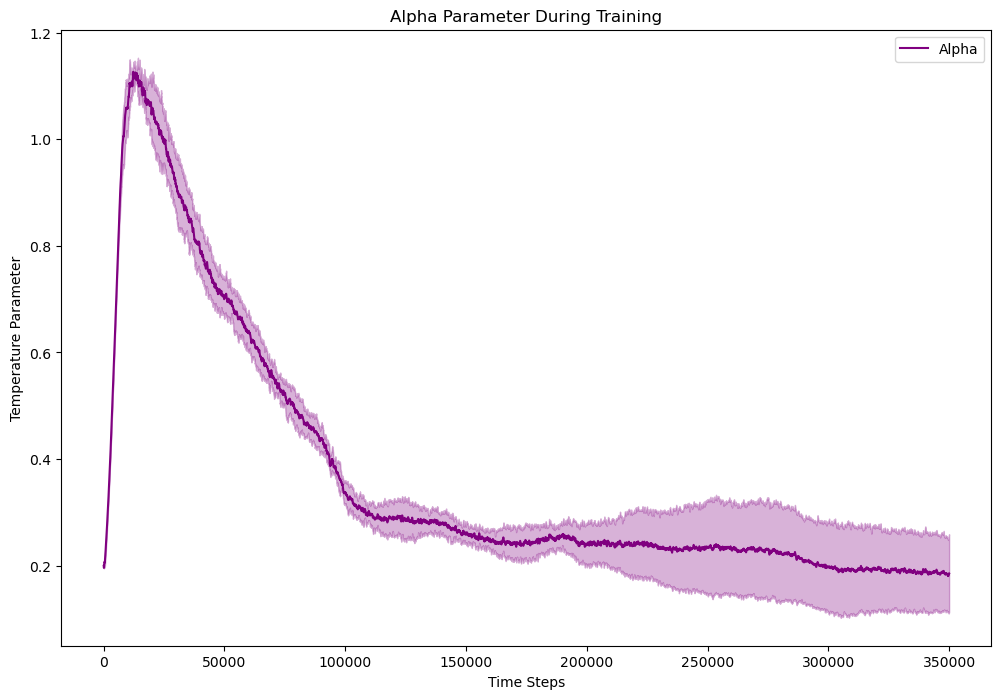

In [54]:
plot_training_metrics(all_grad_metrics, all_losses)

In [71]:
def plot_returns_metrics(returns_over_steps, discounted_returns, eval_returns_sum, eval_returns_discount):
    """
    Create separate plots for each metric using the existing plot_curves function.
    """
    plt.figure(figsize=(10, 6))
    min_len = min(len(trial) for trial in returns_over_steps)
    processed_returns = [trial[:min_len] for trial in returns_over_steps]
    plot_curves([np.array(processed_returns)], ['SAC'], ['r'],
                'Sum Return', 'Training Returns', smoothing=True, window=100)

    plt.figure(figsize=(10, 6))
    min_len = min(len(trial) for trial in discounted_returns)
    processed_disc = [trial[:min_len] for trial in discounted_returns]
    plot_curves([np.array(processed_disc)], ['SAC'], ['b'],
                'Discounted Return', 'Training Discounted Returns', smoothing=True, window=100)

    plt.figure(figsize=(10, 6))
    min_len = min(len(trial) for trial in eval_returns_sum)
    processed_eval = [trial[:min_len] for trial in eval_returns_sum]
    plot_curves([np.array(processed_eval)], ['SAC'], ['g'],
                'Sum Return', 'Evaluation Returns', smoothing=True, window=5)

    plt.figure(figsize=(10, 6))
    min_len = min(len(trial) for trial in eval_returns_discount)
    processed_eval_disc = [trial[:min_len] for trial in eval_returns_discount]
    plot_curves([np.array(processed_eval_disc)], ['SAC'], ['purple'],
                'Discounted Return', 'Evaluation Discounted Returns', smoothing=True, window=5)

<Figure size 1000x600 with 0 Axes>

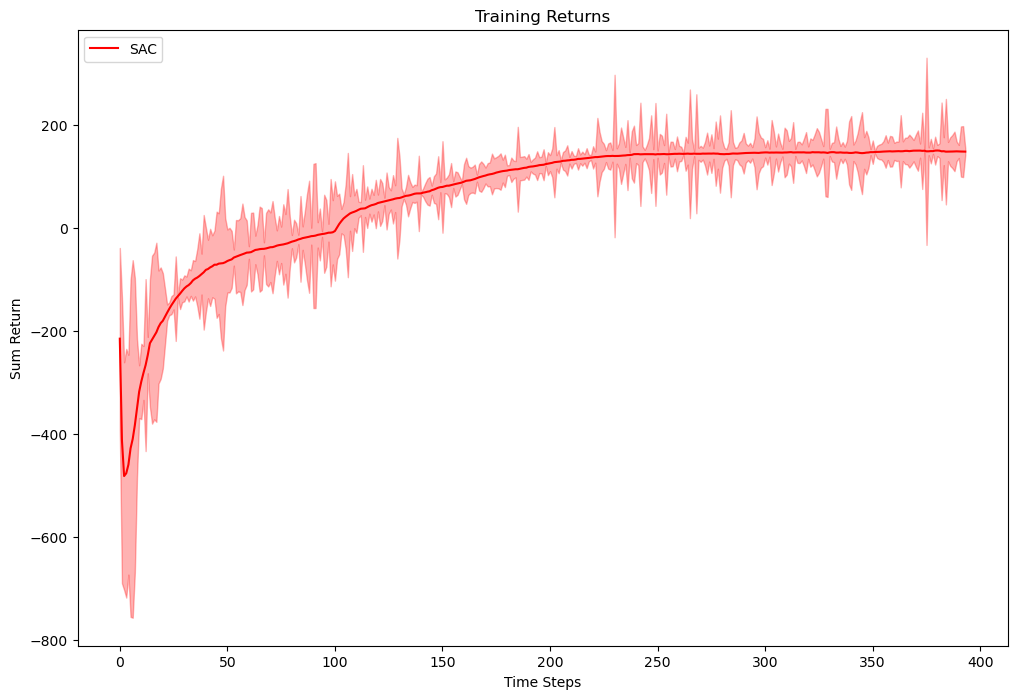

<Figure size 1000x600 with 0 Axes>

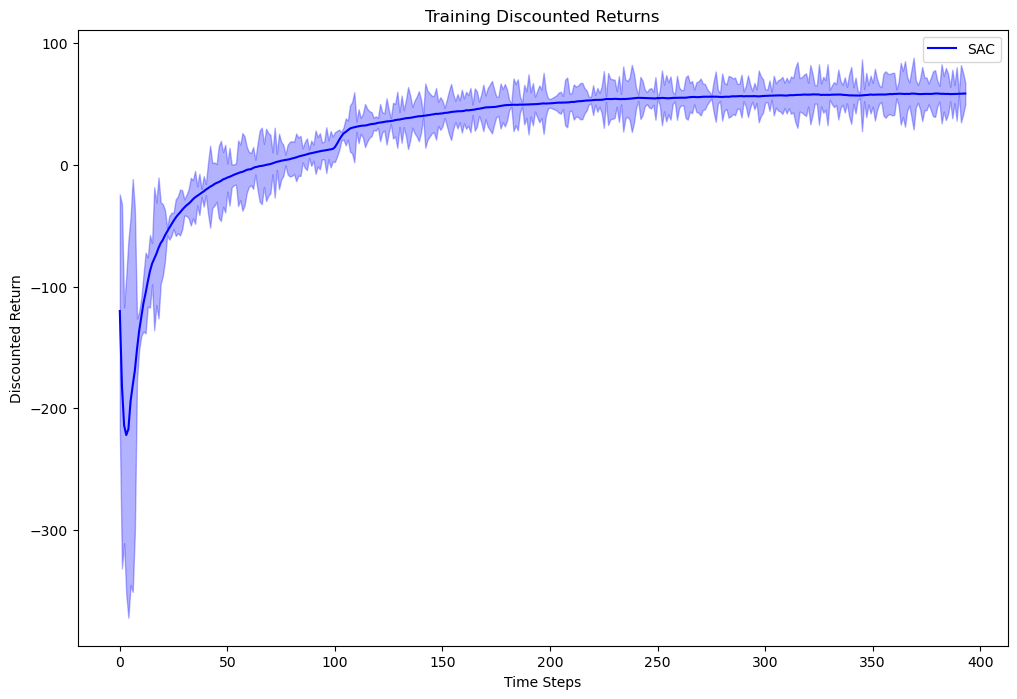

<Figure size 1000x600 with 0 Axes>

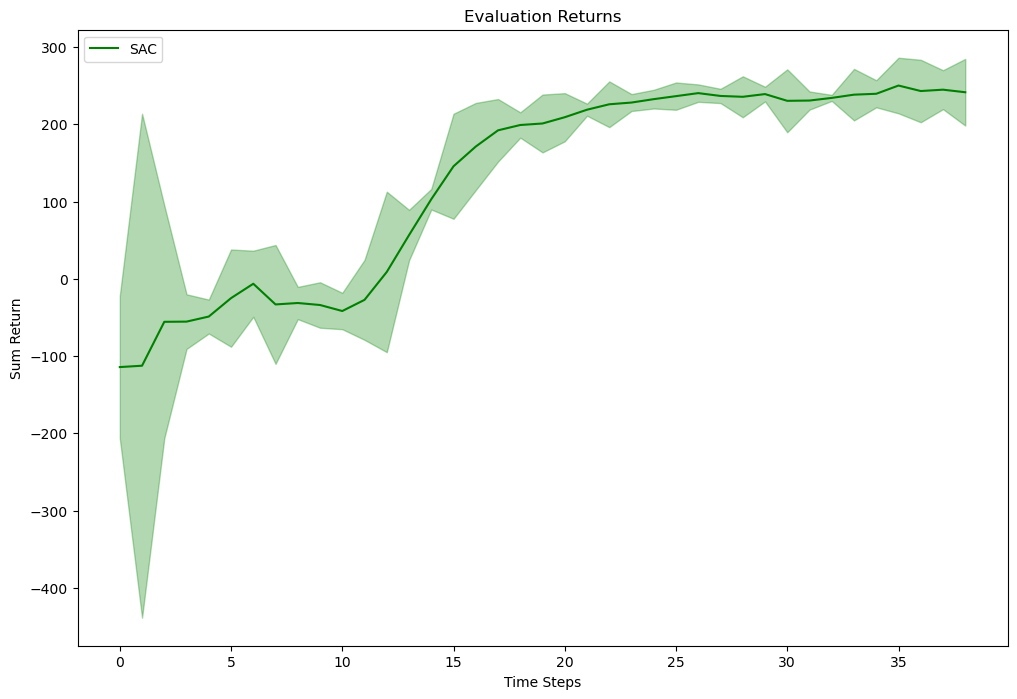

<Figure size 1000x600 with 0 Axes>

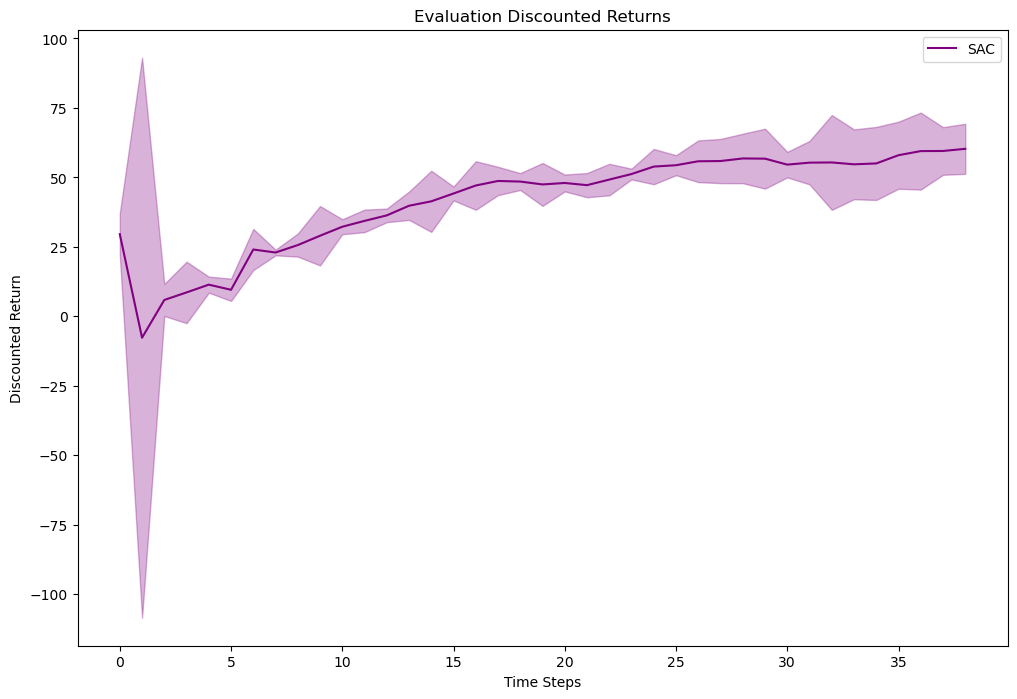

In [72]:
plot_returns_metrics(returns_over_steps, discounted_returns, eval_returns_sum, eval_returns_discount)

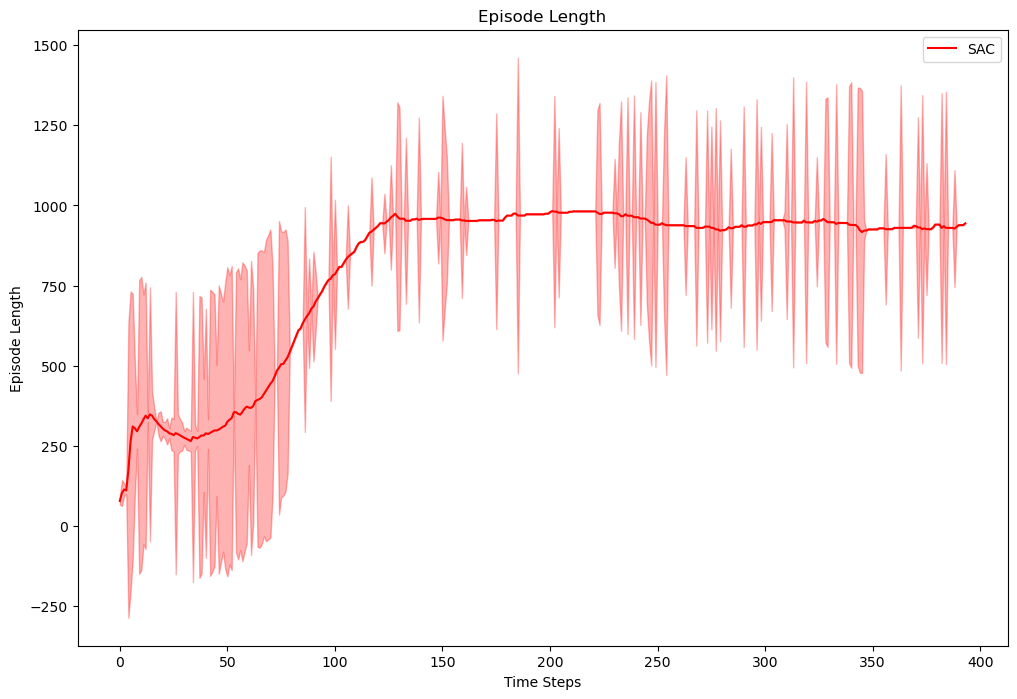

In [94]:
# find min length of episodes list 
min_length = min([len(episode) for episode in all_episode_lengths])
# truncate all episodes to min length
episode_lengths_ema = [episode[:min_length] for episode in all_episode_lengths]
# convert to numpy array
episode_lengths_arr = np.array(episode_lengths_ema)
# plot
plot_curves([episode_lengths_arr], ['SAC'], ['r'], 'Episode Length', 'Episode Length', smoothing = True)

In [93]:
from typing import Optional, Dict
# from grokfast paper - https://arxiv.org/abs/2405.20233
def gradfilter_ema(
    m: nn.Module,
    grads: Optional[Dict[str, torch.Tensor]] = None,
    alpha: float = 0.98,
    lamb: float = 2.0,
) -> Dict[str, torch.Tensor]:
    if grads is None:
        grads = {n: p.grad.data.detach() for n, p in m.named_parameters() if p.requires_grad and p.grad is not None}

    for n, p in m.named_parameters():
        if p.requires_grad and p.grad is not None:
            grads[n] = grads[n] * alpha + p.grad.data.detach() * (1 - alpha)
            p.grad.data = p.grad.data + grads[n] * lamb

    return grads

# we can apply this directly to the model before optimizer step simply by -
# in optimization loop

# loss.backwards()
# grads = gradfilter_ema(model, grads, alpha=alpha, lamb=lamb)
# optimizer.step()

In [ ]:
plot_comparison_metrics()


Trial 1/5


Ep:100 | R:-31.7 | AvgR:-63.7 | Succ:74.0% | Len:193.9 | α:0.259 | H:0.25:  10%|█         | 101/1000 [03:13<07:42,  1.94it/s]


Episode 100 Statistics:
Episode Return: -31.74
Average Return (100 ep): -63.68 ± 29.18
Success Rate (100 ep): 74.0%
Average Episode Length: 193.9
Evaluation Return: -54.60
Evaluation Success Rate: 100.0%
Average Q-Value: -13.52
Policy Entropy: 0.664
Alpha: 0.259
Policy Loss: 25.952
Q Loss: 2.041
--------------------------------------------------


Ep:200 | R:-32.4 | AvgR:-32.1 | Succ:100.0% | Len:41.9 | α:0.430 | H:0.66:  20%|██        | 201/1000 [04:07<06:23,  2.08it/s]


Episode 200 Statistics:
Episode Return: -32.43
Average Return (100 ep): -32.06 ± 12.63
Success Rate (100 ep): 100.0%
Average Episode Length: 41.9
Evaluation Return: -34.80
Evaluation Success Rate: 100.0%
Average Q-Value: -19.57
Policy Entropy: 0.485
Alpha: 0.430
Policy Loss: 21.947
Q Loss: 2.282
--------------------------------------------------


Ep:300 | R:-31.7 | AvgR:-30.2 | Succ:100.0% | Len:37.8 | α:0.579 | H:0.63:  30%|███       | 301/1000 [04:56<05:10,  2.25it/s]


Episode 300 Statistics:
Episode Return: -31.74
Average Return (100 ep): -30.18 ± 8.79
Success Rate (100 ep): 100.0%
Average Episode Length: 37.8
Evaluation Return: -24.00
Evaluation Success Rate: 100.0%
Average Q-Value: -16.59
Policy Entropy: 0.661
Alpha: 0.579
Policy Loss: 14.439
Q Loss: 1.111
--------------------------------------------------


Ep:400 | R:-25.3 | AvgR:-28.1 | Succ:100.0% | Len:34.1 | α:0.510 | H:0.67:  40%|████      | 401/1000 [05:41<04:09,  2.40it/s]


Episode 400 Statistics:
Episode Return: -25.28
Average Return (100 ep): -28.12 ± 5.39
Success Rate (100 ep): 100.0%
Average Episode Length: 34.1
Evaluation Return: -26.80
Evaluation Success Rate: 100.0%
Average Q-Value: -11.38
Policy Entropy: 0.728
Alpha: 0.510
Policy Loss: 10.469
Q Loss: 0.422
--------------------------------------------------


Ep:500 | R:-26.0 | AvgR:-26.5 | Succ:100.0% | Len:31.8 | α:0.433 | H:0.75:  50%|█████     | 501/1000 [06:24<03:28,  2.39it/s]


Episode 500 Statistics:
Episode Return: -26.03
Average Return (100 ep): -26.48 ± 4.22
Success Rate (100 ep): 100.0%
Average Episode Length: 31.8
Evaluation Return: -26.40
Evaluation Success Rate: 100.0%
Average Q-Value: -10.38
Policy Entropy: 0.711
Alpha: 0.433
Policy Loss: 10.398
Q Loss: 0.340
--------------------------------------------------


Ep:600 | R:-25.3 | AvgR:-26.8 | Succ:100.0% | Len:32.3 | α:0.429 | H:0.69:  60%|██████    | 601/1000 [07:07<03:02,  2.18it/s]


Episode 600 Statistics:
Episode Return: -25.28
Average Return (100 ep): -26.84 ± 4.95
Success Rate (100 ep): 100.0%
Average Episode Length: 32.3
Evaluation Return: -25.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.63
Policy Entropy: 0.701
Alpha: 0.429
Policy Loss: 10.468
Q Loss: 0.369
--------------------------------------------------


Ep:700 | R:-26.0 | AvgR:-26.9 | Succ:100.0% | Len:32.4 | α:0.421 | H:0.66:  70%|███████   | 701/1000 [07:50<02:02,  2.43it/s]


Episode 700 Statistics:
Episode Return: -26.03
Average Return (100 ep): -26.88 ± 4.85
Success Rate (100 ep): 100.0%
Average Episode Length: 32.4
Evaluation Return: -24.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.87
Policy Entropy: 0.701
Alpha: 0.421
Policy Loss: 10.631
Q Loss: 0.375
--------------------------------------------------


Ep:800 | R:-22.2 | AvgR:-26.9 | Succ:100.0% | Len:32.4 | α:0.412 | H:0.71:  80%|████████  | 801/1000 [08:34<01:55,  1.72it/s]


Episode 800 Statistics:
Episode Return: -22.22
Average Return (100 ep): -26.90 ± 4.19
Success Rate (100 ep): 100.0%
Average Episode Length: 32.4
Evaluation Return: -24.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.71
Policy Entropy: 0.693
Alpha: 0.412
Policy Loss: 10.687
Q Loss: 0.381
--------------------------------------------------


Ep:900 | R:-31.1 | AvgR:-26.5 | Succ:100.0% | Len:31.9 | α:0.427 | H:0.69:  90%|█████████ | 901/1000 [09:18<00:42,  2.33it/s]


Episode 900 Statistics:
Episode Return: -31.06
Average Return (100 ep): -26.52 ± 4.57
Success Rate (100 ep): 100.0%
Average Episode Length: 31.9
Evaluation Return: -24.60
Evaluation Success Rate: 100.0%
Average Q-Value: -10.86
Policy Entropy: 0.678
Alpha: 0.427
Policy Loss: 10.699
Q Loss: 0.370
--------------------------------------------------


Ep:999 | R:-33.8 | AvgR:-26.7 | Succ:100.0% | Len:32.1 | α:0.413 | H:0.79: 100%|██████████| 1000/1000 [09:59<00:00,  1.67it/s]


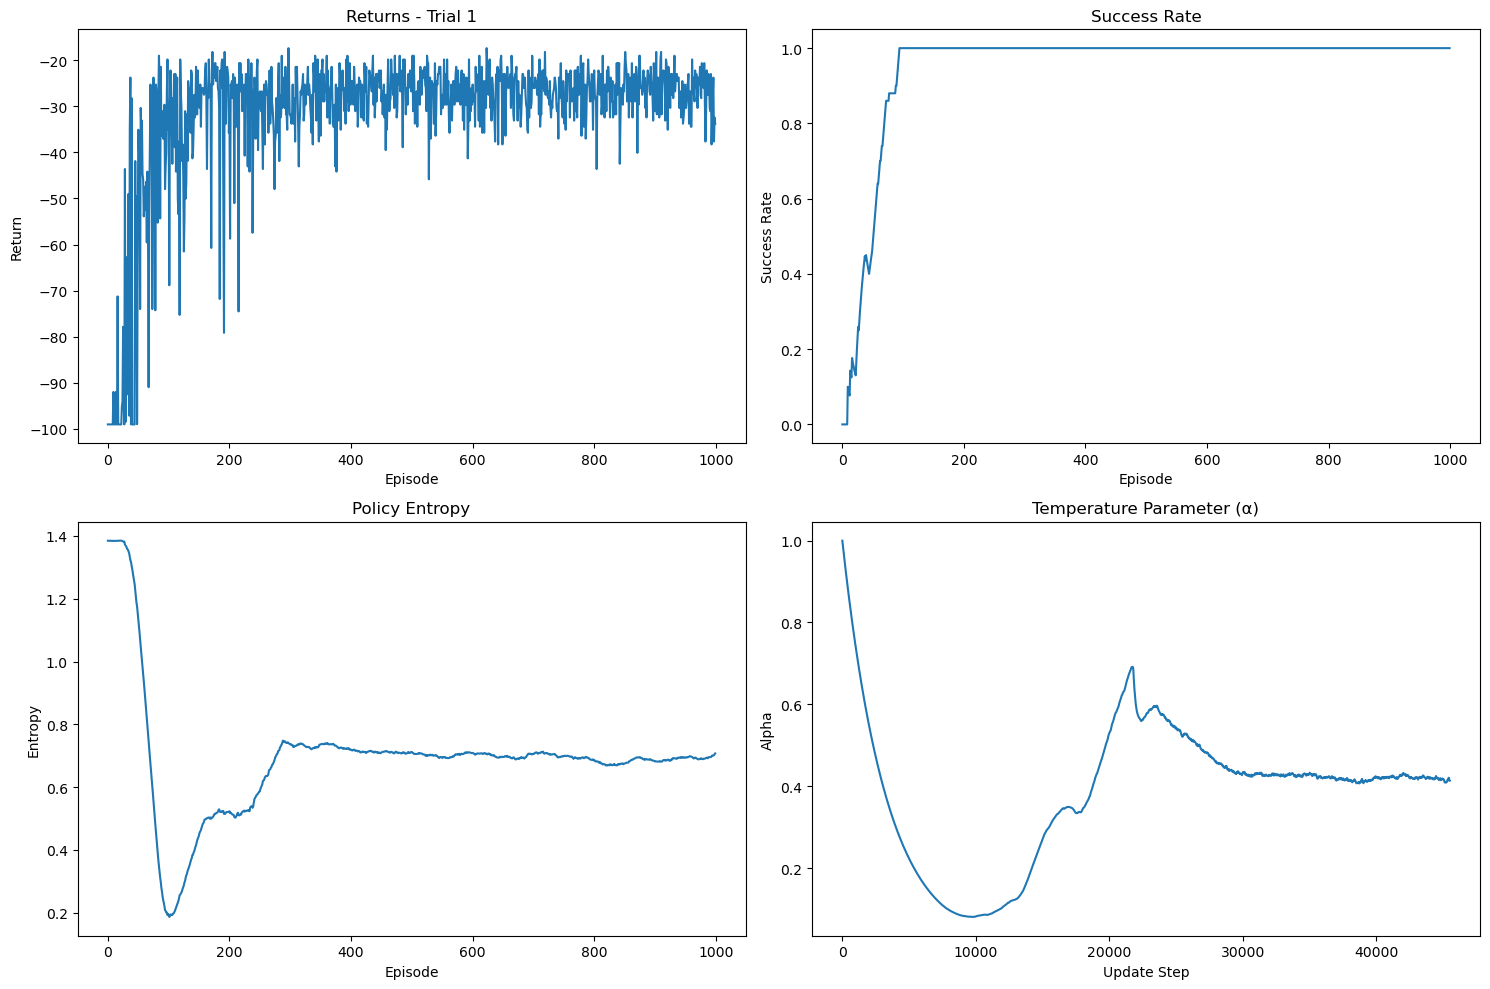


Trial 2/5


Ep:100 | R:-42.5 | AvgR:-67.2 | Succ:77.0% | Len:197.2 | α:0.180 | H:0.23:  10%|█         | 101/1000 [03:16<12:02,  1.25it/s]


Episode 100 Statistics:
Episode Return: -42.46
Average Return (100 ep): -67.18 ± 26.88
Success Rate (100 ep): 77.0%
Average Episode Length: 197.2
Evaluation Return: -48.20
Evaluation Success Rate: 100.0%
Average Q-Value: -15.91
Policy Entropy: 0.745
Alpha: 0.180
Policy Loss: 27.732
Q Loss: 1.965
--------------------------------------------------


Ep:200 | R:-37.0 | AvgR:-39.0 | Succ:100.0% | Len:55.0 | α:0.664 | H:0.79:  20%|██        | 201/1000 [04:27<06:45,  1.97it/s]


Episode 200 Statistics:
Episode Return: -37.02
Average Return (100 ep): -38.98 ± 15.67
Success Rate (100 ep): 100.0%
Average Episode Length: 55.0
Evaluation Return: -30.00
Evaluation Success Rate: 100.0%
Average Q-Value: -22.00
Policy Entropy: 0.507
Alpha: 0.664
Policy Loss: 23.645
Q Loss: 3.872
--------------------------------------------------


Ep:300 | R:-30.4 | AvgR:-31.2 | Succ:100.0% | Len:40.3 | α:0.608 | H:0.80:  30%|███       | 301/1000 [05:19<04:46,  2.44it/s]


Episode 300 Statistics:
Episode Return: -30.36
Average Return (100 ep): -31.25 ± 10.32
Success Rate (100 ep): 100.0%
Average Episode Length: 40.3
Evaluation Return: -20.20
Evaluation Success Rate: 100.0%
Average Q-Value: -15.16
Policy Entropy: 0.720
Alpha: 0.608
Policy Loss: 15.692
Q Loss: 1.759
--------------------------------------------------


Ep:400 | R:-20.6 | AvgR:-27.6 | Succ:100.0% | Len:33.3 | α:0.455 | H:0.57:  40%|████      | 401/1000 [06:01<04:14,  2.35it/s]


Episode 400 Statistics:
Episode Return: -20.64
Average Return (100 ep): -27.57 ± 5.06
Success Rate (100 ep): 100.0%
Average Episode Length: 33.3
Evaluation Return: -24.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.98
Policy Entropy: 0.705
Alpha: 0.455
Policy Loss: 11.474
Q Loss: 0.383
--------------------------------------------------


Ep:500 | R:-27.5 | AvgR:-26.4 | Succ:100.0% | Len:31.8 | α:0.438 | H:0.66:  50%|█████     | 501/1000 [06:43<03:19,  2.50it/s]


Episode 500 Statistics:
Episode Return: -27.50
Average Return (100 ep): -26.40 ± 5.50
Success Rate (100 ep): 100.0%
Average Episode Length: 31.8
Evaluation Return: -31.40
Evaluation Success Rate: 100.0%
Average Q-Value: -11.13
Policy Entropy: 0.696
Alpha: 0.438
Policy Loss: 11.155
Q Loss: 0.370
--------------------------------------------------


Ep:600 | R:-26.8 | AvgR:-26.3 | Succ:100.0% | Len:31.5 | α:0.443 | H:0.67:  60%|██████    | 601/1000 [07:24<02:27,  2.71it/s]


Episode 600 Statistics:
Episode Return: -26.77
Average Return (100 ep): -26.26 ± 4.70
Success Rate (100 ep): 100.0%
Average Episode Length: 31.5
Evaluation Return: -24.60
Evaluation Success Rate: 100.0%
Average Q-Value: -11.05
Policy Entropy: 0.696
Alpha: 0.443
Policy Loss: 10.618
Q Loss: 0.353
--------------------------------------------------


Ep:700 | R:-31.1 | AvgR:-26.3 | Succ:100.0% | Len:31.6 | α:0.425 | H:0.76:  70%|███████   | 701/1000 [08:04<01:58,  2.52it/s]


Episode 700 Statistics:
Episode Return: -31.06
Average Return (100 ep): -26.28 ± 4.81
Success Rate (100 ep): 100.0%
Average Episode Length: 31.6
Evaluation Return: -23.60
Evaluation Success Rate: 100.0%
Average Q-Value: -10.83
Policy Entropy: 0.704
Alpha: 0.425
Policy Loss: 10.611
Q Loss: 0.322
--------------------------------------------------


Ep:800 | R:-23.0 | AvgR:-26.7 | Succ:100.0% | Len:32.1 | α:0.418 | H:0.65:  80%|████████  | 801/1000 [08:45<01:10,  2.81it/s]


Episode 800 Statistics:
Episode Return: -23.00
Average Return (100 ep): -26.68 ± 4.62
Success Rate (100 ep): 100.0%
Average Episode Length: 32.1
Evaluation Return: -25.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.62
Policy Entropy: 0.696
Alpha: 0.418
Policy Loss: 10.608
Q Loss: 0.333
--------------------------------------------------


Ep:900 | R:-25.3 | AvgR:-26.8 | Succ:100.0% | Len:32.1 | α:0.420 | H:0.76:  90%|█████████ | 901/1000 [09:25<00:40,  2.43it/s]


Episode 900 Statistics:
Episode Return: -25.28
Average Return (100 ep): -26.75 ± 4.35
Success Rate (100 ep): 100.0%
Average Episode Length: 32.1
Evaluation Return: -26.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.83
Policy Entropy: 0.707
Alpha: 0.420
Policy Loss: 10.621
Q Loss: 0.329
--------------------------------------------------


Ep:999 | R:-28.9 | AvgR:-26.2 | Succ:100.0% | Len:31.4 | α:0.414 | H:0.82: 100%|██████████| 1000/1000 [10:04<00:00,  1.65it/s]


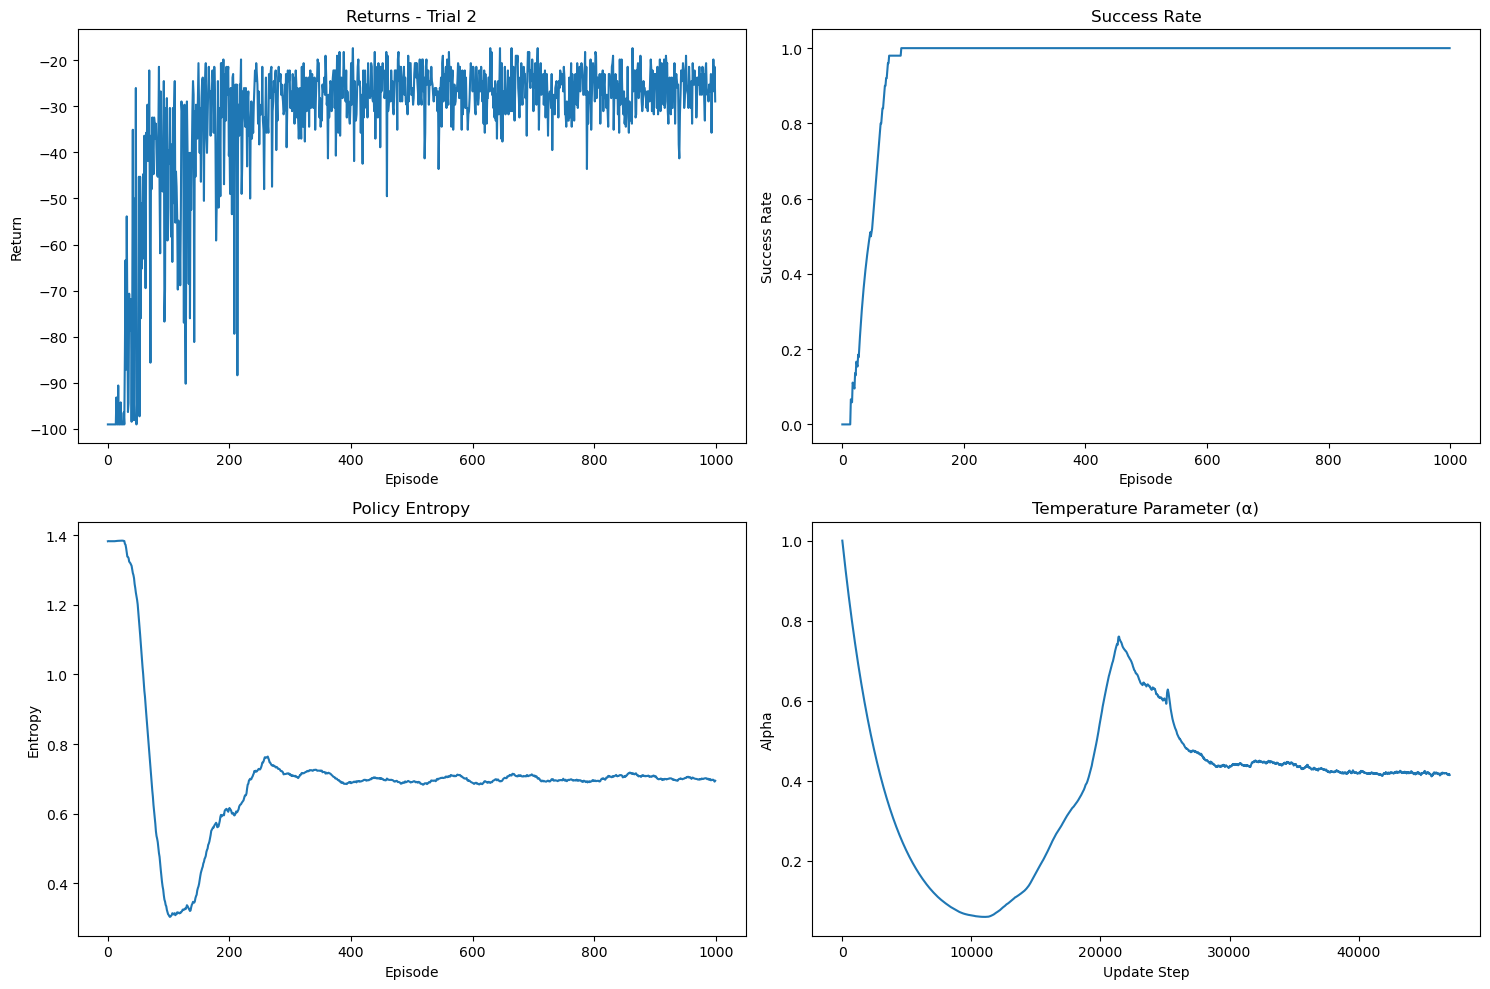


Trial 3/5


Ep:100 | R:-63.0 | AvgR:-69.5 | Succ:73.0% | Len:210.5 | α:0.114 | H:0.06:  10%|█         | 101/1000 [03:46<12:54,  1.16it/s]


Episode 100 Statistics:
Episode Return: -63.03
Average Return (100 ep): -69.53 ± 26.97
Success Rate (100 ep): 73.0%
Average Episode Length: 210.5
Evaluation Return: -68.80
Evaluation Success Rate: 100.0%
Average Q-Value: -18.82
Policy Entropy: 0.696
Alpha: 0.114
Policy Loss: 34.093
Q Loss: 2.861
--------------------------------------------------


Ep:200 | R:-28.2 | AvgR:-34.9 | Succ:100.0% | Len:46.3 | α:0.442 | H:0.43:  20%|██        | 201/1000 [04:48<06:00,  2.22it/s]


Episode 200 Statistics:
Episode Return: -28.23
Average Return (100 ep): -34.87 ± 13.10
Success Rate (100 ep): 100.0%
Average Episode Length: 46.3
Evaluation Return: -51.80
Evaluation Success Rate: 100.0%
Average Q-Value: -25.16
Policy Entropy: 0.221
Alpha: 0.442
Policy Loss: 28.621
Q Loss: 4.574
--------------------------------------------------


Ep:300 | R:-19.8 | AvgR:-31.3 | Succ:100.0% | Len:40.2 | α:0.779 | H:0.68:  30%|███       | 301/1000 [05:42<05:49,  2.00it/s]


Episode 300 Statistics:
Episode Return: -19.84
Average Return (100 ep): -31.27 ± 10.98
Success Rate (100 ep): 100.0%
Average Episode Length: 40.2
Evaluation Return: -40.60
Evaluation Success Rate: 100.0%
Average Q-Value: -21.61
Policy Entropy: 0.612
Alpha: 0.779
Policy Loss: 17.216
Q Loss: 1.710
--------------------------------------------------


Ep:400 | R:-19.8 | AvgR:-29.7 | Succ:100.0% | Len:36.6 | α:0.589 | H:0.60:  40%|████      | 401/1000 [06:32<04:28,  2.23it/s]


Episode 400 Statistics:
Episode Return: -19.84
Average Return (100 ep): -29.69 ± 6.90
Success Rate (100 ep): 100.0%
Average Episode Length: 36.6
Evaluation Return: -25.40
Evaluation Success Rate: 100.0%
Average Q-Value: -12.39
Policy Entropy: 0.705
Alpha: 0.589
Policy Loss: 10.174
Q Loss: 0.471
--------------------------------------------------


Ep:500 | R:-24.5 | AvgR:-26.3 | Succ:100.0% | Len:31.5 | α:0.423 | H:0.63:  50%|█████     | 501/1000 [07:16<03:13,  2.58it/s]


Episode 500 Statistics:
Episode Return: -24.53
Average Return (100 ep): -26.27 ± 4.60
Success Rate (100 ep): 100.0%
Average Episode Length: 31.5
Evaluation Return: -25.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.02
Policy Entropy: 0.680
Alpha: 0.423
Policy Loss: 10.464
Q Loss: 0.310
--------------------------------------------------


Ep:600 | R:-33.8 | AvgR:-26.8 | Succ:100.0% | Len:32.2 | α:0.453 | H:0.73:  60%|██████    | 601/1000 [07:59<03:05,  2.15it/s]


Episode 600 Statistics:
Episode Return: -33.77
Average Return (100 ep): -26.75 ± 4.90
Success Rate (100 ep): 100.0%
Average Episode Length: 32.2
Evaluation Return: -23.40
Evaluation Success Rate: 100.0%
Average Q-Value: -10.93
Policy Entropy: 0.702
Alpha: 0.453
Policy Loss: 10.705
Q Loss: 0.338
--------------------------------------------------


Ep:700 | R:-27.5 | AvgR:-26.4 | Succ:100.0% | Len:31.6 | α:0.451 | H:0.65:  70%|███████   | 701/1000 [08:43<02:09,  2.31it/s]


Episode 700 Statistics:
Episode Return: -27.50
Average Return (100 ep): -26.35 ± 3.91
Success Rate (100 ep): 100.0%
Average Episode Length: 31.6
Evaluation Return: -25.00
Evaluation Success Rate: 100.0%
Average Q-Value: -11.01
Policy Entropy: 0.708
Alpha: 0.451
Policy Loss: 10.683
Q Loss: 0.311
--------------------------------------------------


Ep:800 | R:-28.2 | AvgR:-27.5 | Succ:100.0% | Len:33.4 | α:0.436 | H:0.66:  80%|████████  | 801/1000 [09:30<01:31,  2.18it/s]


Episode 800 Statistics:
Episode Return: -28.23
Average Return (100 ep): -27.52 ± 5.92
Success Rate (100 ep): 100.0%
Average Episode Length: 33.4
Evaluation Return: -21.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.67
Policy Entropy: 0.691
Alpha: 0.436
Policy Loss: 10.726
Q Loss: 0.319
--------------------------------------------------


Ep:900 | R:-22.2 | AvgR:-26.0 | Succ:100.0% | Len:31.1 | α:0.435 | H:0.67:  90%|█████████ | 901/1000 [10:12<00:36,  2.69it/s]


Episode 900 Statistics:
Episode Return: -22.22
Average Return (100 ep): -26.01 ± 4.30
Success Rate (100 ep): 100.0%
Average Episode Length: 31.1
Evaluation Return: -24.40
Evaluation Success Rate: 100.0%
Average Q-Value: -10.64
Policy Entropy: 0.684
Alpha: 0.435
Policy Loss: 10.685
Q Loss: 0.317
--------------------------------------------------


Ep:999 | R:-23.0 | AvgR:-26.6 | Succ:100.0% | Len:32.0 | α:0.435 | H:0.78: 100%|██████████| 1000/1000 [10:55<00:00,  1.53it/s]


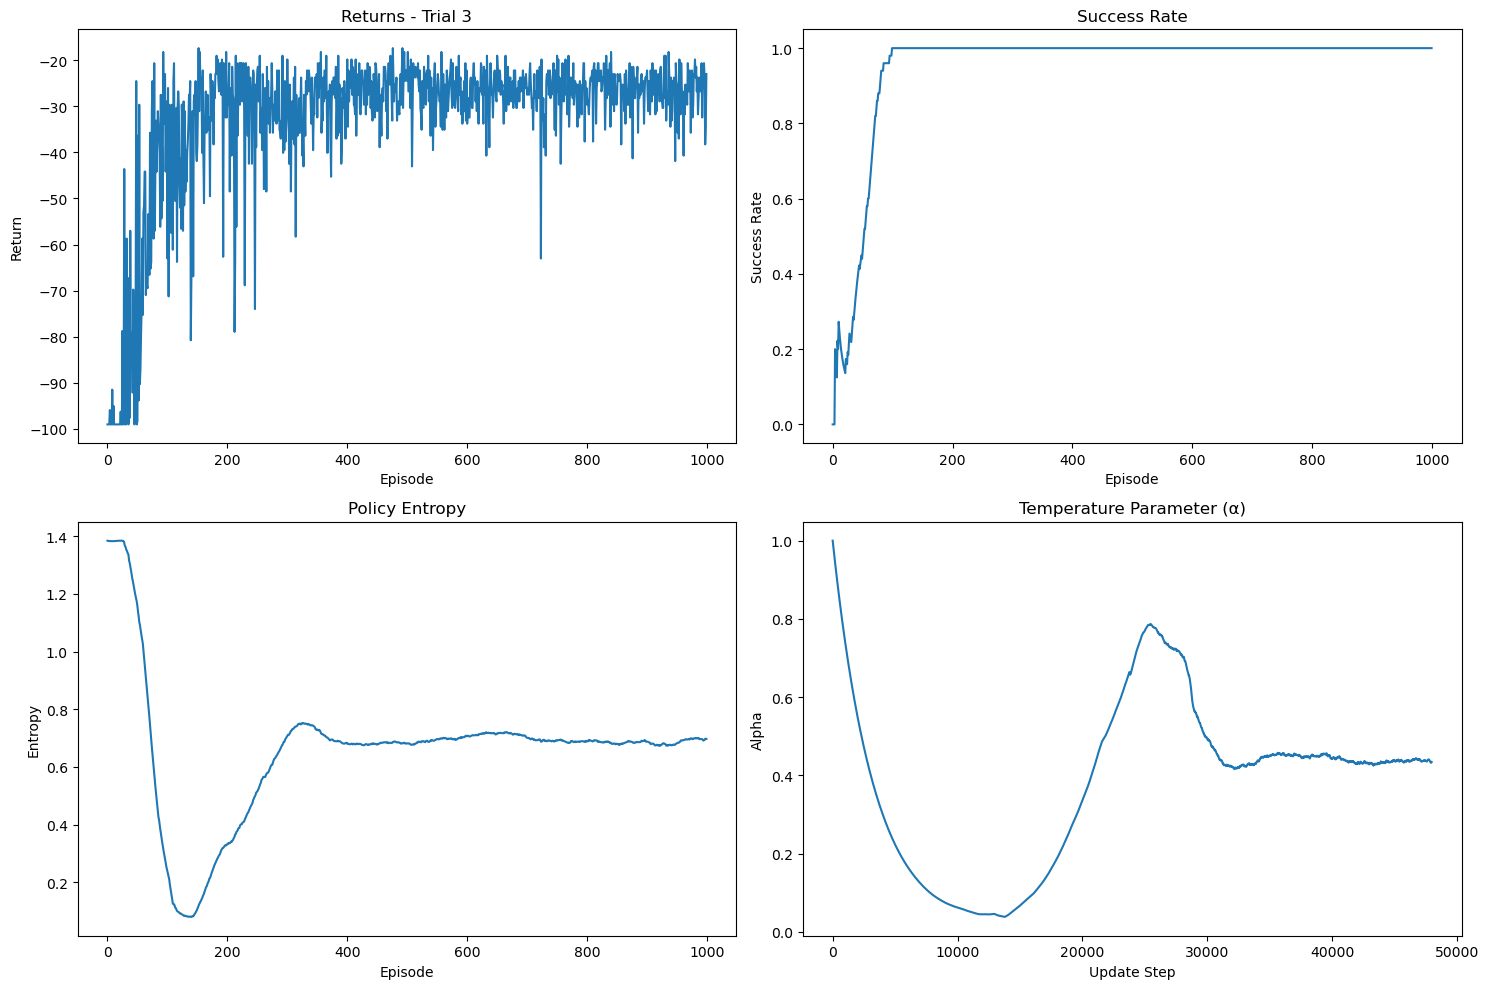


Trial 4/5


Ep:100 | R:-31.1 | AvgR:-63.7 | Succ:77.0% | Len:192.7 | α:0.146 | H:0.40:  10%|█         | 101/1000 [03:24<08:56,  1.67it/s]


Episode 100 Statistics:
Episode Return: -31.06
Average Return (100 ep): -63.70 ± 29.08
Success Rate (100 ep): 77.0%
Average Episode Length: 192.7
Evaluation Return: -45.80
Evaluation Success Rate: 100.0%
Average Q-Value: -15.24
Policy Entropy: 0.670
Alpha: 0.146
Policy Loss: 29.161
Q Loss: 2.438
--------------------------------------------------


Ep:200 | R:-23.0 | AvgR:-27.7 | Succ:100.0% | Len:34.2 | α:0.380 | H:0.32:  20%|██        | 201/1000 [04:11<05:28,  2.43it/s]


Episode 200 Statistics:
Episode Return: -23.00
Average Return (100 ep): -27.73 ± 8.84
Success Rate (100 ep): 100.0%
Average Episode Length: 34.2
Evaluation Return: -27.60
Evaluation Success Rate: 100.0%
Average Q-Value: -20.77
Policy Entropy: 0.322
Alpha: 0.380
Policy Loss: 25.069
Q Loss: 2.659
--------------------------------------------------


Ep:300 | R:-23.8 | AvgR:-29.1 | Succ:100.0% | Len:36.8 | α:0.610 | H:0.76:  30%|███       | 301/1000 [05:02<05:53,  1.98it/s]


Episode 300 Statistics:
Episode Return: -23.77
Average Return (100 ep): -29.08 ± 10.57
Success Rate (100 ep): 100.0%
Average Episode Length: 36.8
Evaluation Return: -26.80
Evaluation Success Rate: 100.0%
Average Q-Value: -14.11
Policy Entropy: 0.522
Alpha: 0.610
Policy Loss: 12.792
Q Loss: 1.093
--------------------------------------------------


Ep:400 | R:-28.2 | AvgR:-27.3 | Succ:100.0% | Len:33.0 | α:0.467 | H:0.69:  40%|████      | 401/1000 [05:47<04:11,  2.38it/s]


Episode 400 Statistics:
Episode Return: -28.23
Average Return (100 ep): -27.28 ± 5.23
Success Rate (100 ep): 100.0%
Average Episode Length: 33.0
Evaluation Return: -25.60
Evaluation Success Rate: 100.0%
Average Q-Value: -10.32
Policy Entropy: 0.723
Alpha: 0.467
Policy Loss: 10.119
Q Loss: 0.391
--------------------------------------------------


Ep:500 | R:-27.5 | AvgR:-26.6 | Succ:100.0% | Len:31.9 | α:0.438 | H:0.77:  50%|█████     | 501/1000 [06:29<03:28,  2.39it/s]


Episode 500 Statistics:
Episode Return: -27.50
Average Return (100 ep): -26.62 ± 3.70
Success Rate (100 ep): 100.0%
Average Episode Length: 31.9
Evaluation Return: -24.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.30
Policy Entropy: 0.710
Alpha: 0.438
Policy Loss: 9.965
Q Loss: 0.337
--------------------------------------------------


Ep:600 | R:-22.2 | AvgR:-27.1 | Succ:100.0% | Len:32.6 | α:0.429 | H:0.74:  60%|██████    | 601/1000 [07:11<02:30,  2.65it/s]


Episode 600 Statistics:
Episode Return: -22.22
Average Return (100 ep): -27.06 ± 4.65
Success Rate (100 ep): 100.0%
Average Episode Length: 32.6
Evaluation Return: -26.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.59
Policy Entropy: 0.703
Alpha: 0.429
Policy Loss: 10.171
Q Loss: 0.339
--------------------------------------------------


Ep:700 | R:-26.0 | AvgR:-27.4 | Succ:100.0% | Len:33.1 | α:0.430 | H:0.71:  70%|███████   | 701/1000 [07:54<02:17,  2.17it/s]


Episode 700 Statistics:
Episode Return: -26.03
Average Return (100 ep): -27.41 ± 4.64
Success Rate (100 ep): 100.0%
Average Episode Length: 33.1
Evaluation Return: -27.40
Evaluation Success Rate: 100.0%
Average Q-Value: -10.72
Policy Entropy: 0.706
Alpha: 0.430
Policy Loss: 10.477
Q Loss: 0.341
--------------------------------------------------


Ep:800 | R:-22.2 | AvgR:-26.2 | Succ:100.0% | Len:31.4 | α:0.425 | H:0.67:  80%|████████  | 801/1000 [08:36<01:21,  2.44it/s]


Episode 800 Statistics:
Episode Return: -22.22
Average Return (100 ep): -26.17 ± 4.67
Success Rate (100 ep): 100.0%
Average Episode Length: 31.4
Evaluation Return: -24.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.55
Policy Entropy: 0.696
Alpha: 0.425
Policy Loss: 10.513
Q Loss: 0.335
--------------------------------------------------


Ep:900 | R:-23.0 | AvgR:-26.9 | Succ:100.0% | Len:32.4 | α:0.422 | H:0.63:  90%|█████████ | 901/1000 [09:17<00:36,  2.69it/s]


Episode 900 Statistics:
Episode Return: -23.00
Average Return (100 ep): -26.90 ± 4.88
Success Rate (100 ep): 100.0%
Average Episode Length: 32.4
Evaluation Return: -25.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.51
Policy Entropy: 0.685
Alpha: 0.422
Policy Loss: 10.546
Q Loss: 0.333
--------------------------------------------------


Ep:999 | R:-28.2 | AvgR:-26.4 | Succ:100.0% | Len:31.7 | α:0.423 | H:0.66: 100%|██████████| 1000/1000 [09:59<00:00,  1.67it/s]


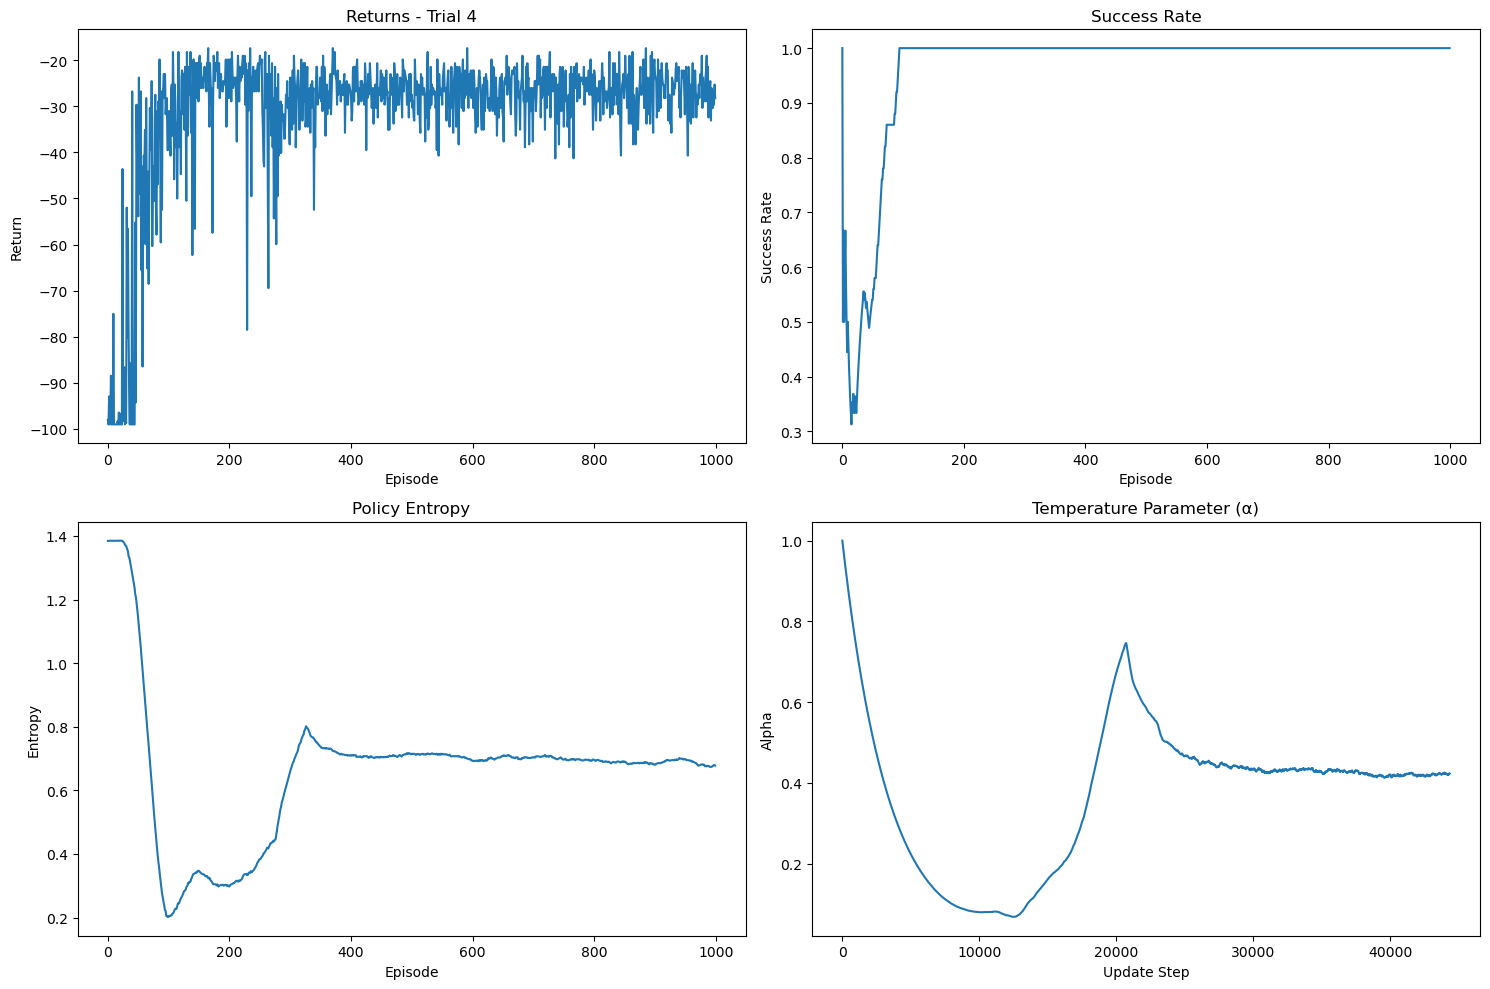


Trial 5/5


Ep:100 | R:-22.2 | AvgR:-62.8 | Succ:77.0% | Len:183.8 | α:0.126 | H:0.21:  10%|█         | 101/1000 [03:01<07:23,  2.03it/s]


Episode 100 Statistics:
Episode Return: -22.22
Average Return (100 ep): -62.82 ± 28.23
Success Rate (100 ep): 77.0%
Average Episode Length: 183.8
Evaluation Return: -57.80
Evaluation Success Rate: 100.0%
Average Q-Value: -14.44
Policy Entropy: 0.744
Alpha: 0.126
Policy Loss: 26.122
Q Loss: 1.649
--------------------------------------------------


Ep:200 | R:-21.4 | AvgR:-31.8 | Succ:100.0% | Len:41.4 | α:0.414 | H:0.39:  20%|██        | 201/1000 [03:53<04:44,  2.81it/s]


Episode 200 Statistics:
Episode Return: -21.43
Average Return (100 ep): -31.78 ± 12.30
Success Rate (100 ep): 100.0%
Average Episode Length: 41.4
Evaluation Return: -31.00
Evaluation Success Rate: 100.0%
Average Q-Value: -18.57
Policy Entropy: 0.305
Alpha: 0.414
Policy Loss: 22.961
Q Loss: 2.521
--------------------------------------------------


Ep:300 | R:-26.0 | AvgR:-27.4 | Succ:100.0% | Len:33.5 | α:0.587 | H:0.62:  30%|███       | 301/1000 [04:36<04:35,  2.54it/s]


Episode 300 Statistics:
Episode Return: -26.03
Average Return (100 ep): -27.38 ± 7.51
Success Rate (100 ep): 100.0%
Average Episode Length: 33.5
Evaluation Return: -23.80
Evaluation Success Rate: 100.0%
Average Q-Value: -15.52
Policy Entropy: 0.597
Alpha: 0.587
Policy Loss: 14.297
Q Loss: 1.045
--------------------------------------------------


Ep:400 | R:-33.1 | AvgR:-28.1 | Succ:100.0% | Len:34.1 | α:0.481 | H:0.72:  40%|████      | 401/1000 [05:20<04:33,  2.19it/s]


Episode 400 Statistics:
Episode Return: -33.10
Average Return (100 ep): -28.12 ± 5.22
Success Rate (100 ep): 100.0%
Average Episode Length: 34.1
Evaluation Return: -23.20
Evaluation Success Rate: 100.0%
Average Q-Value: -11.76
Policy Entropy: 0.712
Alpha: 0.481
Policy Loss: 10.799
Q Loss: 0.423
--------------------------------------------------


Ep:500 | R:-24.5 | AvgR:-27.1 | Succ:100.0% | Len:32.6 | α:0.424 | H:0.68:  50%|█████     | 501/1000 [06:01<03:25,  2.43it/s]


Episode 500 Statistics:
Episode Return: -24.53
Average Return (100 ep): -27.09 ± 4.54
Success Rate (100 ep): 100.0%
Average Episode Length: 32.6
Evaluation Return: -26.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.43
Policy Entropy: 0.697
Alpha: 0.424
Policy Loss: 10.540
Q Loss: 0.339
--------------------------------------------------


Ep:600 | R:-28.9 | AvgR:-26.5 | Succ:100.0% | Len:32.7 | α:0.418 | H:0.60:  60%|██████    | 601/1000 [06:44<03:13,  2.06it/s]


Episode 600 Statistics:
Episode Return: -28.94
Average Return (100 ep): -26.51 ± 7.40
Success Rate (100 ep): 100.0%
Average Episode Length: 32.7
Evaluation Return: -22.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.51
Policy Entropy: 0.678
Alpha: 0.418
Policy Loss: 10.611
Q Loss: 0.338
--------------------------------------------------


Ep:700 | R:-23.0 | AvgR:-25.7 | Succ:100.0% | Len:30.7 | α:0.421 | H:0.66:  70%|███████   | 701/1000 [07:26<02:04,  2.39it/s]


Episode 700 Statistics:
Episode Return: -23.00
Average Return (100 ep): -25.66 ± 4.41
Success Rate (100 ep): 100.0%
Average Episode Length: 30.7
Evaluation Return: -25.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.61
Policy Entropy: 0.683
Alpha: 0.421
Policy Loss: 10.478
Q Loss: 0.337
--------------------------------------------------


Ep:800 | R:-27.5 | AvgR:-26.1 | Succ:100.0% | Len:31.2 | α:0.411 | H:0.74:  80%|████████  | 801/1000 [08:09<01:24,  2.34it/s]


Episode 800 Statistics:
Episode Return: -27.50
Average Return (100 ep): -26.10 ± 4.15
Success Rate (100 ep): 100.0%
Average Episode Length: 31.2
Evaluation Return: -23.60
Evaluation Success Rate: 100.0%
Average Q-Value: -10.58
Policy Entropy: 0.694
Alpha: 0.411
Policy Loss: 10.508
Q Loss: 0.321
--------------------------------------------------


Ep:900 | R:-24.5 | AvgR:-26.6 | Succ:100.0% | Len:32.0 | α:0.405 | H:0.62:  90%|█████████ | 901/1000 [08:53<00:40,  2.47it/s]


Episode 900 Statistics:
Episode Return: -24.53
Average Return (100 ep): -26.62 ± 4.47
Success Rate (100 ep): 100.0%
Average Episode Length: 32.0
Evaluation Return: -25.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.72
Policy Entropy: 0.696
Alpha: 0.405
Policy Loss: 10.575
Q Loss: 0.350
--------------------------------------------------


Ep:999 | R:-22.2 | AvgR:-26.3 | Succ:100.0% | Len:31.5 | α:0.408 | H:0.66: 100%|██████████| 1000/1000 [09:34<00:00,  1.74it/s]


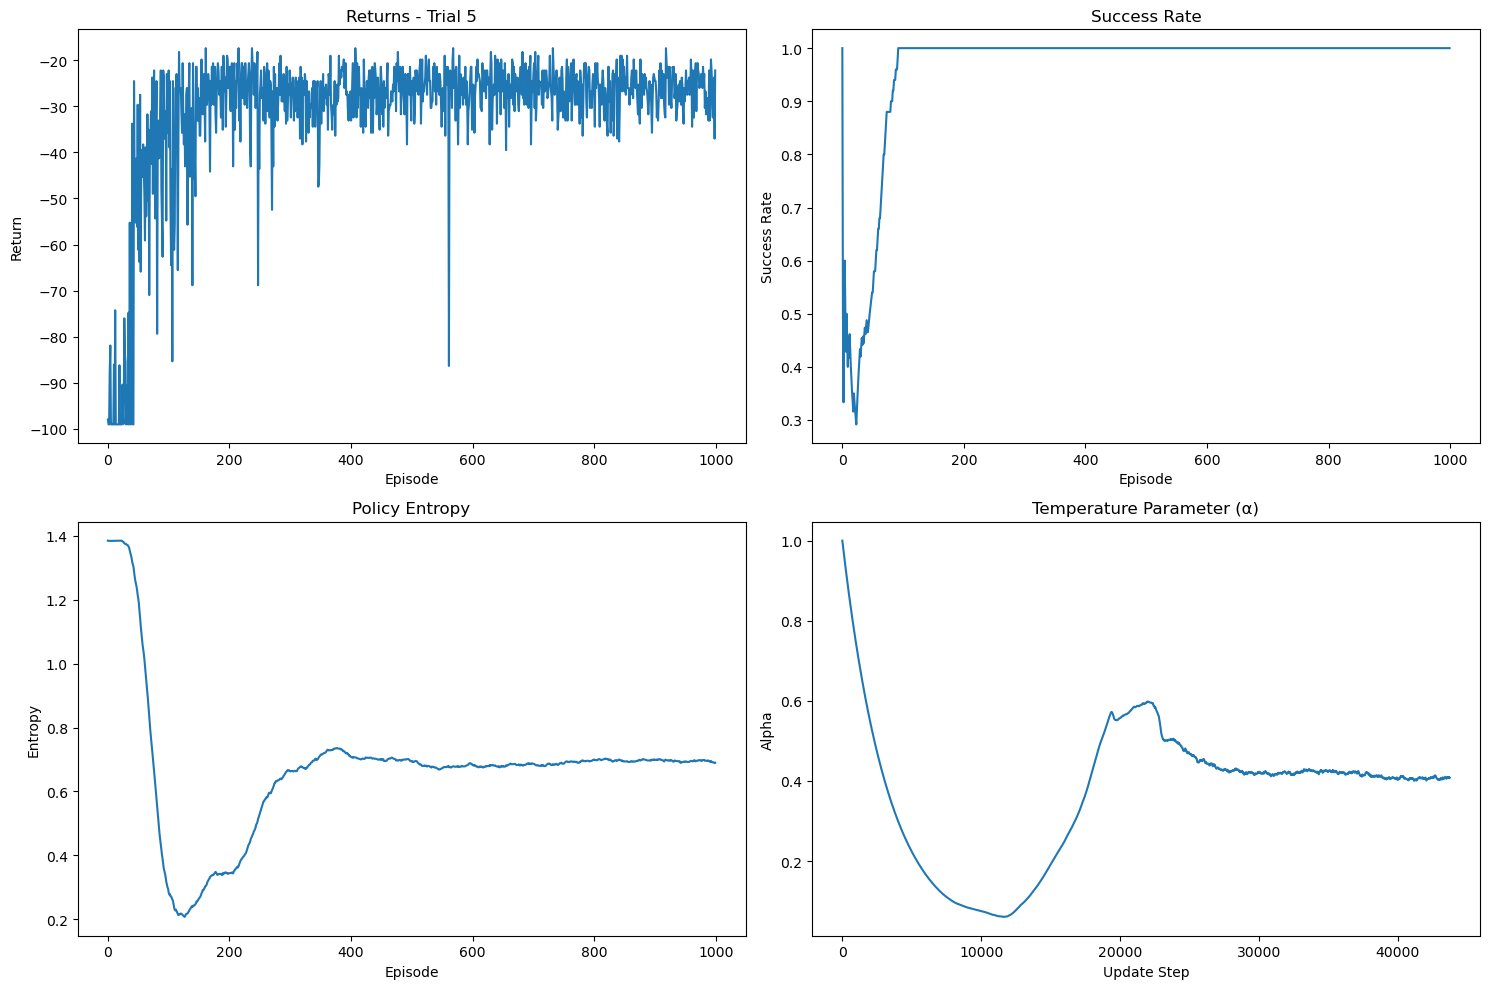

In [124]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
from collections import namedtuple, deque
import tqdm
import matplotlib.pyplot as plt

# Replay buffer transition tuple
Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    def __init__(self, capacity, state_dim=3, device="cpu"):
        self.capacity = capacity
        self.device = device
        self.memory = []
        self.position = 0
        
    def push(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).to(self.device)
        action = torch.tensor([action], dtype=torch.long).to(self.device)
        reward = torch.tensor([reward], dtype=torch.float32).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.tensor([done], dtype=torch.float32).to(self.device)
        
        transition = Transition(state, action, reward, next_state, done)
        
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        indices = np.random.choice(len(self.memory), batch_size)
        transitions = [self.memory[idx] for idx in indices]
        batch = Transition(*zip(*transitions))
        
        states = torch.stack(batch.state)
        actions = torch.stack(batch.action)
        rewards = torch.stack(batch.reward)
        next_states = torch.stack(batch.next_state)
        dones = torch.stack(batch.done)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
    def forward(self, state):
        return self.net(state)

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, state):
        return self.net(state)

class SACAgent:
    def __init__(self, state_dim=3, action_dim=4, hidden_dim=256,
                 lr=3e-4, gamma=0.99, tau=0.005,
                 batch_size=256, device="cpu"):
        self.gamma = gamma
        self.tau = tau
        self.device = device
        self.batch_size = batch_size
        self.action_dim = action_dim
        
        # Networks
        self.critic1 = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.critic2 = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.critic1_target = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.critic2_target = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.actor = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)
        
        # Copy target parameters
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        
        # Optimizers with eps like reference
        self.critic1_optimizer = torch.optim.Adam(self.critic1.parameters(), lr=lr, eps=1e-4)
        self.critic2_optimizer = torch.optim.Adam(self.critic2.parameters(), lr=lr, eps=1e-4)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr, eps=1e-4)
        
        # Entropy tuning matching reference
        self.target_entropy = -np.log((1.0 / action_dim)) * 0.5 
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=lr, eps=1e-4)
        
    @property
    def alpha(self):
        return self.log_alpha.exp()
    
    def get_action(self, state, evaluate=False):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            action_probs = self.actor(state)
            if evaluate:
                action = torch.argmax(action_probs, dim=-1)
            else:
                dist = Categorical(action_probs)
                action = dist.sample()
            return action.item()
    
    def calculate_critic_losses(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        with torch.no_grad():
            next_action_probs = self.actor(next_state_batch)
            # Handle zero probabilities exactly like reference
            z = next_action_probs == 0.0
            z = z.float() * 1e-8
            log_next_action_probs = torch.log(next_action_probs + z)
            
            next_q1 = self.critic1_target(next_state_batch)
            next_q2 = self.critic2_target(next_state_batch)
            
            # Matching reference implementation exactly
            min_qf_next_target = next_action_probs * (
                torch.min(next_q1, next_q2) - self.alpha * log_next_action_probs
            )
            min_qf_next_target = min_qf_next_target.sum(dim=1).unsqueeze(-1)
            next_q_value = reward_batch + (1 - done_batch) * self.gamma * min_qf_next_target

        q1 = self.critic1(state_batch).gather(1, action_batch.long())
        q2 = self.critic2(state_batch).gather(1, action_batch.long())
        
        critic1_loss = F.mse_loss(q1, next_q_value)
        critic2_loss = F.mse_loss(q2, next_q_value)
        
        return critic1_loss, critic2_loss

    def calculate_actor_loss(self, state_batch):
        action_probs = self.actor(state_batch)
        # Handle zero probabilities
        z = action_probs == 0.0
        z = z.float() * 1e-8
        log_action_probs = torch.log(action_probs + z)
        
        q1 = self.critic1(state_batch)
        q2 = self.critic2(state_batch)
        min_q = torch.min(q1, q2).detach()
        
        # Matching reference implementation
        inside_term = self.alpha * log_action_probs - min_q
        policy_loss = (action_probs * inside_term).sum(dim=1).mean()
        log_action_probs = torch.sum(log_action_probs * action_probs, dim=1)
        
        return policy_loss, log_action_probs
# Four Rooms SAC Update Method with EMA
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch, total_steps, freq_update_target, actor_grads, critic_1_grads, critic_2_grads):
        """SAC update with EMA gradient tracking for Four Rooms"""
        # Critic update
        critic1_loss, critic2_loss = self.calculate_critic_losses(
            state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        critic_1_grads = gradfilter_ema(self.critic1, critic_1_grads, alpha=0.98, lamb=2.0)
        self.critic1_optimizer.step()
        
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        critic_2_grads = gradfilter_ema(self.critic2, critic_2_grads, alpha=0.98, lamb=2.0)
        self.critic2_optimizer.step()
        
        # Actor update
        policy_loss, log_probs = self.calculate_actor_loss(state_batch)
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        actor_grads = gradfilter_ema(self.actor, actor_grads, alpha=0.98, lamb=2.0)
        self.actor_optimizer.step()
        
        # Track EMA gradients
        grad_stats = track_ema_grad_stats(actor_grads, critic_1_grads, critic_2_grads)
        
        # Alpha update 
        alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        # Target update
        if total_steps % freq_update_target == 0:
            for target_param, param in zip(self.critic1_target.parameters(), self.critic1.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
            for target_param, param in zip(self.critic2_target.parameters(), self.critic2.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
        
        return actor_grads, critic_1_grads, critic_2_grads, grad_stats, {
            'critic1_loss': critic1_loss.item(),
            'critic2_loss': critic2_loss.item(),
            'policy_loss': policy_loss.item(),
            'alpha': self.alpha.item()
        }

def evaluate_policy(env, agent, num_episodes=5):
    """Runs policy evaluation episodes."""
    eval_returns = []
    eval_successes = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        state_features = [state[0] / 10.0, state[1] / 10.0, 1.0]
        episode_return = 0
        done = False
        reached_goal = False

        while not done:
            action = agent.get_action(state_features, evaluate=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                reached_goal = True

            episode_return += reward
            state = next_state
            state_features = [state[0] / 10.0, state[1] / 10.0, 1.0]

        eval_returns.append(episode_return)
        eval_successes.append(float(reached_goal))

    # Return all evaluation returns and successes for further processing
    return np.array(eval_returns), np.array(eval_successes)

def train_sac_trials(num_trials=10, num_episodes=10000, smoothing=True):
    """Run multiple trials with detailed logging"""
    all_returns = []
    all_losses = []
    eval_returns_array = np.zeros((num_trials, num_episodes // 100 + 1, 5))  # Store all episodes
    eval_success_array = np.zeros((num_trials, num_episodes // 100 + 1, 5))  # Store all episode
    all_grad_metrics = []
    
    training_params = {
        'num_episodes': num_episodes,
        'batch_size': 256,
        'buffer_size': 10_000,
        'learning_rate': 3e-4,
        'hidden_dim': 256,
        'gamma': 0.99,
        'tau': 0.005,
        'min_steps_before_learning': 5000,
        "freq_update_target": 1,
        "updates_per_step": 1, 
        "steps_per_update": 1
    }
    
    for trial in range(num_trials):
        print(f"\nTrial {trial + 1}/{num_trials}")
        
        # Set seeds
        torch.manual_seed(trial)
        np.random.seed(trial)
        
        env = FourRooms()
        eval_env = FourRooms()
        agent = SACAgent()
        buffer = ReplayBuffer(training_params['buffer_size'])
        
        # Training metrics
        trial_returns = []
        episode_lengths = []
        q_values = []
        entropies = []
        alphas = []
        policy_losses = []
        q_losses = []
        success_rate = []
        # EMA grads need to persist across episodes
        actor_grads = None
        critic_1_grads = None
        critic_2_grads = None
        grad_metrics = {
            'actor_grad_mag': [],
            'critic1_grad_mag': [],
            'critic2_grad_mag': [],
            'total_grad_mag': []
        }
        total_steps = 0
        pbar = tqdm.trange(training_params['num_episodes'])
        
        for episode in pbar:
            state, _ = env.reset()
            episode_rewards = []
            episode_length = 0
            episode_q_values = []
            episode_entropies = []
            
            done = False
            reached_goal = False
            
            while not done:
                # Get state features and action
                state_features = [state[0]/10.0, state[1]/10.0, 1.0]
                state_tensor = torch.FloatTensor(state_features).unsqueeze(0).to(agent.device)
                
                # Get action and log metrics
                with torch.no_grad():
                    probs = agent.actor(state_tensor)
                    q1 = agent.critic1(state_tensor)
                    q2 = agent.critic2(state_tensor)
                    episode_q_values.append(torch.max(torch.min(q1, q2)).item())
                    entropy = -(probs * torch.log(probs + 1e-8)).sum(1).item()
                    episode_entropies.append(entropy)
                
                action = agent.get_action(state_features)
                
                # Environment step
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                if terminated:
                    reached_goal = True
                
                next_state_features = [next_state[0]/10.0, next_state[1]/10.0, 1.0]
                
                # Store transition
                buffer.push(state_features, action, reward, next_state_features, done)
                
                # Update if enough samples
                if total_steps > training_params['min_steps_before_learning'] and len(buffer) >= training_params['batch_size'] and total_steps % training_params['steps_per_update'] == 0:
                    for _ in range(training_params["updates_per_step"]):
                        batch = buffer.sample(training_params['batch_size'])
                        actor_grads, critic_1_grads, critic_2_grads, grad_stats, loss_dict = agent.update(
                            *batch, total_steps, training_params["freq_update_target"],
                            actor_grads, critic_1_grads, critic_2_grads
                        )
                                                
                        for key, value in grad_stats.items():
                            grad_metrics[key].append(value)
                        # print grad metrics
                        # print(f"Actor Grad: {sum(torch.norm(g) for g in actor_grads.values()):.3f}, "
                        # f"Critic 1 Grad: {sum(torch.norm(g) for g in critic_1_grads.values()):.3f}, "
                        # f"Critic 2 Grad: {sum(torch.norm(g) for g in critic_2_grads.values()):.3f}")

                        policy_losses.append(loss_dict['policy_loss'])
                        q_losses.append((loss_dict['critic1_loss'] + loss_dict['critic2_loss']) / 2)
                        alphas.append(loss_dict['alpha'])
                        
                episode_rewards.append(reward)
                episode_length += 1
                total_steps += 1
                state = next_state
            
            # Compute total discounted return for the episode
            G = 0
            for r in reversed(episode_rewards):
                G = r + training_params['gamma'] * G
            episode_return = G  # Total discounted return for the episode
            
            # Store the episode return
            trial_returns.append(episode_return)
            episode_lengths.append(episode_length)
            success_rate.append(float(reached_goal))
            
            if episode_q_values:
                q_values.append(np.mean(episode_q_values))
            if episode_entropies:
                entropies.append(np.mean(episode_entropies))
            
            # Update progress bar with per-episode return
            current_return = trial_returns[-1]
            avg_return = np.mean(trial_returns[-100:]) if len(trial_returns) >= 100 else np.mean(trial_returns)
            avg_success = np.mean(success_rate[-100:]) * 100 if len(success_rate) >= 100 else np.mean(success_rate) * 100
            avg_length = np.mean(episode_lengths[-100:]) if len(episode_lengths) >= 100 else np.mean(episode_lengths)
            
            current_alpha = alphas[-1] if alphas else 0
            current_entropy = entropies[-1] if entropies else 0
            
            desc = f"Ep:{episode} | R:{current_return:.1f} | AvgR:{avg_return:.1f} | Succ:{avg_success:.1f}% | Len:{avg_length:.1f}"
            if alphas:
                desc += f" | α:{current_alpha:.3f}"
            if entropies:
                desc += f" | H:{current_entropy:.2f}"
            
            pbar.set_description(desc)
            
            # Periodically print detailed stats
            if episode % 100 == 0 and episode > 0:
                eval_returns, eval_successes = evaluate_policy(eval_env, agent)
                # Store raw evaluation returns and successes
                eval_idx = episode // 100
                eval_returns_array[trial, eval_idx] = eval_returns
                eval_success_array[trial, eval_idx] = eval_successes
                stats = f"\nEpisode {episode} Statistics:"
                stats += f"\nEpisode Return: {current_return:.2f}"
                stats += f"\nAverage Return (100 ep): {np.mean(trial_returns[-100:]):.2f} ± {np.std(trial_returns[-100:]):.2f}"
                stats += f"\nSuccess Rate (100 ep): {np.mean(success_rate[-100:]) * 100:.1f}%"
                stats += f"\nAverage Episode Length: {np.mean(episode_lengths[-100:]):.1f}"
                # add evaluation stats
                stats += f"\nEvaluation Return: {np.mean(eval_returns):.2f}"
                stats += f"\nEvaluation Success Rate: {(np.mean(eval_successes)*100):.1f}%"
                if q_values:
                    stats += f"\nAverage Q-Value: {np.mean(q_values[-100:]):.2f}"
                if entropies:
                    stats += f"\nPolicy Entropy: {np.mean(entropies[-100:]):.3f}"
                if alphas:
                    stats += f"\nAlpha: {alphas[-1]:.3f}"
                if policy_losses:
                    stats += f"\nPolicy Loss: {np.mean(policy_losses[-100:]):.3f}"
                if q_losses:
                    stats += f"\nQ Loss: {np.mean(q_losses[-100:]):.3f}"
                stats += "\n" + "-" * 50
                pbar.write(stats)
        
        # Store trial results
        all_returns.append(trial_returns)

        # Store gradient metrics
        all_grad_metrics.append(grad_metrics)

        # store losses
        all_losses.append({
            'policy_loss': policy_losses,
            'q_loss': q_losses,
            'alpha': alphas
        })

        
        if len(trial_returns) > 0:
            plt.figure(figsize=(15, 10))
            
            # Plot returns
            plt.subplot(2, 2, 1)
            plt.plot(trial_returns)
            plt.title(f'Returns - Trial {trial+1}')
            plt.xlabel('Episode')
            plt.ylabel('Return')
            
            # Plot success rate
            plt.subplot(2, 2, 2)
            plt.plot(moving_average(np.array(success_rate)) if smoothing else success_rate)
            plt.title('Success Rate')
            plt.xlabel('Episode')
            plt.ylabel('Success Rate')
            
            # Plot entropy if we have it
            if entropies:
                plt.subplot(2, 2, 3)
                plt.plot(moving_average(np.array(entropies)) if smoothing else entropies)
                plt.title('Policy Entropy')
                plt.xlabel('Episode')
                plt.ylabel('Entropy')
            
            # Plot alpha if we have it
            if alphas:
                plt.subplot(2, 2, 4)
                plt.plot(alphas)
                plt.title('Temperature Parameter (α)')
                plt.xlabel('Update Step')
                plt.ylabel('Alpha')
            
            plt.tight_layout()
            plt.show()
    
    return all_returns, eval_returns_array, eval_success_array, all_losses, agent, all_grad_metrics

# Run training
EMA_returns, EMA_eval_returns, EMA_eval_success, EMA_losses, EMA_agent, EMA_grad_metrics = train_sac_trials(num_trials=5, num_episodes=1000)



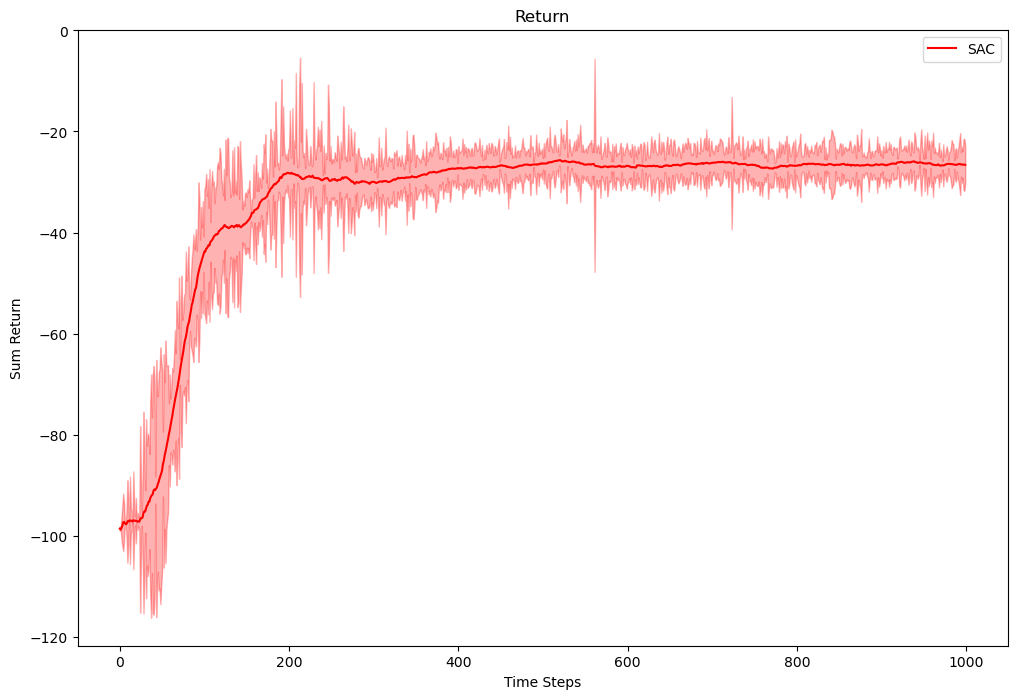

In [125]:
# plot ema returns
EMA_returns = np.array(EMA_returns)
plot_curves([EMA_returns], ['SAC'], ['r'], 'Sum Return', 'Return', smoothing = True)

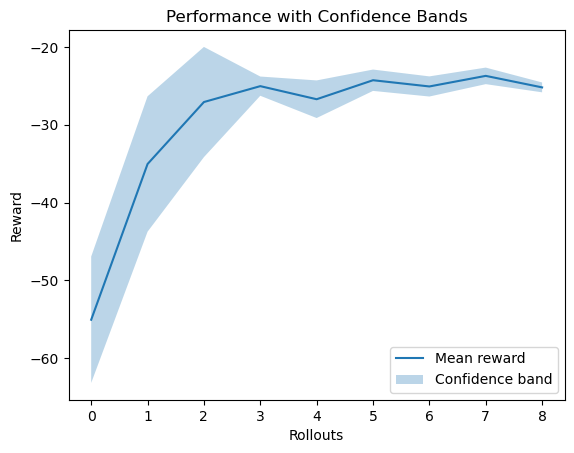

In [129]:
#plot ema eval returns
EMA_eval_returns = np.array(EMA_eval_returns)
EMA_eval_returns = EMA_eval_returns[:, 1:-1, :]
import numpy as np
import matplotlib.pyplot as plt

# assuming `arr` is your (5, 9, 5) array

# average across episodes for each trial and rollout
mean_values = np.mean(EMA_eval_returns, axis=2)  # shape: (5, 9)
std_values = np.std(EMA_eval_returns, axis=2)    # shape: (5, 9)

# average across trials
mean_across_trials = np.mean(mean_values, axis=0)  # shape: (9,)
std_across_trials = np.std(mean_values, axis=0)    # shape: (9,)

# plot
x = np.arange(mean_across_trials.shape[0])  # rollouts

plt.plot(x, mean_across_trials, label="Mean reward")
plt.fill_between(x, mean_across_trials - std_across_trials,
                 mean_across_trials + std_across_trials, alpha=0.3, label="Confidence band")
plt.xlabel("Rollouts")
plt.ylabel("Reward")
plt.legend()
plt.title("Performance with Confidence Bands")
plt.show()



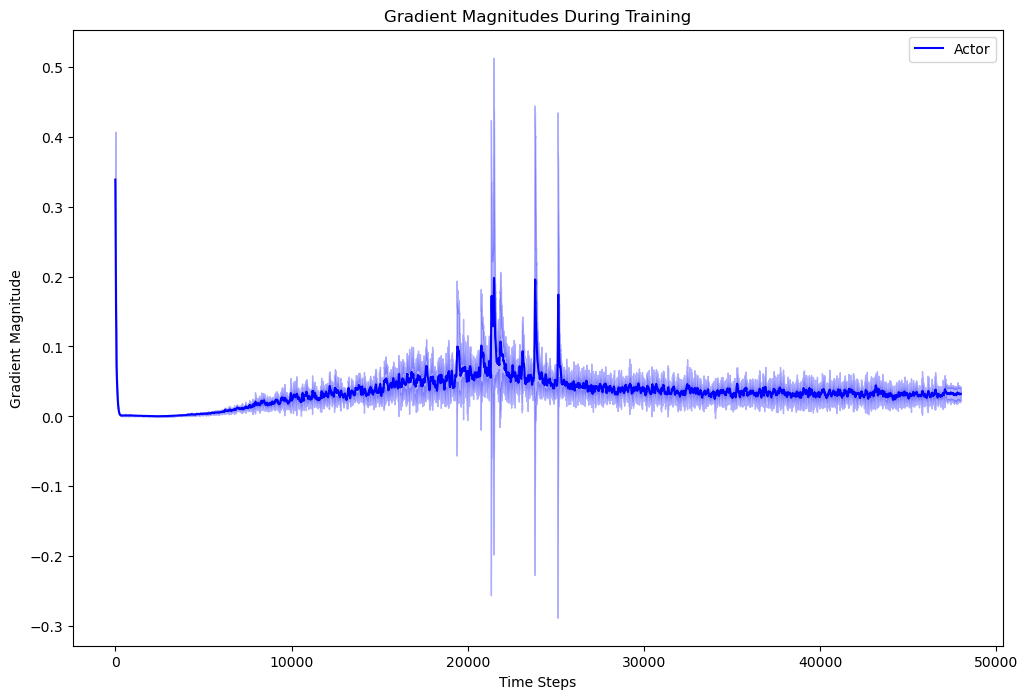

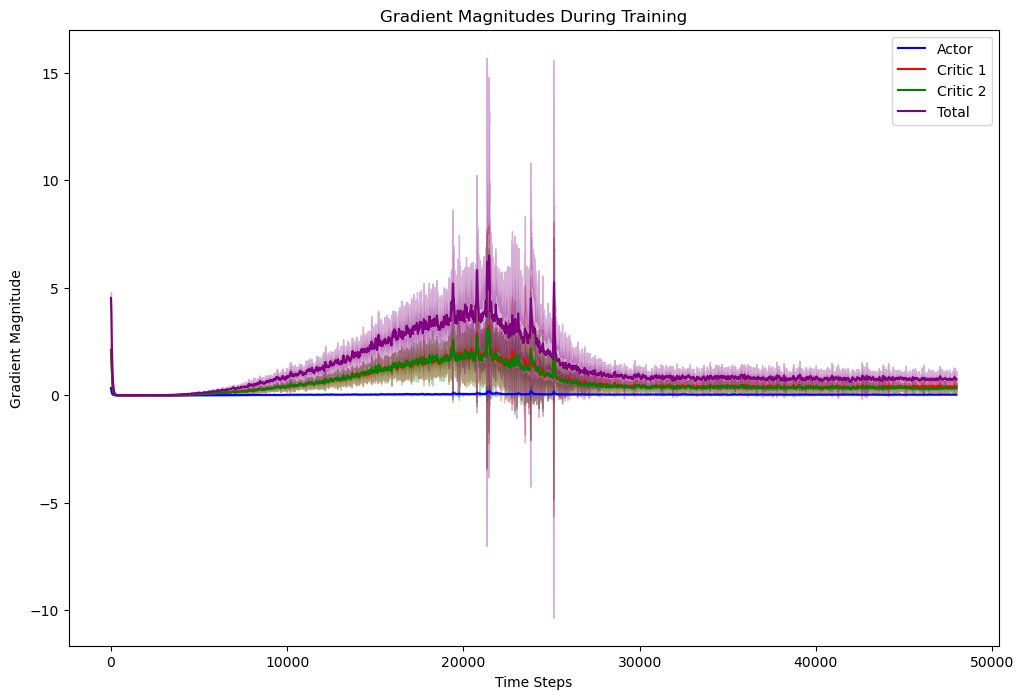

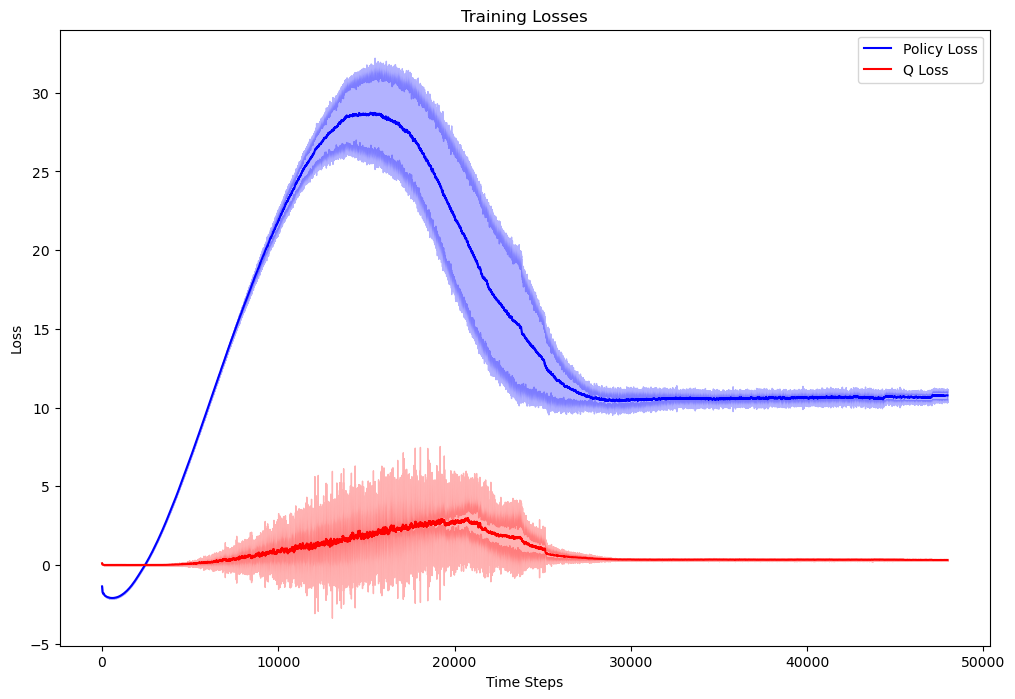

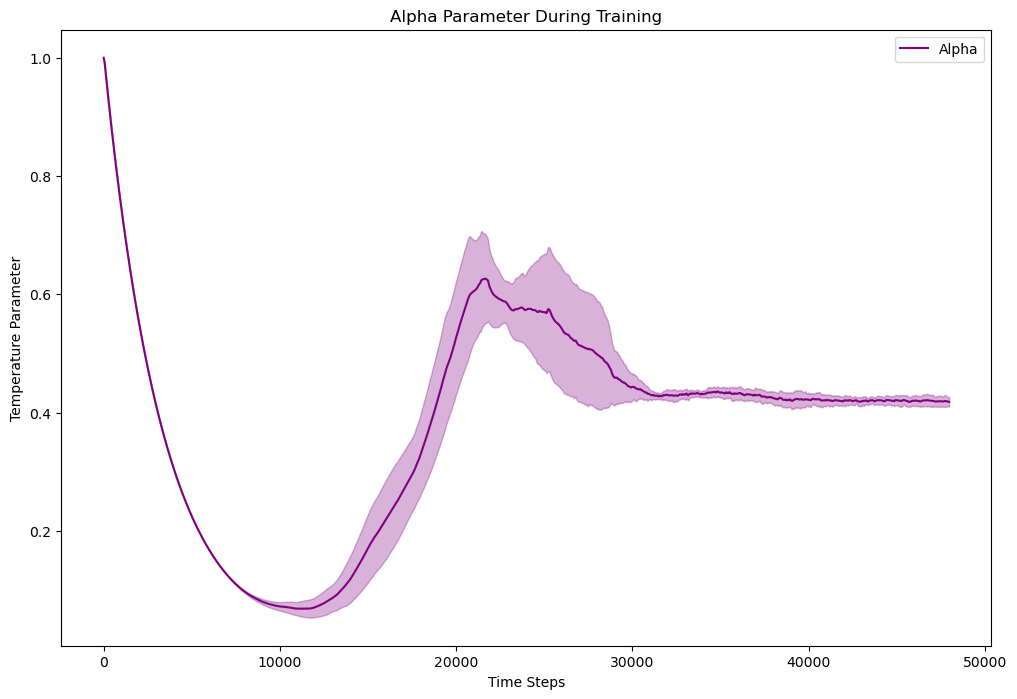

In [32]:
plot_training_metrics(EMA_grad_metrics, EMA_losses)

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import random
from collections import deque
from tqdm import tqdm
import gymnasium as gym
import os
import shutil
from datetime import datetime
import matplotlib.pyplot as plt

# ----------------------------- Replay Buffer ----------------------------- #

class ReplayBuffer:
    def __init__(self, capacity, batch_size, state_dim, device):
        self.capacity = capacity
        self.batch_size = batch_size
        self.device = device
        self.ptr = 0
        self.size = 0

        # Preallocate tensors for efficiency
        self.states = torch.zeros((capacity, state_dim), dtype=torch.float32, device=device)
        self.actions = torch.zeros((capacity, 1), dtype=torch.long, device=device)
        self.rewards = torch.zeros((capacity, 1), dtype=torch.float32, device=device)
        self.next_states = torch.zeros((capacity, state_dim), dtype=torch.float32, device=device)
        self.dones = torch.zeros((capacity, 1), dtype=torch.float32, device=device)

    def add(self, state, action, reward, next_state, done):
        self.states[self.ptr] = torch.from_numpy(state).float()
        self.actions[self.ptr] = torch.tensor([action], dtype=torch.long)
        self.rewards[self.ptr] = torch.tensor([reward], dtype=torch.float32)
        self.next_states[self.ptr] = torch.from_numpy(next_state).float()
        self.dones[self.ptr] = torch.tensor([done], dtype=torch.float32)

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self):
        indices = torch.randint(0, self.size, (self.batch_size,), device=self.device)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )

    def __len__(self):
        return self.size

# ----------------------------- Networks ----------------------------- #

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x), dim=-1)
        
    def get_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(next(self.parameters()).device)
        probs = self.forward(state)
        dist = Categorical(probs)
        if evaluate:
            action = torch.argmax(probs, dim=-1)
        else:  
            action = dist.sample()
        return action.item()

class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class SACAgentLunarEMA:
    def __init__(self, state_dim, action_dim, hidden_dim=256, lr=3e-4, gamma=0.99, tau=0.005, device="cpu", initial_alpha=0.2):
        self.gamma = gamma
        self.tau = tau
        self.device = device
        self.action_dim = action_dim
        
        # Initialize networks
        self.actor = Actor(state_dim, action_dim, hidden_dim).to(device)
        self.critic1 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic2 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic1_target = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic2_target = Critic(state_dim, action_dim, hidden_dim).to(device)
        
        # Copy parameters to targets
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        
        # Initialize optimizers with proper hyperparameters
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr, eps=1e-4)
        self.critic1_optimizer = torch.optim.Adam(self.critic1.parameters(), lr=lr, eps=1e-4)
        self.critic2_optimizer = torch.optim.Adam(self.critic2.parameters(), lr=lr, eps=1e-4)
        
        # Initialize temperature parameter with alpha=0.2
        self.target_entropy = 0.6 * (-np.log(1 / action_dim))  # Target entropy
        self.log_alpha = torch.tensor(np.log(initial_alpha), dtype=torch.float32, requires_grad=True, device=device)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=lr, eps=1e-4)
        self.alpha = self.log_alpha.exp().item()
        self.H_mean = 0  # Track entropy
        
    @property
    def alpha_value(self):
        return self.log_alpha.exp().item()
    
    def get_action(self, state, evaluate=False):
        return self.actor.get_action(state, evaluate)
    
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch, actor_grads, critic_1_grads, critic_2_grads):
        with torch.no_grad():
            next_probs = self.actor(next_state_batch)
            next_log_probs = torch.log(next_probs + 1e-8)
            q1_next = self.critic1_target(next_state_batch)
            q2_next = self.critic2_target(next_state_batch)
            min_q_next = torch.min(q1_next, q2_next)
            target_q = (next_probs * (min_q_next - self.alpha * next_log_probs)).sum(dim=1, keepdim=True)
            target_q = reward_batch + (1 - done_batch) * self.gamma * target_q
    
        current_q1 = self.critic1(state_batch).gather(1, action_batch)
        current_q2 = self.critic2(state_batch).gather(1, action_batch)
        
        critic1_loss = F.mse_loss(current_q1, target_q)
        critic2_loss = F.mse_loss(current_q2, target_q)
        
        # Apply EMA to gradients
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        critic_1_grads = gradfilter_ema(self.critic1, critic_1_grads, alpha=0.98, lamb=2.0)
        self.critic1_optimizer.step()
        
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        critic_2_grads = gradfilter_ema(self.critic2, critic_2_grads, alpha=0.98, lamb=2.0)
        self.critic2_optimizer.step()
        
        # Actor update with EMA gradients
        probs = self.actor(state_batch)
        log_probs = torch.log(probs + 1e-8)
        q1 = self.critic1(state_batch).detach()  # [batch, action_dim]
        q2 = self.critic2(state_batch).detach()  # [batch, action_dim]
        min_q = torch.min(q1, q2)
        actor_loss = (probs * (self.alpha * log_probs - min_q)).sum(dim=1).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_grads = gradfilter_ema(self.actor, actor_grads, alpha=0.98, lamb=2.0)
        self.actor_optimizer.step()
        
        # Track EMA gradients
        grad_stats = track_ema_grad_stats(actor_grads, critic_1_grads, critic_2_grads)

        with torch.no_grad():
            self.H_mean = -(probs * log_probs).sum(dim=1).mean()
        alpha_loss = self.log_alpha * (self.H_mean - self.target_entropy)
        
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        # Update alpha value
        self.alpha = self.alpha_value

        self.soft_update(self.critic1, self.critic1_target)
        self.soft_update(self.critic2, self.critic2_target)
        
        return actor_grads, critic_1_grads, critic_2_grads, grad_stats, {
            'critic1_loss': critic1_loss.item(),
            'critic2_loss': critic2_loss.item(),
            'actor_loss': actor_loss.item(),
            'alpha': self.alpha
        }
    
    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
    
    def save(self, timestep, EnvName):
        os.makedirs("models", exist_ok=True)
        torch.save(self.actor.state_dict(), f"./models/sacd_actor_EMA_{timestep}_{EnvName}.pth")
        torch.save(self.critic1.state_dict(), f"./models/sacd_critic1_EMA_{timestep}_{EnvName}.pth")
        torch.save(self.critic2.state_dict(), f"./models/sacd_critic2_EMA_{timestep}_{EnvName}.pth")
    
    def load(self, timestep, EnvName):
        self.actor.load_state_dict(torch.load(f"./models/sacd_actor_EMA_{timestep}_{EnvName}.pth", map_location=self.device))
        self.critic1.load_state_dict(torch.load(f"./models/sacd_critic1_EMA_{timestep}_{EnvName}.pth", map_location=self.device))
        self.critic2.load_state_dict(torch.load(f"./models/sacd_critic2_EMA_{timestep}_{EnvName}.pth", map_location=self.device))

# ----------------------------- Training and Evaluation ----------------------------- #

def compute_discounted_return(rewards, gamma):
    """Compute the discounted return by iterating backwards through the rewards."""
    discounted_return = 0.0
    for r in reversed(rewards):
        discounted_return = r + gamma * discounted_return
    return discounted_return

def evaluate_agent(env, agent, num_episodes=5, gamma=0.99):
    """Evaluate agent with both sum of rewards and discounted returns."""
    agent.actor.eval()
    sum_returns = []
    discounted_returns = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0.0
        episode_rewards = []
        while not done:
            action = agent.get_action(state, evaluate=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            episode_rewards.append(reward)
            state = next_state
        sum_returns.append(total_reward)
        discounted_returns.append(compute_discounted_return(episode_rewards, gamma))
    agent.actor.train()
    return np.mean(sum_returns), np.mean(discounted_returns)

def set_seed(seed, env):
    """Set seeds for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.reset(seed=seed)

def train_sac_lunar_ema(num_trials=5, num_steps=400_000, buffer_capacity=1_000_000, batch_size=256,
                     prepopulate_steps=10_000, eval_interval=10, num_eval_episodes=5, gamma=0.99, steps_per_update=50, updates_per_step=50):
    """Run multiple trials for Lunar Lander with SAC and EMA gradient tracking"""
    all_returns = []
    all_disc_returns = []
    all_eval_returns = []
    all_eval_disc = []
    all_losses = []
    all_grad_metrics = []
    all_episode_lengths = []  # New: Track episode lengths across all trials
    
    for trial in range(num_trials):
        print(f"\nTrial {trial + 1}/{num_trials}")
        
        # Set seeds
        seed = trial
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        env = gym.make("LunarLander-v2")
        eval_env = gym.make("LunarLander-v2")
        env.reset(seed=seed)
        eval_env.reset(seed=seed+1000)
        
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        agent = SACAgentLunarEMA(state_dim, action_dim, hidden_dim=200, lr=3e-4,
                           gamma=gamma, tau=0.005, device=device, initial_alpha=0.2)
        buffer = ReplayBuffer(buffer_capacity, batch_size, state_dim, device)
        
        returns = deque(maxlen=100)
        returns_over_steps = []
        discounted_returns = []
        eval_returns_sum = []
        eval_returns_discounted = []
        policy_losses = []
        q_losses = []
        alphas = []
        episode_lengths = []
        actor_grads = None
        critic_1_grads = None
        critic_2_grads = None
        grad_metrics = {
            'actor_grad_mag': [],
            'critic1_grad_mag': [],
            'critic2_grad_mag': [],
            'total_grad_mag': []
        }

        best_eval_return = float('-inf')
        
        # Prepopulate buffer
        state, _ = env.reset()
        pbar = tqdm(range(prepopulate_steps), desc="Prepopulating buffer")
        for _ in pbar:
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            if reward <= -100:
                reward = -10.0
            
            buffer.add(state, action, reward, next_state, done)
            
            if done:
                state, _ = env.reset()
            else:
                state = next_state
        
        # Training loop
        total_steps = 0
        episode = 0
        state, _ = env.reset()
        episode_rewards = []
        episode_steps = 0
        
        pbar = tqdm(range(num_steps), desc=f"Training Trial {trial+1}")
        for step in pbar:
            total_steps += 1
            episode_steps += 1
            
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            episode_rewards.append(reward)
            
            if reward <= -100:
                reward = -10.0
            
            buffer.add(state, action, reward, next_state, done)
            
            if len(buffer) >= batch_size and total_steps % steps_per_update == 0:
                for _ in range(updates_per_step):
                    actor_grads, critic_1_grads, critic_2_grads, grad_stats, loss_dict = agent.update(
                        *buffer.sample(), actor_grads, critic_1_grads, critic_2_grads)
                    
                    for key, value in grad_stats.items():
                        grad_metrics[key].append(value)
                    
                    policy_losses.append(loss_dict['actor_loss'])
                    q_losses.append((loss_dict['critic1_loss'] + loss_dict['critic2_loss']) / 2)
                    alphas.append(loss_dict['alpha'])
            
            if done:
                sum_return = sum(episode_rewards)
                discounted_return = compute_discounted_return(episode_rewards, gamma)
                episode_lengths.append(episode_steps)
                returns.append(sum_return)
                returns_over_steps.append(sum_return)
                discounted_returns.append(discounted_return)
                episode_rewards = []
                state, _ = env.reset()
                episode += 1
                episode_steps = 0
                
                if episode % eval_interval == 0:
                    eval_return_sum, eval_return_disc = evaluate_agent(eval_env, agent, num_eval_episodes, gamma)
                    eval_returns_sum.append(eval_return_sum)
                    eval_returns_discounted.append(eval_return_disc)
                    print(f"\nStep {total_steps}, Episode {episode}, Eval Return Sum: {eval_return_sum:.1f}, Eval Return Discounted: {eval_return_disc:.1f}")
                    # Save best model
                    if eval_return_sum > best_eval_return:
                        best_eval_return = eval_return_sum
                        agent.save(total_steps, "LunarLander")
                        print(f"New best model saved with Eval Return Sum: {eval_return_sum:.1f}")
                

                
                mean_return = np.mean(list(returns))
                mean_length = np.mean((episode_lengths[-100:]))
                # Add EMA gradient magnitudes to description
                recent_grads = {k: np.mean(v[-100:]) for k, v in grad_metrics.items() if v}
                desc = (f"Trial: {trial+1} | Step: {step} | Episode: {episode} | Return: {sum_return:.1f} | "
                       f"Discounted: {discounted_return:.1f} | Avg100: {mean_return:.1f} | "
                       f"Avg Length: {mean_length:.1f} | "  # New: Added average length to progress bar
                       f"EMA Actor Grad: {recent_grads.get('actor_grad_mag', 0):.3f} | "
                       f"EMA Critic Grads: {recent_grads.get('critic1_grad_mag', 0):.3f}, "
                       f"{recent_grads.get('critic2_grad_mag', 0):.3f}")
                pbar.set_description(desc)
            else:
                state = next_state
        
        # Store trial results
        all_returns.append(returns_over_steps)
        all_disc_returns.append(discounted_returns)
        all_eval_returns.append(eval_returns_sum)
        all_eval_disc.append(eval_returns_discounted)
        all_grad_metrics.append(grad_metrics)
        all_episode_lengths.append(episode_lengths)
        all_losses.append({
            'policy_loss': policy_losses,
            'q_loss': q_losses,
            'alpha': alphas
        })
        
        env.close()
        eval_env.close()
    
    return agent, all_returns, all_disc_returns, all_eval_returns, all_eval_disc, all_losses, all_grad_metrics, all_episode_lengths

In [46]:
# Define parameters directly
env_name = 'LunarLander-v2'
prepopulate_steps = 10_000
batch_size = 256
buffer_capacity = 100_000
num_train_steps = 350_000
eval_interval = 10
num_eval_episodes = 5
gamma = 0.99
    
# Create environment
env = gym.make(env_name)
    
# Train SAC Agent
lunarSACAgent_ema, returns_over_steps_ema, discounted_returns_ema, eval_returns_sum_ema, eval_returns_discount_ema, losses_ema, grad_metrics_ema, episode_lengths_ema = train_sac_lunar_ema(
        num_trials=3,
        num_steps=num_train_steps,
        buffer_capacity=buffer_capacity,
        batch_size=batch_size,
        prepopulate_steps=prepopulate_steps,
        eval_interval=eval_interval,
        num_eval_episodes=num_eval_episodes,
        gamma=gamma)


Trial 1/3


Prepopulating buffer: 100%|██████████| 10000/10000 [00:00<00:00, 20157.14it/s]
Trial: 1 | Step: 957 | Episode: 10 | Return: -560.5 | Discounted: -236.0 | Avg100: -567.1 | Avg Length: 95.8 | EMA Actor Grad: 0.316 | EMA Critic Grads: 4.457, 4.325:   0%|          | 950/350000 [00:09<1:00:39, 95.91it/s] 


Step 958, Episode 10, Eval Return Sum: -589.7, Eval Return Discounted: -319.3
New best model saved with Eval Return Sum: -589.7


Trial: 1 | Step: 5669 | Episode: 20 | Return: 54.5 | Discounted: 44.6 | Avg100: -315.6 | Avg Length: 283.5 | EMA Actor Grad: 0.144 | EMA Critic Grads: 13.381, 12.804:   2%|▏         | 5670/350000 [01:03<1:13:58, 77.58it/s] 


Step 5670, Episode 20, Eval Return Sum: -179.8, Eval Return Discounted: 25.9
New best model saved with Eval Return Sum: -179.8


Trial: 1 | Step: 9656 | Episode: 30 | Return: -20.1 | Discounted: 9.3 | Avg100: -206.6 | Avg Length: 321.9 | EMA Actor Grad: 0.087 | EMA Critic Grads: 9.583, 9.300:   3%|▎         | 9660/350000 [01:45<1:18:37, 72.15it/s]   


Step 9657, Episode 30, Eval Return Sum: -152.0, Eval Return Discounted: 17.5
New best model saved with Eval Return Sum: -152.0


Trial: 1 | Step: 16931 | Episode: 40 | Return: 0.7 | Discounted: 19.4 | Avg100: -137.2 | Avg Length: 423.3 | EMA Actor Grad: 0.080 | EMA Critic Grads: 15.371, 15.300:   5%|▍         | 16932/350000 [03:02<57:36, 96.37it/s]   


Step 16932, Episode 40, Eval Return Sum: -220.6, Eval Return Discounted: 16.9


Trial: 1 | Step: 23685 | Episode: 50 | Return: -55.4 | Discounted: 9.9 | Avg100: -118.6 | Avg Length: 473.7 | EMA Actor Grad: 0.084 | EMA Critic Grads: 15.885, 14.371:   7%|▋         | 23686/350000 [04:13<57:14, 95.00it/s]  


Step 23686, Episode 50, Eval Return Sum: -166.7, Eval Return Discounted: 22.5


Trial: 1 | Step: 33212 | Episode: 60 | Return: -51.7 | Discounted: 31.8 | Avg100: -95.7 | Avg Length: 553.5 | EMA Actor Grad: 0.091 | EMA Critic Grads: 14.764, 15.206:   9%|▉         | 33213/350000 [05:54<1:09:23, 76.09it/s]


Step 33213, Episode 60, Eval Return Sum: -74.3, Eval Return Discounted: 24.7
New best model saved with Eval Return Sum: -74.3


Trial: 1 | Step: 43212 | Episode: 70 | Return: -1.4 | Discounted: 40.4 | Avg100: -83.0 | Avg Length: 617.3 | EMA Actor Grad: 0.069 | EMA Critic Grads: 16.757, 16.041:  12%|█▏        | 43213/350000 [07:39<1:07:41, 75.54it/s] 


Step 43213, Episode 70, Eval Return Sum: -123.4, Eval Return Discounted: 28.0


Trial: 1 | Step: 52736 | Episode: 80 | Return: 56.1 | Discounted: 19.0 | Avg100: -68.2 | Avg Length: 659.2 | EMA Actor Grad: 0.065 | EMA Critic Grads: 15.975, 14.752:  15%|█▌        | 52737/350000 [09:20<53:42, 92.25it/s]  


Step 52737, Episode 80, Eval Return Sum: -138.2, Eval Return Discounted: 28.3


Trial: 1 | Step: 61500 | Episode: 90 | Return: 89.4 | Discounted: 30.1 | Avg100: -54.6 | Avg Length: 683.3 | EMA Actor Grad: 0.065 | EMA Critic Grads: 14.669, 14.995:  18%|█▊        | 61510/350000 [10:53<1:06:22, 72.43it/s]


Step 61501, Episode 90, Eval Return Sum: -95.7, Eval Return Discounted: 26.2


Trial: 1 | Step: 70919 | Episode: 100 | Return: 216.9 | Discounted: 67.3 | Avg100: -35.8 | Avg Length: 709.2 | EMA Actor Grad: 0.074 | EMA Critic Grads: 14.061, 15.036:  20%|██        | 70920/350000 [12:33<59:48, 77.77it/s]


Step 70920, Episode 100, Eval Return Sum: -6.2, Eval Return Discounted: 37.7
New best model saved with Eval Return Sum: -6.2


Trial: 1 | Step: 80919 | Episode: 110 | Return: 86.3 | Discounted: 31.8 | Avg100: 30.6 | Avg Length: 799.6 | EMA Actor Grad: 0.080 | EMA Critic Grads: 15.103, 16.698:  23%|██▎       | 80920/350000 [14:22<1:05:43, 68.24it/s]  


Step 80920, Episode 110, Eval Return Sum: -20.9, Eval Return Discounted: 42.5


Trial: 1 | Step: 90919 | Episode: 120 | Return: 125.6 | Discounted: 47.3 | Avg100: 46.1 | Avg Length: 852.5 | EMA Actor Grad: 0.086 | EMA Critic Grads: 17.073, 18.044:  26%|██▌       | 90920/350000 [16:08<53:03, 81.38it/s] 


Step 90920, Episode 120, Eval Return Sum: 78.5, Eval Return Discounted: 38.9
New best model saved with Eval Return Sum: 78.5


Trial: 1 | Step: 100045 | Episode: 130 | Return: 116.1 | Discounted: 48.4 | Avg100: 51.6 | Avg Length: 903.9 | EMA Actor Grad: 0.056 | EMA Critic Grads: 8.819, 9.567:  29%|██▊       | 100046/350000 [17:45<45:07, 92.33it/s]  


Step 100046, Episode 130, Eval Return Sum: -11.2, Eval Return Discounted: 35.1


Trial: 1 | Step: 109426 | Episode: 140 | Return: -63.6 | Discounted: 39.4 | Avg100: 52.1 | Avg Length: 925.0 | EMA Actor Grad: 0.086 | EMA Critic Grads: 5.103, 5.592:  31%|███▏      | 109427/350000 [19:24<47:04, 85.18it/s] 


Step 109427, Episode 140, Eval Return Sum: 47.9, Eval Return Discounted: 37.0


Trial: 1 | Step: 118397 | Episode: 150 | Return: 80.3 | Discounted: 39.2 | Avg100: 65.7 | Avg Length: 947.1 | EMA Actor Grad: 0.059 | EMA Critic Grads: 4.644, 4.598:  34%|███▍      | 118398/350000 [20:58<38:40, 99.79it/s] 


Step 118398, Episode 150, Eval Return Sum: 36.5, Eval Return Discounted: 46.4


Trial: 1 | Step: 126136 | Episode: 160 | Return: 129.5 | Discounted: 44.0 | Avg100: 73.9 | Avg Length: 929.2 | EMA Actor Grad: 0.046 | EMA Critic Grads: 3.957, 4.215:  36%|███▌      | 126137/350000 [22:22<36:56, 100.98it/s]


Step 126137, Episode 160, Eval Return Sum: 224.4, Eval Return Discounted: 47.6
New best model saved with Eval Return Sum: 224.4


Trial: 1 | Step: 135044 | Episode: 170 | Return: 146.3 | Discounted: 59.9 | Avg100: 87.2 | Avg Length: 918.3 | EMA Actor Grad: 0.050 | EMA Critic Grads: 3.873, 4.288:  39%|███▊      | 135045/350000 [23:57<33:13, 107.85it/s]


Step 135045, Episode 170, Eval Return Sum: 206.5, Eval Return Discounted: 33.6


Trial: 1 | Step: 145044 | Episode: 180 | Return: 165.0 | Discounted: 49.5 | Avg100: 97.6 | Avg Length: 923.1 | EMA Actor Grad: 0.048 | EMA Critic Grads: 3.327, 3.374:  41%|████▏     | 145045/350000 [25:46<32:10, 106.19it/s]


Step 145045, Episode 180, Eval Return Sum: 245.6, Eval Return Discounted: 53.5
New best model saved with Eval Return Sum: 245.6


Trial: 1 | Step: 155044 | Episode: 190 | Return: 195.0 | Discounted: 53.7 | Avg100: 107.9 | Avg Length: 935.4 | EMA Actor Grad: 0.073 | EMA Critic Grads: 2.801, 2.971:  44%|████▍     | 155045/350000 [27:36<31:06, 104.45it/s]


Step 155045, Episode 190, Eval Return Sum: 226.4, Eval Return Discounted: 53.4


Trial: 1 | Step: 163461 | Episode: 200 | Return: 151.4 | Discounted: 47.9 | Avg100: 107.9 | Avg Length: 925.4 | EMA Actor Grad: 0.056 | EMA Critic Grads: 3.185, 3.145:  47%|████▋     | 163462/350000 [29:07<38:31, 80.70it/s] 


Step 163462, Episode 200, Eval Return Sum: 174.7, Eval Return Discounted: 40.8


Trial: 1 | Step: 171121 | Episode: 210 | Return: 123.0 | Discounted: 41.2 | Avg100: 109.1 | Avg Length: 902.0 | EMA Actor Grad: 0.052 | EMA Critic Grads: 3.227, 3.311:  49%|████▉     | 171122/350000 [30:28<33:04, 90.15it/s]


Step 171122, Episode 210, Eval Return Sum: 156.7, Eval Return Discounted: 45.8


Trial: 1 | Step: 181121 | Episode: 220 | Return: 119.0 | Discounted: 42.3 | Avg100: 113.7 | Avg Length: 902.0 | EMA Actor Grad: 0.048 | EMA Critic Grads: 2.297, 2.427:  52%|█████▏    | 181122/350000 [32:15<32:09, 87.53it/s]


Step 181122, Episode 220, Eval Return Sum: 185.6, Eval Return Discounted: 45.4


Trial: 1 | Step: 190492 | Episode: 230 | Return: 141.5 | Discounted: 48.9 | Avg100: 123.6 | Avg Length: 904.5 | EMA Actor Grad: 0.039 | EMA Critic Grads: 2.419, 2.698:  54%|█████▍    | 190493/350000 [33:53<24:38, 107.90it/s]


Step 190493, Episode 230, Eval Return Sum: 249.6, Eval Return Discounted: 46.3
New best model saved with Eval Return Sum: 249.6


Trial: 1 | Step: 199953 | Episode: 240 | Return: 159.3 | Discounted: 52.3 | Avg100: 131.7 | Avg Length: 905.3 | EMA Actor Grad: 0.038 | EMA Critic Grads: 2.075, 2.259:  57%|█████▋    | 199960/350000 [35:34<30:28, 82.08it/s] 


Step 199954, Episode 240, Eval Return Sum: 172.3, Eval Return Discounted: 41.5


Trial: 1 | Step: 208181 | Episode: 250 | Return: 106.5 | Discounted: 61.9 | Avg100: 134.1 | Avg Length: 897.8 | EMA Actor Grad: 0.047 | EMA Critic Grads: 3.042, 2.925:  59%|█████▉    | 208182/350000 [37:04<22:55, 103.08it/s]


Step 208182, Episode 250, Eval Return Sum: 259.4, Eval Return Discounted: 64.5
New best model saved with Eval Return Sum: 259.4


Trial: 1 | Step: 217150 | Episode: 260 | Return: 111.3 | Discounted: 33.8 | Avg100: 140.4 | Avg Length: 910.1 | EMA Actor Grad: 0.067 | EMA Critic Grads: 1.895, 1.931:  62%|██████▏   | 217160/350000 [38:41<25:16, 87.57it/s] 


Step 217151, Episode 260, Eval Return Sum: 256.3, Eval Return Discounted: 58.6


Trial: 1 | Step: 225895 | Episode: 270 | Return: 218.8 | Discounted: 59.2 | Avg100: 144.8 | Avg Length: 908.5 | EMA Actor Grad: 0.056 | EMA Critic Grads: 2.884, 2.505:  65%|██████▍   | 225896/350000 [40:16<18:56, 109.20it/s]


Step 225896, Episode 270, Eval Return Sum: 235.1, Eval Return Discounted: 49.2


Trial: 1 | Step: 234872 | Episode: 280 | Return: 119.9 | Discounted: 35.5 | Avg100: 146.5 | Avg Length: 898.3 | EMA Actor Grad: 0.048 | EMA Critic Grads: 2.122, 2.210:  67%|██████▋   | 234873/350000 [41:53<20:24, 94.02it/s] 


Step 234873, Episode 280, Eval Return Sum: 246.0, Eval Return Discounted: 54.1


Trial: 1 | Step: 243928 | Episode: 290 | Return: 157.2 | Discounted: 74.6 | Avg100: 148.2 | Avg Length: 888.8 | EMA Actor Grad: 0.047 | EMA Critic Grads: 1.812, 1.564:  70%|██████▉   | 243929/350000 [43:30<17:05, 103.47it/s]


Step 243929, Episode 290, Eval Return Sum: 202.7, Eval Return Discounted: 52.3


Trial: 1 | Step: 252596 | Episode: 300 | Return: 143.3 | Discounted: 71.6 | Avg100: 152.4 | Avg Length: 891.4 | EMA Actor Grad: 0.045 | EMA Critic Grads: 1.943, 1.861:  72%|███████▏  | 252597/350000 [45:03<15:04, 107.73it/s]


Step 252597, Episode 300, Eval Return Sum: 218.8, Eval Return Discounted: 63.5


Trial: 1 | Step: 260039 | Episode: 310 | Return: 150.9 | Discounted: 53.3 | Avg100: 158.1 | Avg Length: 889.2 | EMA Actor Grad: 0.091 | EMA Critic Grads: 2.525, 2.256:  74%|███████▍  | 260040/350000 [46:23<13:37, 110.07it/s]


Step 260040, Episode 310, Eval Return Sum: 263.3, Eval Return Discounted: 63.7
New best model saved with Eval Return Sum: 263.3


Trial: 1 | Step: 268609 | Episode: 320 | Return: 171.4 | Discounted: 24.1 | Avg100: 163.9 | Avg Length: 874.9 | EMA Actor Grad: 0.089 | EMA Critic Grads: 2.564, 2.557:  77%|███████▋  | 268610/350000 [47:56<15:16, 88.79it/s] 


Step 268610, Episode 320, Eval Return Sum: 268.2, Eval Return Discounted: 63.5
New best model saved with Eval Return Sum: 268.2


Trial: 1 | Step: 277900 | Episode: 330 | Return: 176.0 | Discounted: 75.6 | Avg100: 165.8 | Avg Length: 874.1 | EMA Actor Grad: 0.096 | EMA Critic Grads: 2.829, 2.856:  79%|███████▉  | 277910/350000 [49:43<13:38, 88.08it/s]


Step 277901, Episode 330, Eval Return Sum: 263.2, Eval Return Discounted: 62.4


Trial: 1 | Step: 286207 | Episode: 340 | Return: 165.0 | Discounted: 56.6 | Avg100: 168.7 | Avg Length: 862.5 | EMA Actor Grad: 0.088 | EMA Critic Grads: 2.894, 2.938:  82%|████████▏ | 286210/350000 [51:13<11:47, 90.12it/s]


Step 286208, Episode 340, Eval Return Sum: 263.3, Eval Return Discounted: 62.8


Trial: 1 | Step: 294705 | Episode: 350 | Return: 240.9 | Discounted: 54.0 | Avg100: 175.5 | Avg Length: 865.2 | EMA Actor Grad: 0.096 | EMA Critic Grads: 2.775, 2.849:  84%|████████▍ | 294710/350000 [52:42<10:45, 85.69it/s]


Step 294706, Episode 350, Eval Return Sum: 228.7, Eval Return Discounted: 55.4


Trial: 1 | Step: 303221 | Episode: 360 | Return: 109.9 | Discounted: 39.9 | Avg100: 172.8 | Avg Length: 860.7 | EMA Actor Grad: 0.101 | EMA Critic Grads: 2.922, 2.716:  87%|████████▋ | 303222/350000 [54:11<08:13, 94.85it/s]


Step 303222, Episode 360, Eval Return Sum: 239.5, Eval Return Discounted: 60.3


Trial: 1 | Step: 311712 | Episode: 370 | Return: 257.0 | Discounted: 87.1 | Avg100: 172.8 | Avg Length: 858.2 | EMA Actor Grad: 0.074 | EMA Critic Grads: 2.141, 2.120:  89%|████████▉ | 311713/350000 [55:43<07:17, 87.53it/s]


Step 311713, Episode 370, Eval Return Sum: 253.8, Eval Return Discounted: 64.8


Trial: 1 | Step: 321384 | Episode: 380 | Return: 189.8 | Discounted: 60.3 | Avg100: 172.9 | Avg Length: 865.1 | EMA Actor Grad: 0.076 | EMA Critic Grads: 3.104, 3.424:  92%|█████████▏| 321385/350000 [57:24<04:34, 104.16it/s]


Step 321385, Episode 380, Eval Return Sum: 241.0, Eval Return Discounted: 54.5


Trial: 1 | Step: 330055 | Episode: 390 | Return: 245.9 | Discounted: 65.7 | Avg100: 169.4 | Avg Length: 861.3 | EMA Actor Grad: 0.060 | EMA Critic Grads: 2.461, 2.541:  94%|█████████▍| 330060/350000 [58:55<03:47, 87.51it/s] 


Step 330056, Episode 390, Eval Return Sum: 193.3, Eval Return Discounted: 56.3


Trial: 1 | Step: 338336 | Episode: 400 | Return: 179.4 | Discounted: 60.3 | Avg100: 169.6 | Avg Length: 857.4 | EMA Actor Grad: 0.066 | EMA Critic Grads: 3.312, 3.899:  97%|█████████▋| 338337/350000 [1:00:21<01:58, 98.73it/s]


Step 338337, Episode 400, Eval Return Sum: 215.6, Eval Return Discounted: 57.5


Trial: 1 | Step: 347551 | Episode: 410 | Return: 192.1 | Discounted: 86.0 | Avg100: 170.3 | Avg Length: 875.1 | EMA Actor Grad: 0.056 | EMA Critic Grads: 2.151, 2.827:  99%|█████████▉| 347560/350000 [1:01:58<00:29, 81.80it/s]


Step 347552, Episode 410, Eval Return Sum: 220.3, Eval Return Discounted: 59.6


Trial: 1 | Step: 349551 | Episode: 412 | Return: 155.4 | Discounted: 56.3 | Avg100: 169.6 | Avg Length: 881.4 | EMA Actor Grad: 0.044 | EMA Critic Grads: 2.509, 3.101: 100%|██████████| 350000/350000 [1:02:23<00:00, 93.49it/s]



Trial 2/3


Prepopulating buffer: 100%|██████████| 10000/10000 [00:00<00:00, 19607.95it/s]
Trial: 2 | Step: 1420 | Episode: 10 | Return: -383.9 | Discounted: -194.9 | Avg100: -971.3 | Avg Length: 142.1 | EMA Actor Grad: 0.000 | EMA Critic Grads: 7.218, 7.371:   0%|          | 1400/350000 [00:14<1:01:22, 94.67it/s] 


Step 1421, Episode 10, Eval Return Sum: -691.1, Eval Return Discounted: -370.5
New best model saved with Eval Return Sum: -691.1


Trial: 2 | Step: 3074 | Episode: 20 | Return: 20.3 | Discounted: 26.9 | Avg100: -796.9 | Avg Length: 153.8 | EMA Actor Grad: 0.084 | EMA Critic Grads: 10.014, 10.529:   1%|          | 3075/350000 [00:32<1:08:35, 84.29it/s]     


Step 3075, Episode 20, Eval Return Sum: -52.9, Eval Return Discounted: 34.7
New best model saved with Eval Return Sum: -52.9


Trial: 2 | Step: 5643 | Episode: 30 | Return: 61.9 | Discounted: 27.6 | Avg100: -529.2 | Avg Length: 188.1 | EMA Actor Grad: 0.077 | EMA Critic Grads: 7.557, 7.994:   2%|▏         | 5644/350000 [01:01<1:03:38, 90.19it/s]  


Step 5644, Episode 30, Eval Return Sum: -145.6, Eval Return Discounted: 27.7


Trial: 2 | Step: 13952 | Episode: 40 | Return: 108.0 | Discounted: 53.2 | Avg100: -382.4 | Avg Length: 348.8 | EMA Actor Grad: 0.117 | EMA Critic Grads: 15.693, 18.690:   4%|▍         | 13960/350000 [02:32<1:00:34, 92.47it/s]


Step 13953, Episode 40, Eval Return Sum: -105.2, Eval Return Discounted: 12.5


Trial: 2 | Step: 20295 | Episode: 50 | Return: 94.8 | Discounted: 22.5 | Avg100: -307.6 | Avg Length: 405.9 | EMA Actor Grad: 0.093 | EMA Critic Grads: 14.083, 13.685:   6%|▌         | 20296/350000 [03:41<48:20, 113.67it/s]   


Step 20296, Episode 50, Eval Return Sum: -155.3, Eval Return Discounted: 13.4


Trial: 2 | Step: 29638 | Episode: 60 | Return: 150.8 | Discounted: 70.5 | Avg100: -246.6 | Avg Length: 494.0 | EMA Actor Grad: 0.104 | EMA Critic Grads: 16.094, 14.737:   8%|▊         | 29639/350000 [05:17<58:20, 91.51it/s] 


Step 29639, Episode 60, Eval Return Sum: -161.4, Eval Return Discounted: 26.3


Trial: 2 | Step: 39395 | Episode: 70 | Return: 86.1 | Discounted: 43.3 | Avg100: -198.1 | Avg Length: 562.8 | EMA Actor Grad: 0.072 | EMA Critic Grads: 13.190, 12.336:  11%|█▏        | 39396/350000 [06:59<55:06, 93.93it/s]   


Step 39396, Episode 70, Eval Return Sum: -92.8, Eval Return Discounted: 25.7


Trial: 2 | Step: 49395 | Episode: 80 | Return: 124.2 | Discounted: 42.1 | Avg100: -160.4 | Avg Length: 617.5 | EMA Actor Grad: 0.087 | EMA Critic Grads: 16.199, 18.108:  14%|█▍        | 49396/350000 [08:43<44:52, 111.66it/s]


Step 49396, Episode 80, Eval Return Sum: 233.4, Eval Return Discounted: 52.6
New best model saved with Eval Return Sum: 233.4


Trial: 2 | Step: 58868 | Episode: 90 | Return: 84.4 | Discounted: 35.9 | Avg100: -127.4 | Avg Length: 654.1 | EMA Actor Grad: 0.087 | EMA Critic Grads: 15.342, 14.773:  17%|█▋        | 58869/350000 [10:21<51:39, 93.93it/s]   


Step 58869, Episode 90, Eval Return Sum: 216.4, Eval Return Discounted: 40.4


Trial: 2 | Step: 68868 | Episode: 100 | Return: 123.2 | Discounted: 43.5 | Avg100: -100.9 | Avg Length: 688.7 | EMA Actor Grad: 0.073 | EMA Critic Grads: 20.515, 20.677:  20%|█▉        | 68869/350000 [12:05<54:34, 85.85it/s]


Step 68869, Episode 100, Eval Return Sum: 161.0, Eval Return Discounted: 48.2


Trial: 2 | Step: 78868 | Episode: 110 | Return: 152.8 | Discounted: 51.9 | Avg100: 9.6 | Avg Length: 774.5 | EMA Actor Grad: 0.089 | EMA Critic Grads: 21.588, 21.122:  23%|██▎       | 78869/350000 [13:49<53:37, 84.27it/s]     


Step 78869, Episode 110, Eval Return Sum: 138.9, Eval Return Discounted: 41.6


Trial: 2 | Step: 87649 | Episode: 120 | Return: -54.6 | Discounted: 39.6 | Avg100: 84.1 | Avg Length: 845.8 | EMA Actor Grad: 0.065 | EMA Critic Grads: 56.278, 61.916:  25%|██▌       | 87650/350000 [15:21<51:44, 84.50it/s]


Step 87650, Episode 120, Eval Return Sum: 223.0, Eval Return Discounted: 46.0


Trial: 2 | Step: 97649 | Episode: 130 | Return: 128.6 | Discounted: 46.6 | Avg100: 96.2 | Avg Length: 920.1 | EMA Actor Grad: 0.065 | EMA Critic Grads: 55.002, 52.816:  28%|██▊       | 97650/350000 [17:04<48:14, 87.18it/s]


Step 97650, Episode 130, Eval Return Sum: 254.8, Eval Return Discounted: 64.5
New best model saved with Eval Return Sum: 254.8


Trial: 2 | Step: 107649 | Episode: 140 | Return: 155.3 | Discounted: 53.8 | Avg100: 104.2 | Avg Length: 937.0 | EMA Actor Grad: 0.070 | EMA Critic Grads: 6.376, 5.506:  31%|███       | 107650/350000 [18:50<50:18, 80.29it/s]


Step 107650, Episode 140, Eval Return Sum: 232.6, Eval Return Discounted: 56.4


Trial: 2 | Step: 117097 | Episode: 150 | Return: 153.2 | Discounted: 53.5 | Avg100: 119.2 | Avg Length: 968.0 | EMA Actor Grad: 0.067 | EMA Critic Grads: 5.821, 3.985:  33%|███▎      | 117098/350000 [20:37<38:30, 100.82it/s] 


Step 117098, Episode 150, Eval Return Sum: 185.1, Eval Return Discounted: 40.1


Trial: 2 | Step: 127097 | Episode: 160 | Return: 178.5 | Discounted: 48.3 | Avg100: 130.2 | Avg Length: 974.6 | EMA Actor Grad: 0.044 | EMA Critic Grads: 4.602, 4.311:  36%|███▋      | 127098/350000 [22:27<33:56, 109.45it/s]


Step 127098, Episode 160, Eval Return Sum: 250.3, Eval Return Discounted: 50.3


Trial: 2 | Step: 137097 | Episode: 170 | Return: 149.7 | Discounted: 50.9 | Avg100: 136.8 | Avg Length: 977.0 | EMA Actor Grad: 0.066 | EMA Critic Grads: 4.166, 2.776:  39%|███▉      | 137098/350000 [24:18<34:02, 104.24it/s]


Step 137098, Episode 170, Eval Return Sum: 221.7, Eval Return Discounted: 59.5


Trial: 2 | Step: 146178 | Episode: 180 | Return: 151.7 | Discounted: 54.9 | Avg100: 141.9 | Avg Length: 967.8 | EMA Actor Grad: 0.058 | EMA Critic Grads: 3.344, 3.132:  42%|████▏     | 146179/350000 [25:58<33:26, 101.58it/s]


Step 146179, Episode 180, Eval Return Sum: 278.7, Eval Return Discounted: 80.5
New best model saved with Eval Return Sum: 278.7


Trial: 2 | Step: 156178 | Episode: 190 | Return: 198.9 | Discounted: 98.1 | Avg100: 144.9 | Avg Length: 973.1 | EMA Actor Grad: 0.045 | EMA Critic Grads: 2.688, 2.246:  45%|████▍     | 156179/350000 [27:50<35:51, 90.08it/s] 


Step 156179, Episode 190, Eval Return Sum: 237.4, Eval Return Discounted: 51.3


Trial: 2 | Step: 166178 | Episode: 200 | Return: 139.7 | Discounted: 46.9 | Avg100: 144.7 | Avg Length: 973.1 | EMA Actor Grad: 0.045 | EMA Critic Grads: 2.911, 2.596:  47%|████▋     | 166179/350000 [29:41<30:16, 101.22it/s]


Step 166179, Episode 200, Eval Return Sum: 249.2, Eval Return Discounted: 59.3


Trial: 2 | Step: 176178 | Episode: 210 | Return: 136.4 | Discounted: 52.6 | Avg100: 146.5 | Avg Length: 973.1 | EMA Actor Grad: 0.051 | EMA Critic Grads: 2.448, 1.891:  50%|█████     | 176179/350000 [31:31<28:49, 100.50it/s]


Step 176179, Episode 210, Eval Return Sum: 268.2, Eval Return Discounted: 68.4


Trial: 2 | Step: 186178 | Episode: 220 | Return: 163.1 | Discounted: 80.3 | Avg100: 150.7 | Avg Length: 985.3 | EMA Actor Grad: 0.059 | EMA Critic Grads: 2.480, 2.456:  53%|█████▎    | 186179/350000 [33:22<26:57, 101.29it/s]


Step 186179, Episode 220, Eval Return Sum: 274.7, Eval Return Discounted: 69.1


Trial: 2 | Step: 194359 | Episode: 230 | Return: 27.4 | Discounted: 29.1 | Avg100: 151.2 | Avg Length: 967.1 | EMA Actor Grad: 0.046 | EMA Critic Grads: 2.402, 1.896:  56%|█████▌    | 194360/350000 [34:53<28:55, 89.67it/s]  


Step 194360, Episode 230, Eval Return Sum: 279.7, Eval Return Discounted: 91.4
New best model saved with Eval Return Sum: 279.7


Trial: 2 | Step: 203481 | Episode: 240 | Return: 181.8 | Discounted: 86.8 | Avg100: 153.1 | Avg Length: 958.3 | EMA Actor Grad: 0.062 | EMA Critic Grads: 2.020, 1.574:  58%|█████▊    | 203482/350000 [36:32<25:48, 94.63it/s]


Step 203482, Episode 240, Eval Return Sum: 218.4, Eval Return Discounted: 66.6


Trial: 2 | Step: 213481 | Episode: 250 | Return: 200.7 | Discounted: 90.8 | Avg100: 154.6 | Avg Length: 963.8 | EMA Actor Grad: 0.037 | EMA Critic Grads: 1.554, 1.514:  61%|██████    | 213482/350000 [38:20<22:36, 100.66it/s]


Step 213482, Episode 250, Eval Return Sum: 280.8, Eval Return Discounted: 76.5
New best model saved with Eval Return Sum: 280.8


Trial: 2 | Step: 223481 | Episode: 260 | Return: 196.4 | Discounted: 63.0 | Avg100: 154.1 | Avg Length: 963.8 | EMA Actor Grad: 0.037 | EMA Critic Grads: 1.714, 1.233:  64%|██████▍   | 223482/350000 [40:08<19:40, 107.22it/s]


Step 223482, Episode 260, Eval Return Sum: 283.3, Eval Return Discounted: 76.6
New best model saved with Eval Return Sum: 283.3


Trial: 2 | Step: 233481 | Episode: 270 | Return: 160.1 | Discounted: 80.7 | Avg100: 155.7 | Avg Length: 963.8 | EMA Actor Grad: 0.030 | EMA Critic Grads: 1.620, 1.343:  67%|██████▋   | 233482/350000 [41:55<17:49, 108.96it/s]


Step 233482, Episode 270, Eval Return Sum: 283.7, Eval Return Discounted: 74.3
New best model saved with Eval Return Sum: 283.7


Trial: 2 | Step: 243311 | Episode: 280 | Return: 191.0 | Discounted: 80.0 | Avg100: 157.6 | Avg Length: 971.3 | EMA Actor Grad: 0.028 | EMA Critic Grads: 1.859, 1.945:  70%|██████▉   | 243312/350000 [43:40<18:46, 94.70it/s] 


Step 243312, Episode 280, Eval Return Sum: 274.7, Eval Return Discounted: 79.6


Trial: 2 | Step: 252936 | Episode: 290 | Return: 139.3 | Discounted: 55.4 | Avg100: 159.6 | Avg Length: 967.6 | EMA Actor Grad: 0.026 | EMA Critic Grads: 2.084, 1.639:  72%|███████▏  | 252937/350000 [45:22<14:54, 108.53it/s]


Step 252937, Episode 290, Eval Return Sum: 278.8, Eval Return Discounted: 78.1


Trial: 2 | Step: 262031 | Episode: 300 | Return: 163.7 | Discounted: 64.7 | Avg100: 162.1 | Avg Length: 958.5 | EMA Actor Grad: 0.020 | EMA Critic Grads: 1.339, 1.000:  75%|███████▍  | 262032/350000 [46:56<12:52, 113.91it/s]


Step 262032, Episode 300, Eval Return Sum: 270.2, Eval Return Discounted: 79.8


Trial: 2 | Step: 272031 | Episode: 310 | Return: 149.8 | Discounted: 31.4 | Avg100: 163.5 | Avg Length: 958.5 | EMA Actor Grad: 0.030 | EMA Critic Grads: 2.023, 1.862:  78%|███████▊  | 272032/350000 [48:39<12:42, 102.26it/s]


Step 272032, Episode 310, Eval Return Sum: 257.8, Eval Return Discounted: 78.1


Trial: 2 | Step: 282031 | Episode: 320 | Return: 172.9 | Discounted: 63.0 | Avg100: 163.4 | Avg Length: 958.5 | EMA Actor Grad: 0.028 | EMA Critic Grads: 2.871, 1.913:  81%|████████  | 282032/350000 [50:21<11:12, 101.00it/s]


Step 282032, Episode 320, Eval Return Sum: 261.0, Eval Return Discounted: 87.4


Trial: 2 | Step: 292031 | Episode: 330 | Return: 130.0 | Discounted: 46.0 | Avg100: 166.6 | Avg Length: 976.7 | EMA Actor Grad: 0.018 | EMA Critic Grads: 0.799, 0.799:  83%|████████▎ | 292032/350000 [52:03<08:36, 112.22it/s]


Step 292032, Episode 330, Eval Return Sum: 284.2, Eval Return Discounted: 76.5
New best model saved with Eval Return Sum: 284.2


Trial: 2 | Step: 300758 | Episode: 340 | Return: 190.9 | Discounted: 78.5 | Avg100: 168.1 | Avg Length: 972.8 | EMA Actor Grad: 0.030 | EMA Critic Grads: 1.659, 1.567:  86%|████████▌ | 300760/350000 [53:33<08:36, 95.29it/s] 


Step 300759, Episode 340, Eval Return Sum: 272.8, Eval Return Discounted: 79.6


Trial: 2 | Step: 310608 | Episode: 350 | Return: 186.8 | Discounted: 66.3 | Avg100: 169.9 | Avg Length: 971.3 | EMA Actor Grad: 0.019 | EMA Critic Grads: 1.005, 0.876:  89%|████████▊ | 310611/350000 [55:11<06:36, 99.42it/s] 


Step 310609, Episode 350, Eval Return Sum: 287.2, Eval Return Discounted: 73.6
New best model saved with Eval Return Sum: 287.2


Trial: 2 | Step: 320283 | Episode: 360 | Return: 165.0 | Discounted: 67.7 | Avg100: 170.9 | Avg Length: 968.0 | EMA Actor Grad: 0.031 | EMA Critic Grads: 1.800, 1.621:  92%|█████████▏| 320284/350000 [56:47<04:29, 110.35it/s]


Step 320284, Episode 360, Eval Return Sum: 241.5, Eval Return Discounted: 79.2


Trial: 2 | Step: 330283 | Episode: 370 | Return: 147.7 | Discounted: 53.9 | Avg100: 170.2 | Avg Length: 968.0 | EMA Actor Grad: 0.030 | EMA Critic Grads: 1.869, 1.482:  94%|█████████▍| 330284/350000 [58:27<02:48, 117.19it/s]


Step 330284, Episode 370, Eval Return Sum: 276.8, Eval Return Discounted: 74.7


Trial: 2 | Step: 339375 | Episode: 380 | Return: 150.2 | Discounted: 56.4 | Avg100: 168.1 | Avg Length: 960.6 | EMA Actor Grad: 0.029 | EMA Critic Grads: 1.484, 1.367:  97%|█████████▋| 339376/350000 [1:00:00<01:46, 99.63it/s]


Step 339376, Episode 380, Eval Return Sum: 225.3, Eval Return Discounted: 85.2


Trial: 2 | Step: 349375 | Episode: 390 | Return: 177.0 | Discounted: 95.9 | Avg100: 166.9 | Avg Length: 964.4 | EMA Actor Grad: 0.020 | EMA Critic Grads: 0.869, 0.864: 100%|█████████▉| 349376/350000 [1:01:43<00:05, 109.13it/s]


Step 349376, Episode 390, Eval Return Sum: 254.8, Eval Return Discounted: 71.7


Trial: 2 | Step: 349375 | Episode: 390 | Return: 177.0 | Discounted: 95.9 | Avg100: 166.9 | Avg Length: 964.4 | EMA Actor Grad: 0.020 | EMA Critic Grads: 0.869, 0.864: 100%|██████████| 350000/350000 [1:01:50<00:00, 94.33it/s] 



Trial 3/3


Prepopulating buffer: 100%|██████████| 10000/10000 [00:00<00:00, 19907.31it/s]
Trial: 3 | Step: 910 | Episode: 10 | Return: -574.1 | Discounted: -248.3 | Avg100: -589.7 | Avg Length: 91.1 | EMA Actor Grad: 0.133 | EMA Critic Grads: 2.362, 2.372:   0%|          | 900/350000 [00:09<59:23, 97.96it/s]  


Step 911, Episode 10, Eval Return Sum: -672.5, Eval Return Discounted: -353.9
New best model saved with Eval Return Sum: -672.5


Trial: 3 | Step: 3206 | Episode: 20 | Return: -28.2 | Discounted: 29.1 | Avg100: -472.3 | Avg Length: 160.3 | EMA Actor Grad: 0.127 | EMA Critic Grads: 7.124, 6.795:   1%|          | 3210/350000 [00:33<1:18:39, 73.48it/s]  


Step 3207, Episode 20, Eval Return Sum: -143.0, Eval Return Discounted: 8.6
New best model saved with Eval Return Sum: -143.0


Trial: 3 | Step: 7447 | Episode: 30 | Return: 11.8 | Discounted: 20.2 | Avg100: -309.1 | Avg Length: 248.3 | EMA Actor Grad: 0.096 | EMA Critic Grads: 10.927, 8.139:   2%|▏         | 7448/350000 [01:17<53:46, 106.17it/s] 


Step 7448, Episode 30, Eval Return Sum: -45.3, Eval Return Discounted: 14.9
New best model saved with Eval Return Sum: -45.3


Trial: 3 | Step: 9755 | Episode: 40 | Return: -65.3 | Discounted: 5.0 | Avg100: -234.6 | Avg Length: 243.9 | EMA Actor Grad: 0.094 | EMA Critic Grads: 9.286, 8.739:   3%|▎         | 9760/350000 [01:41<1:04:03, 88.53it/s] 


Step 9756, Episode 40, Eval Return Sum: -144.6, Eval Return Discounted: 3.0


Trial: 3 | Step: 16591 | Episode: 50 | Return: 125.5 | Discounted: 58.7 | Avg100: -179.5 | Avg Length: 331.8 | EMA Actor Grad: 0.089 | EMA Critic Grads: 10.277, 9.246:   5%|▍         | 16592/350000 [02:52<50:31, 110.00it/s]


Step 16592, Episode 50, Eval Return Sum: -171.7, Eval Return Discounted: 11.4


Trial: 3 | Step: 23209 | Episode: 60 | Return: -53.6 | Discounted: 63.3 | Avg100: -149.4 | Avg Length: 386.8 | EMA Actor Grad: 0.104 | EMA Critic Grads: 8.429, 8.074:   7%|▋         | 23210/350000 [04:01<1:12:40, 74.95it/s]  


Step 23210, Episode 60, Eval Return Sum: -92.6, Eval Return Discounted: 23.5


Trial: 3 | Step: 33209 | Episode: 70 | Return: 144.4 | Discounted: 69.9 | Avg100: -120.4 | Avg Length: 474.4 | EMA Actor Grad: 0.115 | EMA Critic Grads: 11.750, 12.125:   9%|▉         | 33210/350000 [05:44<1:11:51, 73.48it/s]


Step 33210, Episode 70, Eval Return Sum: -4.6, Eval Return Discounted: 23.8
New best model saved with Eval Return Sum: -4.6


Trial: 3 | Step: 43209 | Episode: 80 | Return: 117.4 | Discounted: 56.1 | Avg100: -94.6 | Avg Length: 540.1 | EMA Actor Grad: 0.081 | EMA Critic Grads: 11.664, 11.311:  12%|█▏        | 43210/350000 [07:28<1:05:43, 77.79it/s] 


Step 43210, Episode 80, Eval Return Sum: -182.6, Eval Return Discounted: 14.0


Trial: 3 | Step: 53209 | Episode: 90 | Return: 173.3 | Discounted: 55.3 | Avg100: -69.5 | Avg Length: 591.2 | EMA Actor Grad: 0.085 | EMA Critic Grads: 10.281, 10.733:  15%|█▌        | 53210/350000 [09:13<1:07:28, 73.30it/s]


Step 53210, Episode 90, Eval Return Sum: -213.9, Eval Return Discounted: 21.5


Trial: 3 | Step: 63209 | Episode: 100 | Return: 149.1 | Discounted: 69.0 | Avg100: -50.1 | Avg Length: 632.1 | EMA Actor Grad: 0.122 | EMA Critic Grads: 10.592, 10.635:  18%|█▊        | 63210/350000 [10:59<59:33, 80.24it/s] 


Step 63210, Episode 100, Eval Return Sum: 173.5, Eval Return Discounted: 42.2
New best model saved with Eval Return Sum: 173.5


Trial: 3 | Step: 73209 | Episode: 110 | Return: -39.9 | Discounted: 48.4 | Avg100: 15.4 | Avg Length: 723.0 | EMA Actor Grad: 0.094 | EMA Critic Grads: 9.897, 10.053:  21%|██        | 73210/350000 [12:43<59:24, 77.66it/s]    


Step 73210, Episode 110, Eval Return Sum: -152.2, Eval Return Discounted: 34.6


Trial: 3 | Step: 81207 | Episode: 120 | Return: -32.5 | Discounted: 54.0 | Avg100: 54.8 | Avg Length: 780.0 | EMA Actor Grad: 0.087 | EMA Critic Grads: 9.937, 9.456:  23%|██▎       | 81210/350000 [14:07<54:31, 82.16it/s]  


Step 81208, Episode 120, Eval Return Sum: 162.9, Eval Return Discounted: 39.5


Trial: 3 | Step: 90325 | Episode: 130 | Return: 183.5 | Discounted: 59.8 | Avg100: 64.5 | Avg Length: 828.8 | EMA Actor Grad: 0.096 | EMA Critic Grads: 8.245, 7.850:  26%|██▌       | 90326/350000 [15:44<50:08, 86.31it/s]  


Step 90326, Episode 130, Eval Return Sum: 98.6, Eval Return Discounted: 48.4


Trial: 3 | Step: 100069 | Episode: 140 | Return: 197.7 | Discounted: 44.9 | Avg100: 79.4 | Avg Length: 903.1 | EMA Actor Grad: 0.121 | EMA Critic Grads: 7.172, 6.659:  29%|██▊       | 100070/350000 [17:27<44:10, 94.30it/s]


Step 100070, Episode 140, Eval Return Sum: 177.3, Eval Return Discounted: 50.0
New best model saved with Eval Return Sum: 177.3


Trial: 3 | Step: 109571 | Episode: 150 | Return: 190.2 | Discounted: 44.0 | Avg100: 87.7 | Avg Length: 929.8 | EMA Actor Grad: 0.078 | EMA Critic Grads: 3.922, 3.911:  31%|███▏      | 109572/350000 [19:12<48:05, 83.33it/s]


Step 109572, Episode 150, Eval Return Sum: 189.1, Eval Return Discounted: 45.6
New best model saved with Eval Return Sum: 189.1


Trial: 3 | Step: 117890 | Episode: 160 | Return: 178.3 | Discounted: 63.9 | Avg100: 100.9 | Avg Length: 946.8 | EMA Actor Grad: 0.049 | EMA Critic Grads: 3.289, 3.441:  34%|███▎      | 117891/350000 [20:43<35:06, 110.17it/s]


Step 117891, Episode 160, Eval Return Sum: 230.8, Eval Return Discounted: 66.4
New best model saved with Eval Return Sum: 230.8


Trial: 3 | Step: 126314 | Episode: 170 | Return: 126.5 | Discounted: 40.4 | Avg100: 106.3 | Avg Length: 931.0 | EMA Actor Grad: 0.054 | EMA Critic Grads: 3.241, 3.125:  36%|███▌      | 126315/350000 [22:16<41:16, 90.31it/s] 


Step 126315, Episode 170, Eval Return Sum: 215.0, Eval Return Discounted: 54.9


Trial: 3 | Step: 136314 | Episode: 180 | Return: 143.1 | Discounted: 69.7 | Avg100: 113.0 | Avg Length: 931.0 | EMA Actor Grad: 0.060 | EMA Critic Grads: 2.881, 2.852:  39%|███▉      | 136315/350000 [24:06<41:29, 85.85it/s]


Step 136315, Episode 180, Eval Return Sum: 225.2, Eval Return Discounted: 63.4


Trial: 3 | Step: 143914 | Episode: 190 | Return: 134.4 | Discounted: 51.2 | Avg100: 112.1 | Avg Length: 907.0 | EMA Actor Grad: 0.044 | EMA Critic Grads: 2.710, 2.889:  41%|████      | 143915/350000 [25:32<38:58, 88.14it/s]


Step 143915, Episode 190, Eval Return Sum: 251.4, Eval Return Discounted: 50.2
New best model saved with Eval Return Sum: 251.4


Trial: 3 | Step: 153132 | Episode: 200 | Return: 108.6 | Discounted: 55.4 | Avg100: 112.1 | Avg Length: 899.2 | EMA Actor Grad: 0.038 | EMA Critic Grads: 2.437, 2.497:  44%|████▍     | 153133/350000 [27:17<36:36, 89.62it/s]


Step 153133, Episode 200, Eval Return Sum: 162.8, Eval Return Discounted: 51.4


Trial: 3 | Step: 161887 | Episode: 210 | Return: 120.4 | Discounted: 41.0 | Avg100: 122.0 | Avg Length: 886.8 | EMA Actor Grad: 0.042 | EMA Critic Grads: 2.424, 2.561:  46%|████▋     | 161888/350000 [28:53<27:57, 112.15it/s]


Step 161888, Episode 210, Eval Return Sum: 250.4, Eval Return Discounted: 57.1


Trial: 3 | Step: 171344 | Episode: 220 | Return: 159.4 | Discounted: 79.0 | Avg100: 134.6 | Avg Length: 901.4 | EMA Actor Grad: 0.043 | EMA Critic Grads: 2.298, 2.413:  49%|████▉     | 171345/350000 [30:33<26:24, 112.78it/s]


Step 171345, Episode 220, Eval Return Sum: 257.7, Eval Return Discounted: 56.8
New best model saved with Eval Return Sum: 257.7


Trial: 3 | Step: 180953 | Episode: 230 | Return: 152.2 | Discounted: 63.9 | Avg100: 139.6 | Avg Length: 906.3 | EMA Actor Grad: 0.032 | EMA Critic Grads: 2.151, 2.134:  52%|█████▏    | 180960/350000 [32:16<31:52, 88.37it/s] 


Step 180954, Episode 230, Eval Return Sum: 214.3, Eval Return Discounted: 70.6


Trial: 3 | Step: 189614 | Episode: 240 | Return: 154.9 | Discounted: 55.1 | Avg100: 142.6 | Avg Length: 895.5 | EMA Actor Grad: 0.040 | EMA Critic Grads: 2.216, 2.130:  54%|█████▍    | 189615/350000 [33:47<28:13, 94.72it/s]


Step 189615, Episode 240, Eval Return Sum: 280.0, Eval Return Discounted: 73.2
New best model saved with Eval Return Sum: 280.0


Trial: 3 | Step: 199286 | Episode: 250 | Return: 142.1 | Discounted: 48.2 | Avg100: 146.8 | Avg Length: 897.1 | EMA Actor Grad: 0.040 | EMA Critic Grads: 2.336, 2.307:  57%|█████▋    | 199287/350000 [35:30<22:35, 111.16it/s]


Step 199287, Episode 250, Eval Return Sum: 262.7, Eval Return Discounted: 62.5


Trial: 3 | Step: 207086 | Episode: 260 | Return: 240.5 | Discounted: 58.5 | Avg100: 149.0 | Avg Length: 892.0 | EMA Actor Grad: 0.044 | EMA Critic Grads: 2.256, 2.359:  59%|█████▉    | 207087/350000 [36:52<21:46, 109.43it/s]


Step 207087, Episode 260, Eval Return Sum: 264.2, Eval Return Discounted: 68.3


Trial: 3 | Step: 217086 | Episode: 270 | Return: 158.9 | Discounted: 55.8 | Avg100: 154.2 | Avg Length: 907.7 | EMA Actor Grad: 0.042 | EMA Critic Grads: 2.078, 1.888:  62%|██████▏   | 217087/350000 [38:35<19:20, 114.53it/s]


Step 217087, Episode 270, Eval Return Sum: 264.4, Eval Return Discounted: 62.1


Trial: 3 | Step: 225552 | Episode: 280 | Return: 156.3 | Discounted: 57.5 | Avg100: 155.4 | Avg Length: 892.4 | EMA Actor Grad: 0.026 | EMA Critic Grads: 1.664, 1.767:  64%|██████▍   | 225560/350000 [40:03<22:01, 94.14it/s] 


Step 225553, Episode 280, Eval Return Sum: 266.6, Eval Return Discounted: 58.8


Trial: 3 | Step: 233330 | Episode: 290 | Return: 155.1 | Discounted: 56.9 | Avg100: 154.0 | Avg Length: 894.2 | EMA Actor Grad: 0.037 | EMA Critic Grads: 2.327, 2.292:  67%|██████▋   | 233331/350000 [41:22<17:44, 109.64it/s]


Step 233331, Episode 290, Eval Return Sum: 277.3, Eval Return Discounted: 70.3


Trial: 3 | Step: 243330 | Episode: 300 | Return: 158.7 | Discounted: 58.7 | Avg100: 158.3 | Avg Length: 902.0 | EMA Actor Grad: 0.029 | EMA Critic Grads: 1.974, 1.888:  70%|██████▉   | 243331/350000 [43:07<17:30, 101.57it/s]


Step 243331, Episode 300, Eval Return Sum: 247.7, Eval Return Discounted: 75.1


Trial: 3 | Step: 252508 | Episode: 310 | Return: 145.5 | Discounted: 53.1 | Avg100: 156.6 | Avg Length: 906.2 | EMA Actor Grad: 0.026 | EMA Critic Grads: 1.380, 1.361:  72%|███████▏  | 252510/350000 [44:43<17:50, 91.08it/s] 


Step 252509, Episode 310, Eval Return Sum: 260.0, Eval Return Discounted: 61.1


Trial: 3 | Step: 258546 | Episode: 320 | Return: 265.9 | Discounted: 68.6 | Avg100: 161.3 | Avg Length: 872.0 | EMA Actor Grad: 0.030 | EMA Critic Grads: 2.543, 2.413:  74%|███████▍  | 258547/350000 [45:46<12:48, 118.97it/s]


Step 258547, Episode 320, Eval Return Sum: 271.2, Eval Return Discounted: 63.6


Trial: 3 | Step: 265855 | Episode: 330 | Return: 84.0 | Discounted: 65.2 | Avg100: 162.6 | Avg Length: 849.0 | EMA Actor Grad: 0.041 | EMA Critic Grads: 1.982, 1.837:  76%|███████▌  | 265860/350000 [47:03<15:13, 92.06it/s]  


Step 265856, Episode 330, Eval Return Sum: 258.6, Eval Return Discounted: 65.0


Trial: 3 | Step: 274371 | Episode: 340 | Return: 175.6 | Discounted: 54.1 | Avg100: 163.9 | Avg Length: 847.6 | EMA Actor Grad: 0.030 | EMA Critic Grads: 2.053, 1.970:  78%|███████▊  | 274372/350000 [48:32<12:27, 101.14it/s]


Step 274372, Episode 340, Eval Return Sum: 202.8, Eval Return Discounted: 52.7


Trial: 3 | Step: 282093 | Episode: 350 | Return: 169.1 | Discounted: 49.9 | Avg100: 163.9 | Avg Length: 828.1 | EMA Actor Grad: 0.032 | EMA Critic Grads: 2.344, 2.385:  81%|████████  | 282094/350000 [49:53<09:48, 115.35it/s]


Step 282094, Episode 350, Eval Return Sum: 270.4, Eval Return Discounted: 62.3


Trial: 3 | Step: 288649 | Episode: 360 | Return: 284.0 | Discounted: 57.1 | Avg100: 169.6 | Avg Length: 815.6 | EMA Actor Grad: 0.044 | EMA Critic Grads: 2.242, 2.278:  82%|████████▏ | 288650/350000 [51:04<13:13, 77.34it/s] 


Step 288650, Episode 360, Eval Return Sum: 283.6, Eval Return Discounted: 70.1
New best model saved with Eval Return Sum: 283.6


Trial: 3 | Step: 296052 | Episode: 370 | Return: 172.6 | Discounted: 76.8 | Avg100: 173.4 | Avg Length: 789.7 | EMA Actor Grad: 0.039 | EMA Critic Grads: 2.325, 2.148:  85%|████████▍ | 296060/350000 [52:21<10:22, 86.60it/s]


Step 296053, Episode 370, Eval Return Sum: 281.8, Eval Return Discounted: 71.0


Trial: 3 | Step: 302418 | Episode: 380 | Return: 257.3 | Discounted: 61.9 | Avg100: 177.5 | Avg Length: 768.7 | EMA Actor Grad: 0.042 | EMA Critic Grads: 2.194, 2.306:  86%|████████▋ | 302419/350000 [53:30<08:22, 94.59it/s]


Step 302419, Episode 380, Eval Return Sum: 255.1, Eval Return Discounted: 65.2


Trial: 3 | Step: 310908 | Episode: 390 | Return: 157.8 | Discounted: 66.7 | Avg100: 184.7 | Avg Length: 775.8 | EMA Actor Grad: 0.051 | EMA Critic Grads: 2.555, 2.564:  89%|████████▉ | 310910/350000 [54:57<07:01, 92.70it/s]


Step 310909, Episode 390, Eval Return Sum: 267.4, Eval Return Discounted: 67.5


Trial: 3 | Step: 318633 | Episode: 400 | Return: 171.8 | Discounted: 90.4 | Avg100: 188.3 | Avg Length: 753.0 | EMA Actor Grad: 0.034 | EMA Critic Grads: 2.003, 2.021:  91%|█████████ | 318634/350000 [56:16<04:41, 111.38it/s]


Step 318634, Episode 400, Eval Return Sum: 265.1, Eval Return Discounted: 71.1


Trial: 3 | Step: 325848 | Episode: 410 | Return: 233.1 | Discounted: 47.1 | Avg100: 193.3 | Avg Length: 733.4 | EMA Actor Grad: 0.035 | EMA Critic Grads: 2.528, 2.961:  93%|█████████▎| 325849/350000 [57:29<03:18, 121.77it/s]


Step 325849, Episode 410, Eval Return Sum: 278.7, Eval Return Discounted: 80.1


Trial: 3 | Step: 332897 | Episode: 420 | Return: 179.6 | Discounted: 60.2 | Avg100: 192.3 | Avg Length: 743.5 | EMA Actor Grad: 0.034 | EMA Critic Grads: 2.717, 2.559:  95%|█████████▌| 332898/350000 [58:42<02:31, 113.03it/s]


Step 332898, Episode 420, Eval Return Sum: 276.7, Eval Return Discounted: 60.7


Trial: 3 | Step: 341333 | Episode: 430 | Return: 151.9 | Discounted: 50.2 | Avg100: 191.8 | Avg Length: 754.8 | EMA Actor Grad: 0.037 | EMA Critic Grads: 3.075, 3.109:  98%|█████████▊| 341334/350000 [1:00:10<01:21, 106.80it/s]


Step 341334, Episode 430, Eval Return Sum: 265.4, Eval Return Discounted: 64.1


Trial: 3 | Step: 349922 | Episode: 440 | Return: 281.0 | Discounted: 57.3 | Avg100: 191.7 | Avg Length: 755.5 | EMA Actor Grad: 0.040 | EMA Critic Grads: 3.240, 3.509: 100%|█████████▉| 349923/350000 [1:01:39<00:00, 104.00it/s]


Step 349923, Episode 440, Eval Return Sum: 257.6, Eval Return Discounted: 68.0


Trial: 3 | Step: 349922 | Episode: 440 | Return: 281.0 | Discounted: 57.3 | Avg100: 191.7 | Avg Length: 755.5 | EMA Actor Grad: 0.040 | EMA Critic Grads: 3.240, 3.509: 100%|██████████| 350000/350000 [1:01:40<00:00, 94.58it/s] 


<Figure size 1000x600 with 0 Axes>

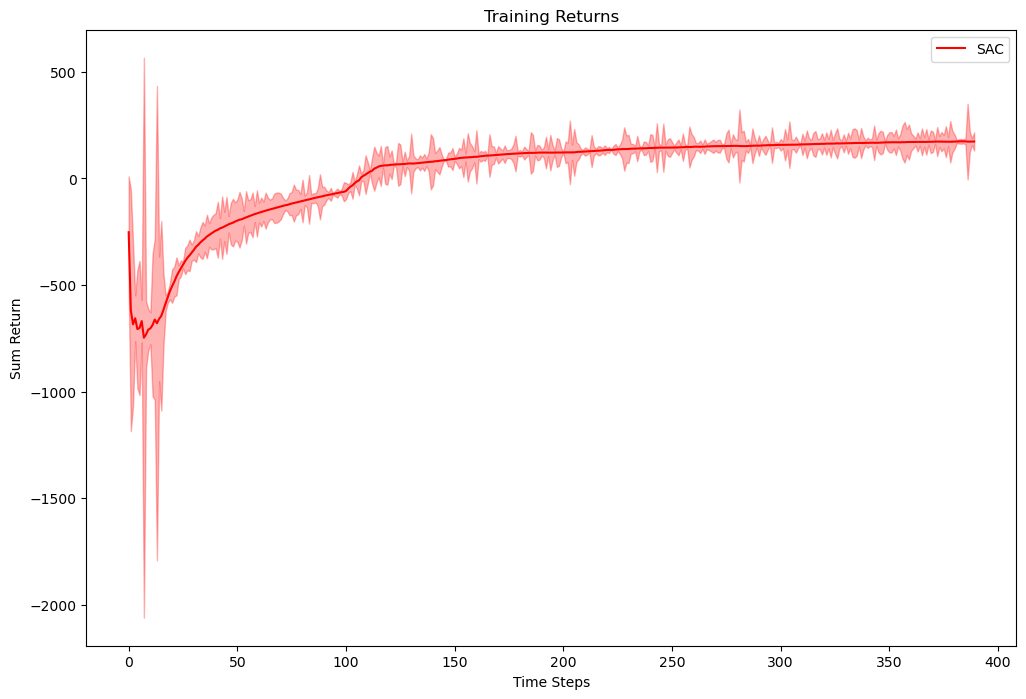

<Figure size 1000x600 with 0 Axes>

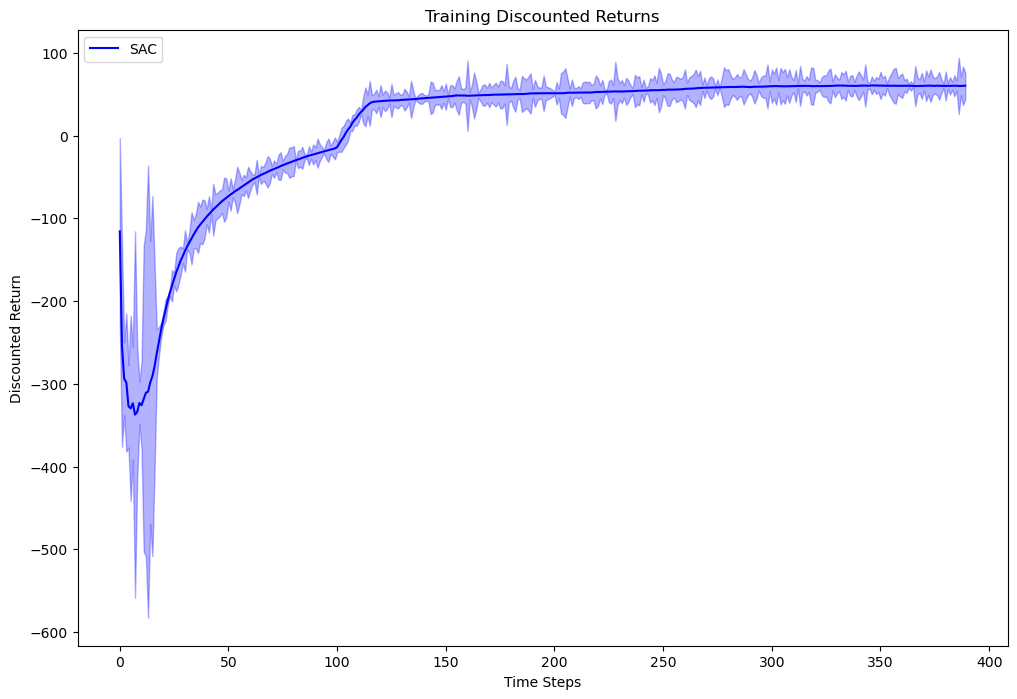

<Figure size 1000x600 with 0 Axes>

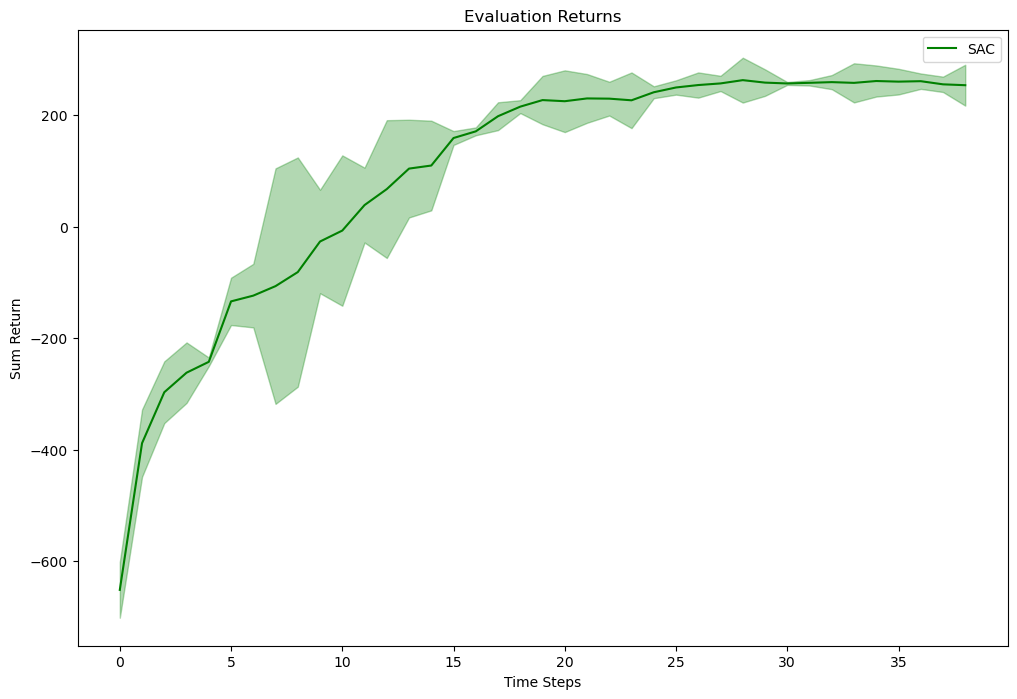

<Figure size 1000x600 with 0 Axes>

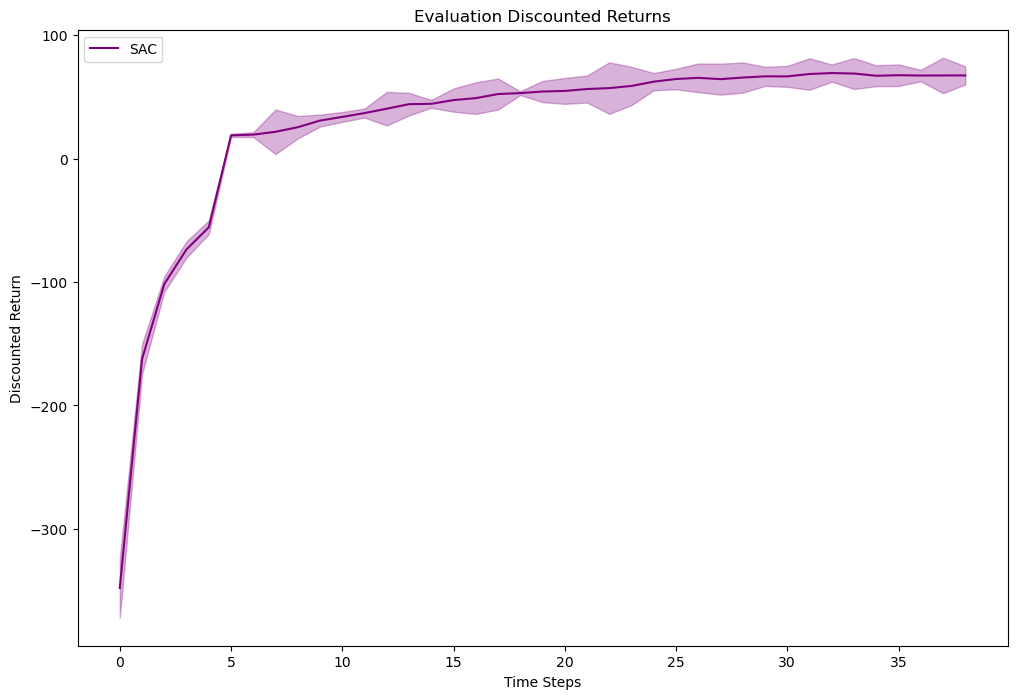

In [73]:
plot_returns_metrics(returns_over_steps_ema, discounted_returns_ema, eval_returns_sum_ema, eval_returns_discount_ema)

In [161]:
env = gym.make('LunarLander-v2')
returns, disc_returns = evaluate_agent(env, lunarSACAgent_ema, num_episodes=100, gamma=0.99)
print(f"Average Return: {returns:.2f}, Average Discounted Return: {disc_returns:.2f}")
# in lunar lander, if the average return is above 200 for 100 episodes, it is considered solved


Average Return: 273.35, Average Discounted Return: 76.39


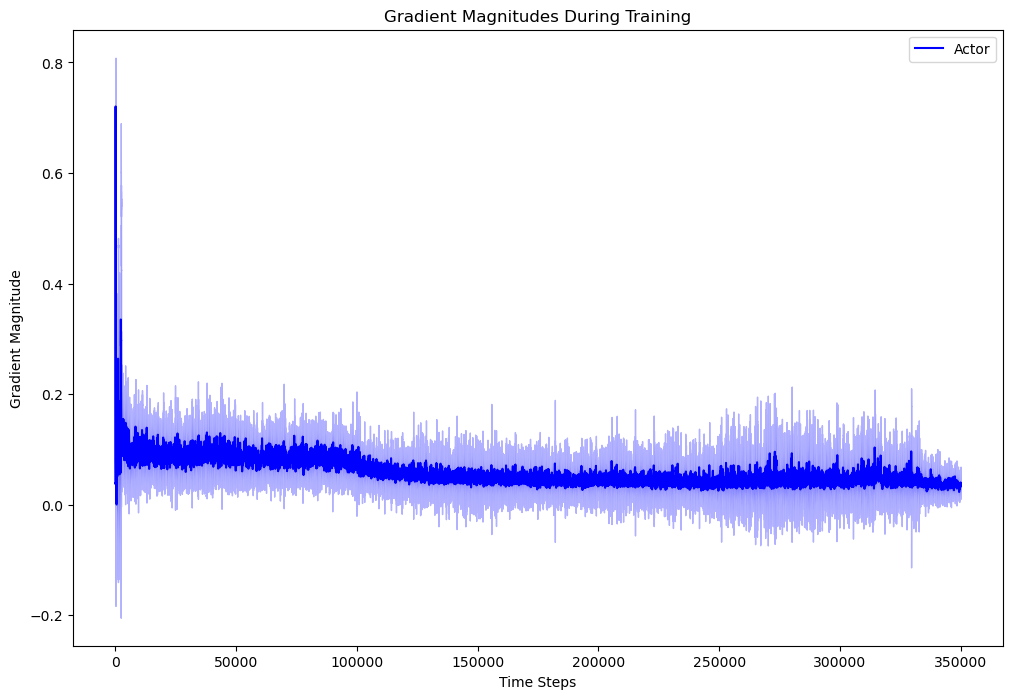

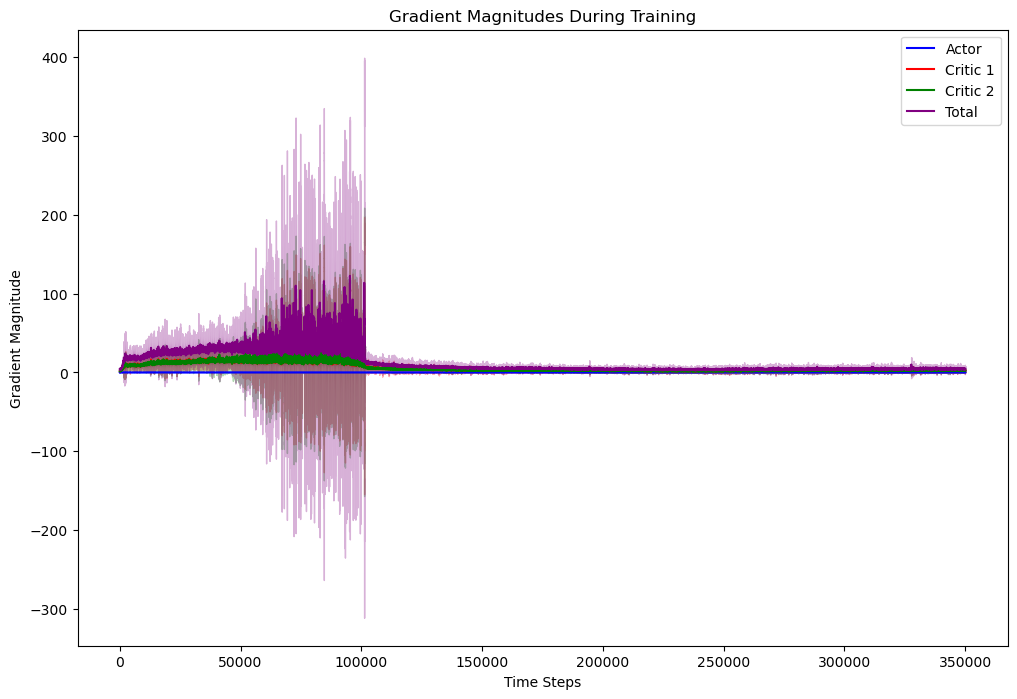

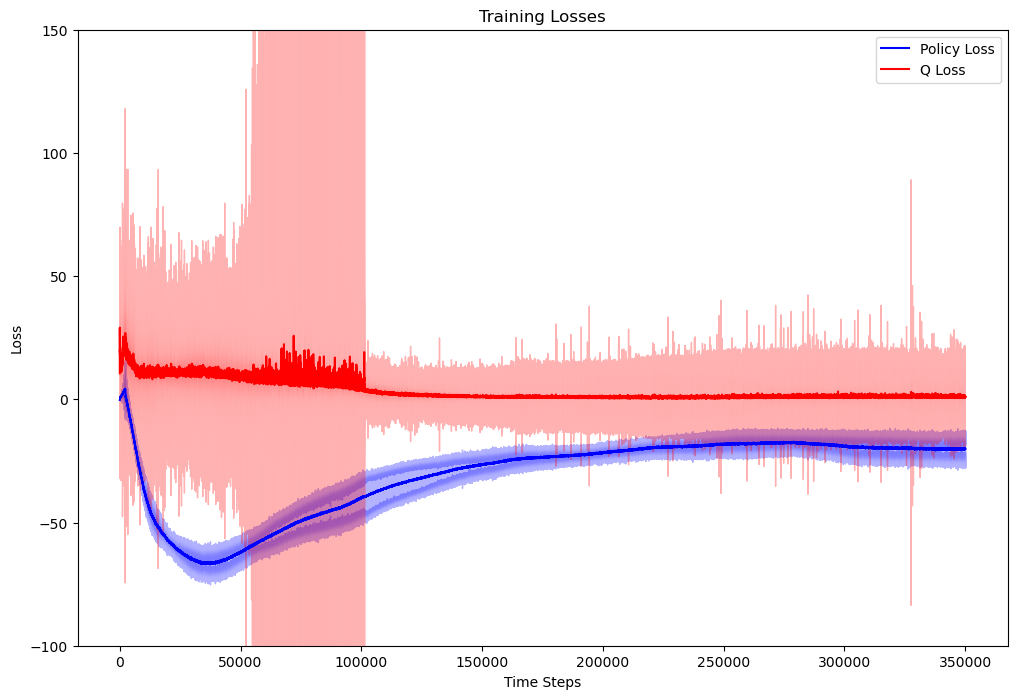

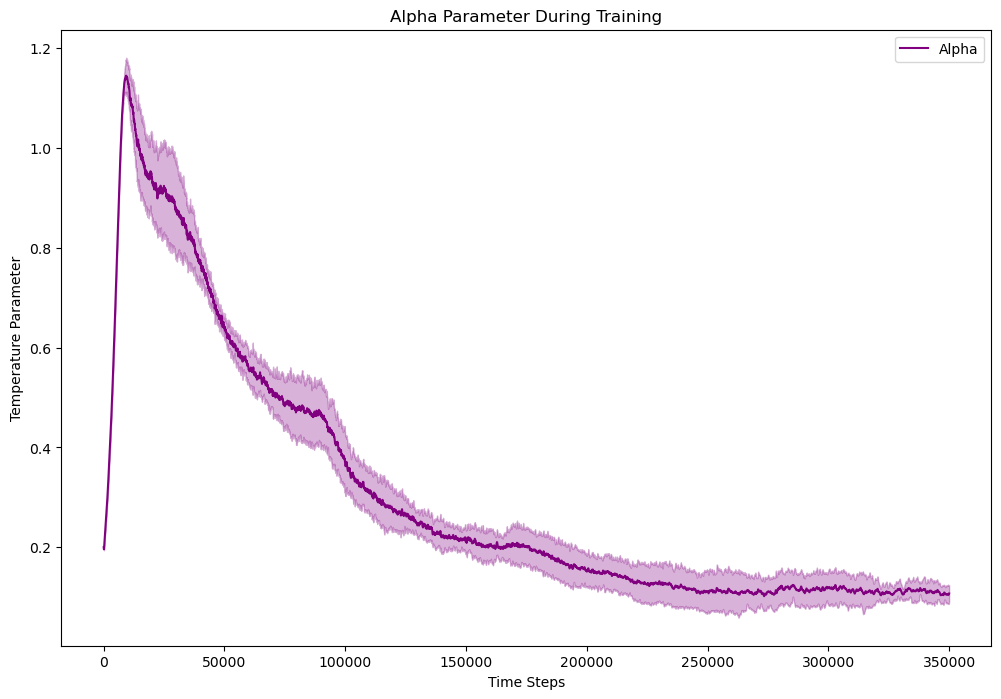

In [133]:
plot_training_metrics(grad_metrics_ema, losses_ema)

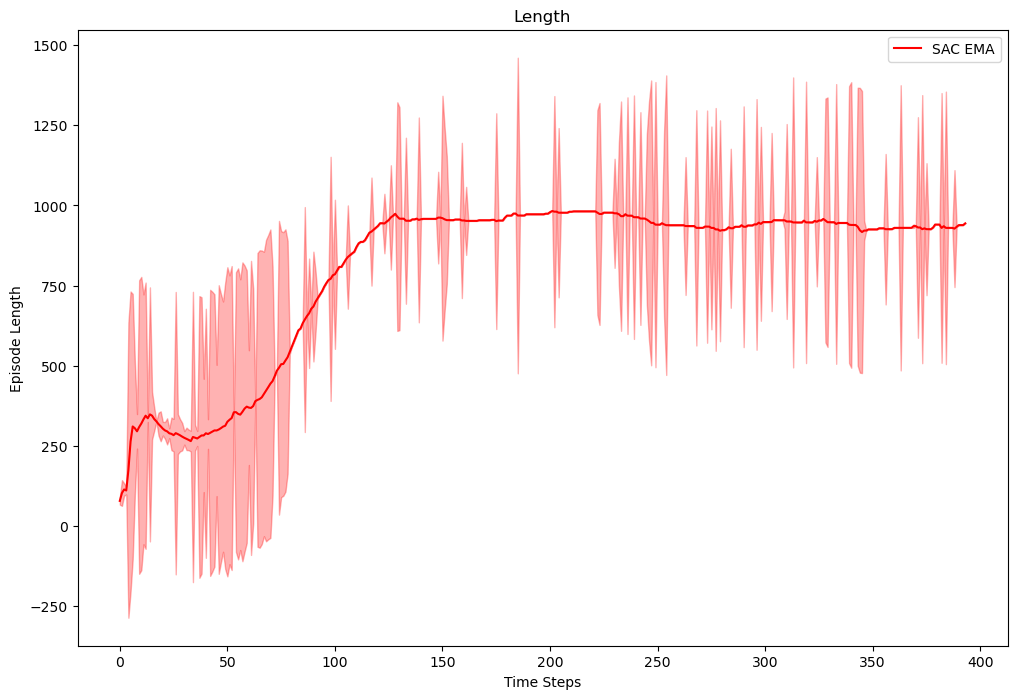

In [91]:
# find min length of episodes list 
min_length = min([len(episode) for episode in episode_lengths_ema])
# truncate all episodes to min length
episode_lengths_ema = [episode[:min_length] for episode in episode_lengths_ema]
# convert to numpy array
episode_lengths_ema_arr = np.array(episode_lengths_ema)
# plot the mean and raw episode lengths
plot_curves([episode_lengths_ema_arr], ['SAC EMA'], ['r'], 'Episode Length', 'Length', smoothing =True)

<Figure size 1000x600 with 0 Axes>

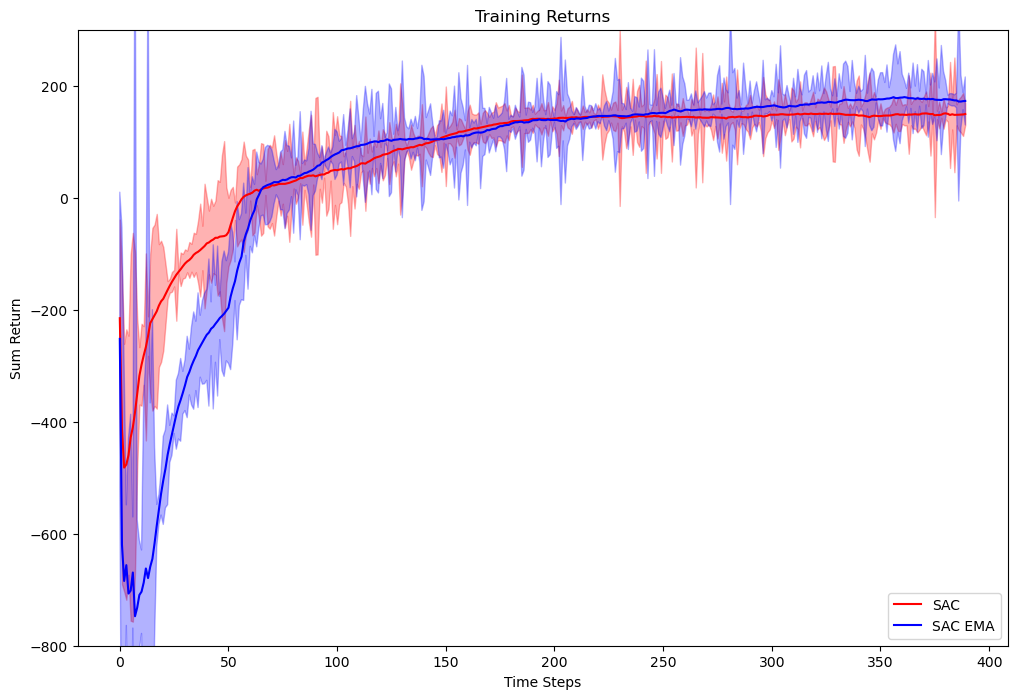

<Figure size 1000x600 with 0 Axes>

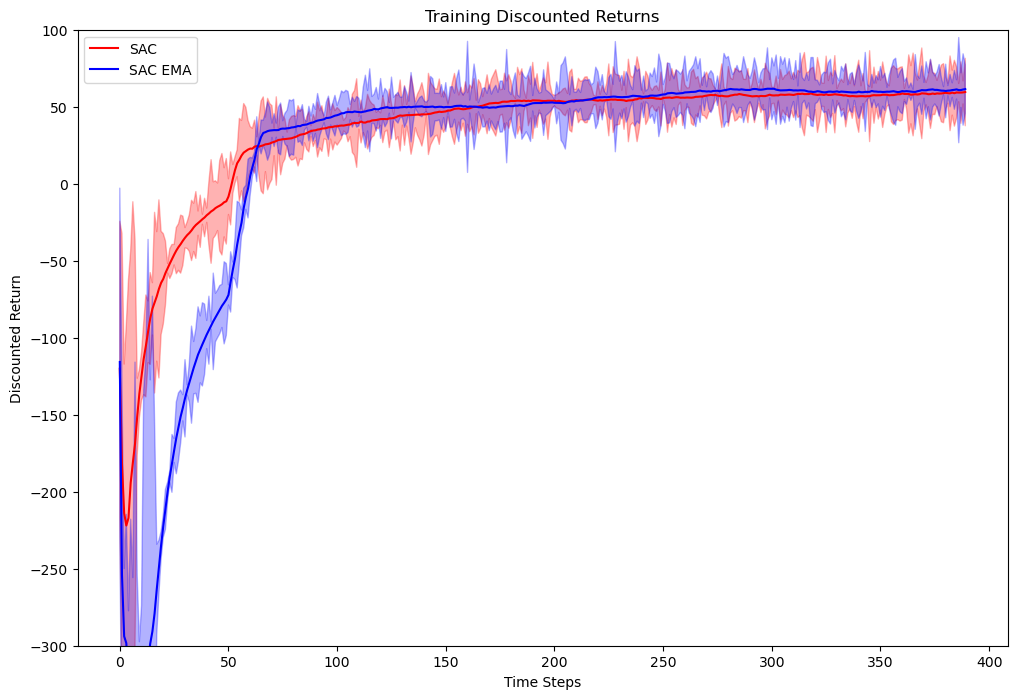

<Figure size 1000x600 with 0 Axes>

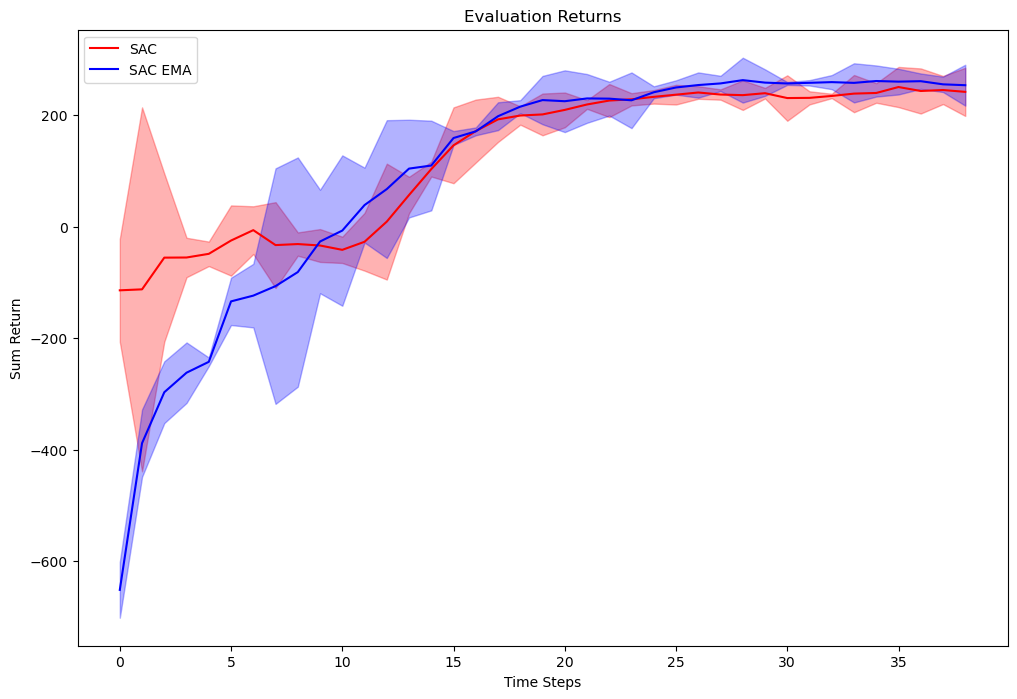

<Figure size 1000x600 with 0 Axes>

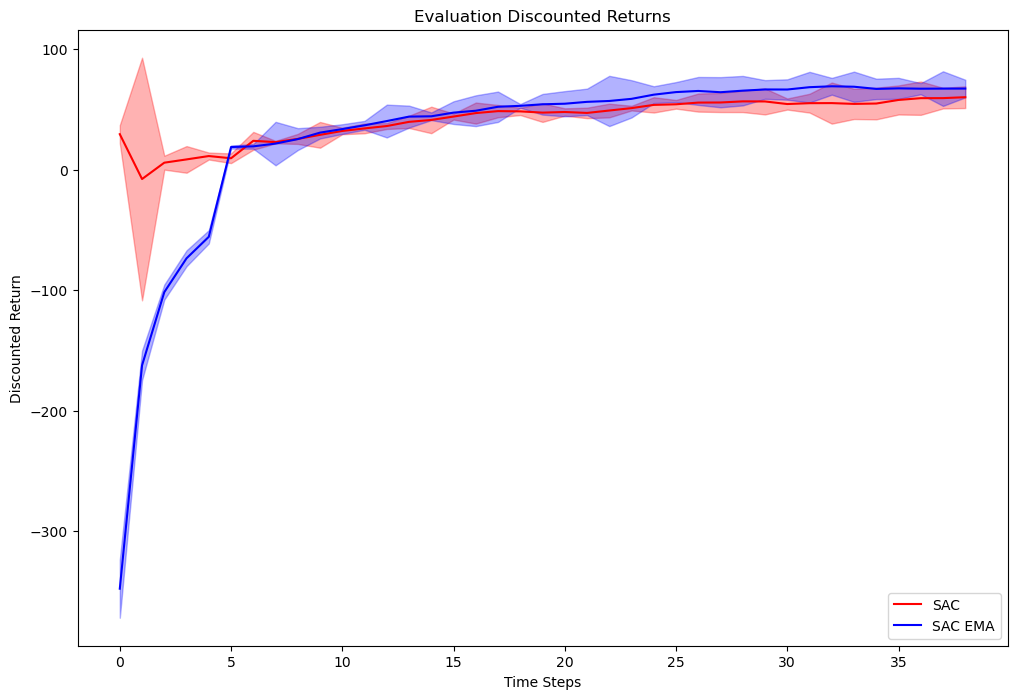

In [120]:
def plot_comparison_metrics(returns_over_steps_1, returns_over_steps_2, 
                          discounted_returns_1, discounted_returns_2,
                          eval_returns_sum_1, eval_returns_sum_2,
                          eval_returns_discount_1, eval_returns_discount_2,
                          names=['Agent 1', 'Agent 2'], 
                          colors=['r', 'b']):
    """
    Create 4 plots comparing metrics between two agents.
    """
    # Find minimum length across all training data
    training_min_len = min(
        min(len(trial) for trial in returns_over_steps_1),
        min(len(trial) for trial in returns_over_steps_2),
        min(len(trial) for trial in discounted_returns_1),
        min(len(trial) for trial in discounted_returns_2)
    )

    # Find minimum length across all evaluation data
    eval_min_len = min(
        min(len(trial) for trial in eval_returns_sum_1),
        min(len(trial) for trial in eval_returns_sum_2),
        min(len(trial) for trial in eval_returns_discount_1),
        min(len(trial) for trial in eval_returns_discount_2)
    )

    # Training returns
    plt.figure(figsize=(10, 6))
    processed_returns_1 = [trial[:training_min_len] for trial in returns_over_steps_1]
    processed_returns_2 = [trial[:training_min_len] for trial in returns_over_steps_2]
    plot_curves([np.array(processed_returns_1), np.array(processed_returns_2)], 
                names, colors, 'Sum Return', 'Training Returns', smoothing=True, limit=(-800, 300))

    # Discounted returns  
    plt.figure(figsize=(10, 6))
    processed_disc_1 = [trial[:training_min_len] for trial in discounted_returns_1]
    processed_disc_2 = [trial[:training_min_len] for trial in discounted_returns_2]
    plot_curves([np.array(processed_disc_1), np.array(processed_disc_2)],
                names, colors, 'Discounted Return', 'Training Discounted Returns', smoothing=True, limit=((-300,100)))

    # Eval returns
    plt.figure(figsize=(10, 6))
    processed_eval_1 = [trial[:eval_min_len] for trial in eval_returns_sum_1]
    processed_eval_2 = [trial[:eval_min_len] for trial in eval_returns_sum_2] 
    plot_curves([np.array(processed_eval_1), np.array(processed_eval_2)],
                names, colors, 'Sum Return', 'Evaluation Returns', smoothing=True, window=5)

    # Eval discounted returns
    plt.figure(figsize=(10, 6))
    processed_eval_disc_1 = [trial[:eval_min_len] for trial in eval_returns_discount_1]
    processed_eval_disc_2 = [trial[:eval_min_len] for trial in eval_returns_discount_2]
    plot_curves([np.array(processed_eval_disc_1), np.array(processed_eval_disc_2)],
                names, colors, 'Discounted Return', 'Evaluation Discounted Returns', smoothing=True, window=5)
    
plot_comparison_metrics(returns_over_steps, returns_over_steps_ema, discounted_returns, discounted_returns_ema, eval_returns_sum, eval_returns_sum_ema, eval_returns_discount, eval_returns_discount_ema, names=['SAC', 'SAC EMA'], colors=['r', 'b'])

In [ ]:

# four rooms with Grade on discrete SAC 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
from collections import namedtuple, deque
import tqdm
import matplotlib.pyplot as plt
from grade import GradientAdaptiveEntropy

# Replay buffer transition tuple
Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    def __init__(self, capacity, state_dim=3, device="cpu"):
        self.capacity = capacity
        self.device = device
        self.memory = []
        self.position = 0
        
    def push(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).to(self.device)
        action = torch.tensor([action], dtype=torch.long).to(self.device)
        reward = torch.tensor([reward], dtype=torch.float32).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.tensor([done], dtype=torch.float32).to(self.device)
        
        transition = Transition(state, action, reward, next_state, done)
        
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        indices = np.random.choice(len(self.memory), batch_size)
        transitions = [self.memory[idx] for idx in indices]
        batch = Transition(*zip(*transitions))
        
        states = torch.stack(batch.state)
        actions = torch.stack(batch.action)
        rewards = torch.stack(batch.reward)
        next_states = torch.stack(batch.next_state)
        dones = torch.stack(batch.done)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
    def forward(self, state):
        return self.net(state)

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, state):
        return self.net(state)

class SACAgent:
    def __init__(self, state_dim=3, action_dim=4, hidden_dim=256,
                 lr=3e-4, gamma=0.99, tau=0.005,
                 batch_size=256, device="cpu"):
        self.gamma = gamma
        self.tau = tau
        self.device = device
        self.batch_size = batch_size
        self.action_dim = action_dim
        
        # Networks
        self.critic1 = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.critic2 = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.critic1_target = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.critic2_target = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.actor = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)
        
        # Copy target parameters
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        
        # Optimizers with eps like reference
        self.critic1_optimizer = torch.optim.Adam(self.critic1.parameters(), lr=lr, eps=1e-4)
        self.critic2_optimizer = torch.optim.Adam(self.critic2.parameters(), lr=lr, eps=1e-4)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr, eps=1e-4)
        
        # Entropy tuning matching reference
        self.target_entropy = -np.log((1.0 / action_dim)) * 0.5 
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=lr, eps=1e-4)
        
    @property
    def alpha(self):
        return self.log_alpha.exp()
    
    def get_action(self, state, evaluate=False):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            action_probs = self.actor(state)
            if evaluate:
                action = torch.argmax(action_probs, dim=-1)
            else:
                dist = Categorical(action_probs)
                action = dist.sample()
            return action.item()
    
    def calculate_critic_losses(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        with torch.no_grad():
            next_action_probs = self.actor(next_state_batch)
            # Handle zero probabilities exactly like reference
            z = next_action_probs == 0.0
            z = z.float() * 1e-8
            log_next_action_probs = torch.log(next_action_probs + z)
            
            next_q1 = self.critic1_target(next_state_batch)
            next_q2 = self.critic2_target(next_state_batch)
            
            # Matching reference implementation exactly
            min_qf_next_target = next_action_probs * (
                torch.min(next_q1, next_q2) - self.alpha * log_next_action_probs
            )
            min_qf_next_target = min_qf_next_target.sum(dim=1).unsqueeze(-1)
            next_q_value = reward_batch + (1 - done_batch) * self.gamma * min_qf_next_target

        q1 = self.critic1(state_batch).gather(1, action_batch.long())
        q2 = self.critic2(state_batch).gather(1, action_batch.long())
        
        critic1_loss = F.mse_loss(q1, next_q_value)
        critic2_loss = F.mse_loss(q2, next_q_value)
        
        return critic1_loss, critic2_loss

    def calculate_actor_loss(self, state_batch):
        action_probs = self.actor(state_batch)
        # Handle zero probabilities
        z = action_probs == 0.0
        z = z.float() * 1e-8
        log_action_probs = torch.log(action_probs + z)
        
        q1 = self.critic1(state_batch)
        q2 = self.critic2(state_batch)
        min_q = torch.min(q1, q2).detach()
        
        # Matching reference implementation
        inside_term = self.alpha * log_action_probs - min_q
        policy_loss = (action_probs * inside_term).sum(dim=1).mean()
        log_action_probs = torch.sum(log_action_probs * action_probs, dim=1)
        
        return policy_loss, log_action_probs
    # Standard Four Rooms SAC Update Method
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch, total_steps, freq_update_target):
        """Standard SAC update for Four Rooms"""
        # Get gradients before updates
        pre_grad_stats = track_grad_stats(self)
        
        # Critic update
        critic1_loss, critic2_loss = self.calculate_critic_losses(
            state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()
        
        # Actor update
        policy_loss, log_probs = self.calculate_actor_loss(state_batch)
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        # Alpha update 
        alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        # Target update
        if total_steps % freq_update_target == 0:
            for target_param, param in zip(self.critic1_target.parameters(), self.critic1.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
            for target_param, param in zip(self.critic2_target.parameters(), self.critic2.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
                
        return pre_grad_stats, {
            'critic1_loss': critic1_loss.item(),
            'critic2_loss': critic2_loss.item(),
            'policy_loss': policy_loss.item(),
            'alpha': self.alpha.item()
    }
def evaluate_policy(env, agent, num_episodes=5):
    """Runs policy evaluation episodes."""
    eval_returns = []
    eval_successes = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        state_features = [state[0] / 10.0, state[1] / 10.0, 1.0]
        episode_return = 0
        done = False
        reached_goal = False

        while not done:
            action = agent.get_action(state_features, evaluate=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                reached_goal = True

            episode_return += reward
            state = next_state
            state_features = [state[0] / 10.0, state[1] / 10.0, 1.0]

        eval_returns.append(episode_return)
        eval_successes.append(float(reached_goal))

    # Return all evaluation returns and successes for further processing
    return np.array(eval_returns), np.array(eval_successes)


def train_sac_trials(num_trials=10, num_episodes=10000, smoothing=True):
    """Run multiple trials with detailed logging"""
    all_returns = []
    all_losses = []
    eval_returns_array = np.zeros((num_trials, num_episodes // 100 + 1, 5))  # Store all episodes
    eval_success_array = np.zeros((num_trials, num_episodes // 100 + 1, 5))  # Store all episodes
    all_grad_metrics = []
    
    training_params = {
        'num_episodes': num_episodes,
        'batch_size': 256,
        'buffer_size': 10_000,
        'learning_rate': 3e-4,
        'hidden_dim': 256,
        'gamma': 0.99,
        'tau': 0.005,
        'min_steps_before_learning': 5000,
        "freq_update_target": 1,
        "updates_per_step": 1, 
        "steps_per_update": 1
    }
    
    for trial in range(num_trials):
        print(f"\nTrial {trial + 1}/{num_trials}")
        
        # Set seeds
        torch.manual_seed(trial)
        np.random.seed(trial)
        
        env = FourRooms()
        eval_env = FourRooms()
        agent = SACAgent()
        buffer = ReplayBuffer(training_params['buffer_size'])
        
        # Training metrics
        trial_returns = []
        episode_lengths = []
        q_values = []
        entropies = []
        alphas = []
        policy_losses = []
        q_losses = []
        success_rate = []
        grad_metrics = {
            'actor_grad_mag': [],
            'critic1_grad_mag': [],
            'critic2_grad_mag': [],
            'total_grad_mag': []
        }
        
        total_steps = 0
        pbar = tqdm.trange(training_params['num_episodes'])
        
        for episode in pbar:
            state, _ = env.reset()
            episode_rewards = []
            episode_length = 0
            episode_q_values = []
            episode_entropies = []
            
            done = False
            reached_goal = False
            
            while not done:
                # Get state features and action
                state_features = [state[0]/10.0, state[1]/10.0, 1.0]
                state_tensor = torch.FloatTensor(state_features).unsqueeze(0).to(agent.device)
                
                # Get action and log metrics
                with torch.no_grad():
                    probs = agent.actor(state_tensor)
                    q1 = agent.critic1(state_tensor)
                    q2 = agent.critic2(state_tensor)
                    episode_q_values.append(torch.max(torch.min(q1, q2)).item())
                    entropy = -(probs * torch.log(probs + 1e-8)).sum(1).item()
                    episode_entropies.append(entropy)
                
                action = agent.get_action(state_features)
                
                # Environment step
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                if terminated:
                    reached_goal = True
                
                next_state_features = [next_state[0]/10.0, next_state[1]/10.0, 1.0]
                
                # Store transition
                buffer.push(state_features, action, reward, next_state_features, done)
                
                            # Update if enough samples
                if total_steps > training_params['min_steps_before_learning'] and len(buffer) >= training_params['batch_size'] and total_steps % training_params['steps_per_update'] == 0:
                    for _ in range(training_params["updates_per_step"]):
                        batch = buffer.sample(training_params['batch_size'])
                        grad_stats, loss_dict = agent.update(*batch, total_steps, training_params["freq_update_target"])

                        for key, value in grad_stats.items():
                            grad_metrics[key].append(value)
                        
                        
                        policy_losses.append(loss_dict['policy_loss'])
                        q_losses.append((loss_dict['critic1_loss'] + loss_dict['critic2_loss']) / 2)
                        alphas.append(loss_dict['alpha'])
                        
                episode_rewards.append(reward)
                episode_length += 1
                total_steps += 1
                state = next_state
            
            # Compute total discounted return for the episode
            G = 0
            for r in reversed(episode_rewards):
                G = r + training_params['gamma'] * G
            episode_return = G  # Total discounted return for the episode
            
            # Store the episode return
            #print(episode_return)
            #print("append to trial_returns")
            trial_returns.append(episode_return)
            episode_lengths.append(episode_length)
            success_rate.append(float(reached_goal))
            
            if episode_q_values:
                q_values.append(np.mean(episode_q_values))
            if episode_entropies:
                entropies.append(np.mean(episode_entropies))
            
            # Update progress bar with per-episode return
            current_return = trial_returns[-1]
            avg_return = np.mean(trial_returns[-100:]) if len(trial_returns) >= 100 else np.mean(trial_returns)
            avg_success = np.mean(success_rate[-100:]) * 100 if len(success_rate) >= 100 else np.mean(success_rate) * 100
            avg_length = np.mean(episode_lengths[-100:]) if len(episode_lengths) >= 100 else np.mean(episode_lengths)
            
            current_alpha = alphas[-1] if alphas else 0
            current_entropy = entropies[-1] if entropies else 0
            
            desc = f"Ep:{episode} | R:{current_return:.1f} | AvgR:{avg_return:.1f} | Succ:{avg_success:.1f}% | Len:{avg_length:.1f}"
            if alphas:
                desc += f" | α:{current_alpha:.3f}"
            if entropies:
                desc += f" | H:{current_entropy:.2f}"
            
            pbar.set_description(desc)
            
            # Periodically print detailed stats
            if episode % 100 == 0 and episode > 0:
                eval_returns, eval_successes = evaluate_policy(eval_env, agent)
                # Store raw evaluation returns and successes
                eval_idx = episode // 100
                eval_returns_array[trial, eval_idx] = eval_returns
                eval_success_array[trial, eval_idx] = eval_successes

                stats = f"\nEpisode {episode} Statistics:"
                stats += f"\nEpisode Return: {current_return:.2f}"
                stats += f"\nAverage Return (100 ep): {np.mean(trial_returns[-100:]):.2f} ± {np.std(trial_returns[-100:]):.2f}"
                stats += f"\nSuccess Rate (100 ep): {np.mean(success_rate[-100:]) * 100:.1f}%"
                stats += f"\nAverage Episode Length: {np.mean(episode_lengths[-100:]):.1f}"
                # add evaluation stats
                stats += f"\nEvaluation Return: {np.mean(eval_returns):.2f}"
                stats += f"\nEvaluation Success Rate: {(np.mean(eval_successes)*100):.1f}%"
                if q_values:
                    stats += f"\nAverage Q-Value: {np.mean(q_values[-100:]):.2f}"
                if entropies:
                    stats += f"\nPolicy Entropy: {np.mean(entropies[-100:]):.3f}"
                if alphas:
                    stats += f"\nAlpha: {alphas[-1]:.3f}"
                if policy_losses:
                    stats += f"\nPolicy Loss: {np.mean(policy_losses[-100:]):.3f}"
                if q_losses:
                    stats += f"\nQ Loss: {np.mean(q_losses[-100:]):.3f}"
                stats += "\n" + "-" * 50
                pbar.write(stats)
        
        # Store trial results
        print("append to all_returns")
        all_returns.append(trial_returns)
        all_grad_metrics.append(grad_metrics)
        all_losses.append({
            'policy_loss': policy_losses,
            'q_loss': q_losses,
            'alpha': alphas
        })
        
        if len(trial_returns) > 0:
            plt.figure(figsize=(15, 10))
            
            # Plot returns
            plt.subplot(2, 2, 1)
            plt.plot(trial_returns)
            plt.title(f'Returns - Trial {trial+1}')
            plt.xlabel('Episode')
            plt.ylabel('Return')
            
            # Plot success rate
            plt.subplot(2, 2, 2)
            plt.plot(moving_average(np.array(success_rate)) if smoothing else success_rate)
            plt.title('Success Rate')
            plt.xlabel('Episode')
            plt.ylabel('Success Rate')
            
            # Plot entropy if we have it
            if entropies:
                plt.subplot(2, 2, 3)
                plt.plot(moving_average(np.array(entropies)) if smoothing else entropies)
                plt.title('Policy Entropy')
                plt.xlabel('Episode')
                plt.ylabel('Entropy')
            
            # Plot alpha if we have it
            if alphas:
                plt.subplot(2, 2, 4)
                plt.plot(alphas)
                plt.title('Temperature Parameter (α)')
                plt.xlabel('Update Step')
                plt.ylabel('Alpha')
            
            plt.tight_layout()
            plt.show()
    
    return all_returns, eval_returns_array, eval_success_array, all_losses, all_grad_metrics, agent


# Run training
returns, eval_returns, eval_success, losses, grad_metrics, agent = train_sac_trials(num_trials=5, num_episodes=1000)